# Problem Set: Solar Power Generation Data
Student: Andreas Eppler<br>
Date: 24.02.2022<br>
University: Karlsruhe Institute of Technology (KIT)<br>
Course: Data Driven Engineering 1: Machine Learning for Dynamical Systems

## Outline:
[1. Problem definition: short term solar power generation forecasting](#1-problem-definition-short-term-solar-power-generation-forecasting)<br>
>[1.1 Working principle of a solar power plant](#11-working-principle-of-a-solar-power-plant)<br>
[1.2 Choosing a measure of Loss/Success](#12-choosing-a-measure-of-losssuccess)<br>
[1.3 Libraries](#13-libraries)

[2: Data Exploration and Preparation](#2-data-exploration-and-preparation)<br> 
>[2.1: Data Exploration](#21-data-exploration)<br> 
[2.2 Data Preparation](#22-data-preparation)<br> 
[2.3 Correlations](#23-correlations)

[3. Testing Phase I: Baseline Models](#3-testing-phase-i-baseline-models)<br>
>[3.1 Autoregression](#31-autoregression)<br>
[3.2 SARIMAX Model](#32-sarimax-model)<br>
[3.3 Baseline Model](#33-baseline-model)<br>
[3.4 SVM](#34-svm)<br>
[3.5 Bayesian Ridge Regression](#35-bayesian-ridge-regression)<br>
[3.6 Elastic Net](#36-elastic-net)<br>
[3.7 Gradient Boosting](#37-gradient-boosting)

[4. Testing Phase II: Model Development](#4-testing-phase-2-model-development)<br>
>[4.1 Simple Neural Network](#41-simple-neural-network)<br>
[4.2 LSTM](#42-lstm)

[5. Evaluation of the model predictions](#5-evaluation-of-the-model-predictions)

[6. Lessons learn and conclusions](#6-lessons-learnt-and-conclusions)

# 1: Problem definition: short term solar power generation forecasting
Data taken from: https://www.kaggle.com/anikannal/solar-power-generation-data?select=Plant_2_Weather_Sensor_Data.csv <br>
"The data of the problem set has been gathered at two solar power plants located in India. The data covers a 34 day period. It has two pairs of files - each pair has one power generation dataset and one sensor readings dataset. The power generation datasets are gathered at the inverter level - each inverter has multiple lines of solar panels attached to it. The sensor data is gathered at the plant level with a single array of sensors optimally placed at the plant."

The power grid is a very dynamic system in which the energy producers and consumers must be kept in constant balance. An important indicator for this is the grid frequency. In the European interconnected grid, this is 50 Hz and is synchronous with power generators in power plants. If there is an oversupply of electrical power in the power grid, the power plant turbines experience a higher resistance Torque due to the generator, which means that they have to rotate faster in order to maintain the same power output ($P = M*\omega$ applies). Therefore, the grid frequency decreases. In the case of undersupply, the opposite is true. If the grid frequency falls below or exceeds a critical value, the power plants must be taken off the grid, otherwise cavitation could occur and damage the turbine blades. For further explanations, see https://en.wikipedia.org/wiki/Utility_frequency <br>
In order to limit the effects of climate change, it is essential to get to net zero carbon emissions in the upcoming decade(s). Rewenable energy will be the driving force behind that transition away from fossile fuels. <br>
Due to the nature of Solar and wind power the energy grid will need to be way more dynamically regulated in the coming years. Being able to forecast renewable energy production for the next couple of days will be a huge help to regulate the grid via storage solutions such as pumped-storage power plants, home storage systems, hydrogen electrolysers and electric cars with bidirectional charging capability. This will allow to enable a stable, prosumer driven grid.
>In this notebook, the goal is to examine the forecasting possibilities of different Machine Learning Models in the scope of this data set.

In [1]:
from IPython.display import Image
Image(url="solar_power_plant.svg", width = 700)

#### 1.1 working principle of a solar power plant
>The self-created image shows the basic build of a solar power plant. Rows of modules are wired together and then connected to an inverter, that transforms the DC current to an AC current in order to feed the energy into the electric grid. The single modules can either be wired together with a parallel or series connection (as shown in the above image). 
There are advantages and disadvantages to both the interconnection options.
>- In a series connection, the current stays the same while the voltage is increased with each module. This allows for easy wiring. However, if only one of the modules is faulty or produces a lower current due to shading, the current and with that, the power of the whole installation decreases. 
>- With a parallel connection, the voltage remeains persistent while the current of the modules is added up. With it, shading and faulty modules are less of a problem. However, faulty modules are also harder to detect. Due to the larger currents, the wiring requires more effort and is more expensive.

source: https://www.solaranlage.eu/photovoltaik/technik-komponenten/wechselrichter/konzepte-zur-verschaltung

#### 1.2 Choosing a measure of Loss/Success:

since power forcasting is a regression task, the following are the most common measures of loss / success that we can use:
* mean squared error $MSE = \sum_{i=1}^{N}(y_i-\hat{y_i})^2$ with $y = y_{true}$, $\hat{y} = y_{predicted}$

* mean absolute error $MAE = \sum_{i=1}^{N}|y_i-\hat{y_i}|$

* mean absolute percentage error $MAPE = \frac{100\%}{N}\sum_{i=1}^{N}\frac{y_i-\hat{y_i}}{y_i}$

* Coefficient of determination $R² = \frac{\sum_{i=1}^{N}(\hat{y_i}-\bar{y})^2} {\sum_{i=1}^{N}(y_i-\bar{y})^2}$ with $\bar{y} = \frac{1}{N}\sum_{i=1}^{N}y_i$
>We cannot use MAPE since the error goes to infinity for y_true values of zero of which exist a lot in this dataset since the power is zero during nighttime hours.<br>
We will use the R² error for evaluation of model performance since it is a very intuitive error.<br>
We will further use MAE for evaluation of model performance as it is possesses the predictor units and is therefore natural to understand<br>
As a loss quantity for model training and hyperparameter optimization, we will use MSE, as it penalizes outliers more heavily than MAE, which often leads to faster training and less noisy predictions.

## 1.3 Libraries

In [2]:
%pip install ipython-autotime
%load_ext autotime

Note: you may need to restart the kernel to use updated packages.
time: 0 ns (started: 2022-03-29 11:07:30 +02:00)


We will use optuna for hyperparameter tuning so let´s first install it.

In [3]:
!python -m pip install --user optuna

time: 3.08 s (started: 2022-03-29 11:07:30 +02:00)


In [4]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import datetime as dt
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import matplotlib.dates as mdates
hour_minutes = mdates.DateFormatter('%H:%M')
import statsmodels.api as sm
import warnings
import matplotlib.dates as mdates
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from pandas.tseries.offsets import DateOffset

time: 4.31 s (started: 2022-03-29 11:07:33 +02:00)


In [5]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import optuna as op
from optuna.visualization.matplotlib import plot_optimization_history

time: 1.62 s (started: 2022-03-29 11:07:38 +02:00)


In [6]:
# ML Algorithms to be used

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge, ElasticNet, LinearRegression
from xgboost import XGBRegressor
# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__

'2.2.0'

time: 5.98 s (started: 2022-03-29 11:07:40 +02:00)


# 2: Data Exploration and Preparation

## 2.1 Data Exploration

>In the following, for the sake of improved clarity, only the second solar power plant is being investigated. Provided underneath is the option to switch to the first power plant for reasons of boundless curiosity. The code is executable for both the plants. However, please note that the comments and selected parameters only make sense for the second plant though

In [7]:
# plant_no = 1
plant_no = 2

time: 0 ns (started: 2022-03-29 11:07:46 +02:00)


### 2.1.1 Plant Data:

In [8]:
gen_data = pd.read_csv(f'Plant_{plant_no}_Generation_Data.csv')
gen_data

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0       5/15/2020 0:00   4136001  4UPUqMRk7TRMgml       0.0       0.0   
1       5/15/2020 0:00   4136001  81aHJ1q11NBPMrL       0.0       0.0   
2       5/15/2020 0:00   4136001  9kRcWv60rDACzjR       0.0       0.0   
3       5/15/2020 0:00   4136001  Et9kgGMDl729KT4       0.0       0.0   
4       5/15/2020 0:00   4136001  IQ2d7wF4YD8zU1Q       0.0       0.0   
...                ...       ...              ...       ...       ...   
67693  6/17/2020 23:45   4136001  q49J1IKaHRwDQnt       0.0       0.0   
67694  6/17/2020 23:45   4136001  rrq4fwE8jgrTyWY       0.0       0.0   
67695  6/17/2020 23:45   4136001  vOuJvMaM2sgwLmb       0.0       0.0   
67696  6/17/2020 23:45   4136001  xMbIugepa2P7lBB       0.0       0.0   
67697  6/17/2020 23:45   4136001  xoJJ8DcxJEcupym       0.0       0.0   

       DAILY_YIELD   TOTAL_YIELD  
0      9425.000000  2.429011e+06  
1         0.000000  1.215279e+09  
2      3075.333333  2.247720e+09  
3       269.933333  1.704250e+06  
4      3177.000000  1.994153e+07  
...            ...           ...  
67693  4157.000000  5.207580e+05  
67694  3931.000000  1.211314e+08  
67695  4322.000000  2.427691e+06  
67696  4218.000000  1.068964e+08  
67697  4316.000000  2.093357e+08  

[67698 rows x 7 columns]

time: 157 ms (started: 2022-03-29 11:07:46 +02:00)


There are seven columns for both the data sets consisting of the plant id (same for the entire dataset), the id of each inverter (source_key), AC- and DC-power, daily yield and total yield. From kaggle, we take the following information:
1. DATE_TIME:   Date and time for each observation. Observations recorded at 15 minute intervals.
2. PLANT_ID:    Plant ID - this will be common for the entire file. ***(can therefore be deleted)***
3. SOURCE_KEY:  Source key in this file stands for the inverter id.
4. DC_POWER:    Amount of DC power generated by the inverter (source_key) in this 15 minute interval. Units - kW. ***(explanation makes no sense, since power over a time interval would be energy, so it´s probably the average power during that interval. Also, it should be power generated by the modules connected to one inverter)***
5. AC_POWER:    Amount of AC power generated by the inverter (source_key) in this 15 minute interval. Units - kW. ***(should be average AC power after conversion by the inverter during each 15 minute interval)***
6. DAILY_YIELD: Daily yield is a cumulative sum of power generated on that day, till that point in time. ***(This is probably energy in kWh, not power, explanation for this assumption can be found later)***
7. TOTAL_YIELD: This is the total yield for the inverter till that point in time.

### 2.1.2 Weather Data:

In [9]:
weather_data = pd.read_csv(f'Plant_{plant_no}_Weather_Sensor_Data.csv')
weather_data

DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0     2020-05-15 00:00:00   4136001  iq8k7ZNt4Mwm3w0            27.004764   
1     2020-05-15 00:15:00   4136001  iq8k7ZNt4Mwm3w0            26.880811   
2     2020-05-15 00:30:00   4136001  iq8k7ZNt4Mwm3w0            26.682055   
3     2020-05-15 00:45:00   4136001  iq8k7ZNt4Mwm3w0            26.500589   
4     2020-05-15 01:00:00   4136001  iq8k7ZNt4Mwm3w0            26.596148   
...                   ...       ...              ...                  ...   
3254  2020-06-17 22:45:00   4136001  iq8k7ZNt4Mwm3w0            23.511703   
3255  2020-06-17 23:00:00   4136001  iq8k7ZNt4Mwm3w0            23.482282   
3256  2020-06-17 23:15:00   4136001  iq8k7ZNt4Mwm3w0            23.354743   
3257  2020-06-17 23:30:00   4136001  iq8k7ZNt4Mwm3w0            23.291048   
3258  2020-06-17 23:45:00   4136001  iq8k7ZNt4Mwm3w0            23.202871   

      MODULE_TEMPERATURE  IRRADIATION  
0              25.060789          0.0  
1              24.421869          0.0  
2              24.427290          0.0  
3              24.420678          0.0  
4              25.088210          0.0  
...                  ...          ...  
3254           22.856201          0.0  
3255           22.744190          0.0  
3256           22.492245          0.0  
3257           22.373909          0.0  
3258           22.535908          0.0  

[3259 rows x 6 columns]

time: 32 ms (started: 2022-03-29 11:07:47 +02:00)


In [10]:
weather_data["SOURCE_KEY"][0] in gen_data["SOURCE_KEY"]

False

time: 0 ns (started: 2022-03-29 11:07:47 +02:00)


The above code shows that the weather sensor source key is not in list of inverter ids

We can see that the weather data covers the same period of time and is taken at the same plant (similar plant id). The data covers the ambient temperature, module temperature and the irradiation, which will be really helpful for time series prediction. 
Irradiation and with this the number of photons is directly linked to the energy output of the solar panels while the temperature of a solar module changes the efficiency of the modules. As a general rule, the efficiency of a solar panel declines with increasing temperatures. 
Unfortunately, as checked in the cell above, we don´t know which module the module temperature has been taken at but for the further analysis let´s assume that the temperature reading is representative for all the modules.
The temperature seems to be taken in degrees Celsius.
1. Date and time for each observation. Observations recorded at 15 minute intervals.
2. Plant ID - this will be common for the entire file. ***(can therefore be deleted)***
3. Stands for the sensor panel id. This will be common for the entire file because there's only one sensor panel for the plant. ***(can therefore be deleted)***
4. This is the ambient temperature at the plant. ***(most likely in °C)***
5. There's a module (solar panel) attached to the sensor panel. This is the temperature reading for that module. ***(most likely in °C)***
6. Amount of irradiation for the 15 minute interval.

### 2.1.3 checking for missing data

In [11]:
print(gen_data.info())
print(weather_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    67698 non-null  object 
 1   PLANT_ID     67698 non-null  int64  
 2   SOURCE_KEY   67698 non-null  object 
 3   DC_POWER     67698 non-null  float64
 4   AC_POWER     67698 non-null  float64
 5   DAILY_YIELD  67698 non-null  float64
 6   TOTAL_YIELD  67698 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3259 non-null   object 
 1   PLANT_ID             3259 non-null   int64  
 2   SOURCE_KEY           3259 non-null   object 
 3   AMBIENT_TEMPERATURE  3259 non-null   float64
 4   MODULE_TEMPERATURE   3259 non-null  

>Fortunately, the data seems to contain no null object values that need to be dealt with. However, a period of 34 days should cover 34x24x4= 3264 values, so there seem to be some missing time steps.

Let´s first convert the date and time information to represent the indices of our data frame.

In [12]:
dt_gen, dt_weather = 0, 0
if plant_no == 1:
    dt_gen = pd.to_datetime(gen_data["DATE_TIME"], format='%d-%m-%Y %H:%M').values
    dt_weather = pd.to_datetime(weather_data["DATE_TIME"], format='%Y-%m-%d %H:%M:%S').values
if plant_no == 2:
    dt_gen = pd.to_datetime(gen_data["DATE_TIME"], format='%m/%d/%Y %H:%M').values
    dt_weather = pd.to_datetime(weather_data["DATE_TIME"], format='%Y-%m-%d %H:%M:%S').values
gen_data=(gen_data.set_index(pd.DatetimeIndex(dt_gen))).drop(['DATE_TIME', 'PLANT_ID'],axis=1)
weather_data=(weather_data.set_index(pd.DatetimeIndex(dt_weather))).drop(['DATE_TIME', 'PLANT_ID','SOURCE_KEY'],axis=1)

time: 47 ms (started: 2022-03-29 11:07:48 +02:00)


With this, we can now check for missing sonsor readings. To accomplish this, a list of all 15 minutes intervals between the first and last time step is created and compared with the datetime lists of the dataframe. The resulting number of inverter readings per time step is stored in a dictionary

In [13]:
dt_list = np.arange(dt_gen[0], dt_gen[-1]+np.timedelta64(15, 'm'), np.timedelta64(15, 'm')).astype('datetime64[m]').tolist()  
dt_gen_dict = dict(zip(dt_list, [0]*len(dt_list)))
dt_weather_dict = dict(zip(dt_list, [0]*len(dt_list)))
counter = 0

for datetime in dt_list:
    while counter < len(dt_gen) and dt_gen[counter].astype('datetime64[m]') == datetime:
        dt_gen_dict[datetime] += 1
        counter += 1

counter=0
for datetime in dt_list:
    if dt_weather[counter].astype('datetime64[m]') == datetime:
        dt_weather_dict[datetime] += 1
        counter += 1

time: 891 ms (started: 2022-03-29 11:07:48 +02:00)


In [14]:
panel_lst = gen_data["SOURCE_KEY"].unique()
print(f"total number of inverters: {len(panel_lst)}")
# for p in panel_lst:
#     print(gen_data.loc[gen_data["SOURCE_KEY"] == p].shape[0], end = " ")

total number of inverters: 22
time: 0 ns (started: 2022-03-29 11:07:50 +02:00)


As found out above, the total number of inverters is 22. Now let´s find all the time slots where the number of inverter readings stored in the data differs from the total number of inverters:

In [15]:
tmp = dt_list[0]
for p in dt_list:
    if dt_gen_dict[tmp] != dt_gen_dict[p]:
        if dt_gen_dict[tmp] != len(panel_lst):
            print(f"from {tmp} to {p}, delta = {p-tmp} {dt_gen_dict[tmp]} inverter readings")
        tmp = p
correction_list = [s for s in dt_gen_dict if dt_gen_dict[s]!=22 and dt_gen_dict[s]!=0]

from 2020-05-15 23:15:00 to 2020-05-15 23:30:00, delta = 0:15:00 0 inverter readings
from 2020-05-19 16:00:00 to 2020-05-19 16:15:00, delta = 0:15:00 0 inverter readings
from 2020-05-19 22:15:00 to 2020-05-20 14:15:00, delta = 16:00:00 12 inverter readings
from 2020-05-20 22:00:00 to 2020-05-29 16:00:00, delta = 8 days, 18:00:00 18 inverter readings
from 2020-05-29 16:00:00 to 2020-05-29 16:15:00, delta = 0:15:00 0 inverter readings
from 2020-06-01 17:45:00 to 2020-06-01 18:00:00, delta = 0:15:00 0 inverter readings
from 2020-06-03 14:00:00 to 2020-06-03 14:15:00, delta = 0:15:00 0 inverter readings
time: 0 ns (started: 2022-03-29 11:07:50 +02:00)


>This does not look too bad. There are only five occurances where all inverter sensor readings failed at once, whilst only for one 15 minute time step. This will be of no concern for the later investigation. What is even better, as can be seen below, the missing inverter sensor reading times are similar to the missing weather sensor reading times. The two time windows of concern however, are the ones with only 12 / 18 inverter readings, as those would later lead to erroneous training data, if left uncorrected. It is unclear if the data is missing due to malfunctioning sensors or because the solar module did not work during that period of time.

In [16]:
tmp = dt_list[0]
for p in dt_list:

    if dt_weather_dict[tmp] != dt_weather_dict[p]:
        if dt_weather_dict[tmp] == 0:
            print(f"from {tmp} to {p}, delta = {p-tmp} no sensor data available")
        tmp = p

from 2020-05-15 23:15:00 to 2020-05-15 23:30:00, delta = 0:15:00 no sensor data available
from 2020-05-19 16:00:00 to 2020-05-19 16:15:00, delta = 0:15:00 no sensor data available
from 2020-05-29 16:00:00 to 2020-05-29 16:15:00, delta = 0:15:00 no sensor data available
from 2020-06-01 17:45:00 to 2020-06-01 18:00:00, delta = 0:15:00 no sensor data available
from 2020-06-03 14:00:00 to 2020-06-03 14:15:00, delta = 0:15:00 no sensor data available
time: 0 ns (started: 2022-03-29 11:07:51 +02:00)


### 2.1.4 plotting the data:

For the correction, we will now find out wether the missing inverter data is also influencing the daily, as well as the total yield. For this purpose, let´s plot them:

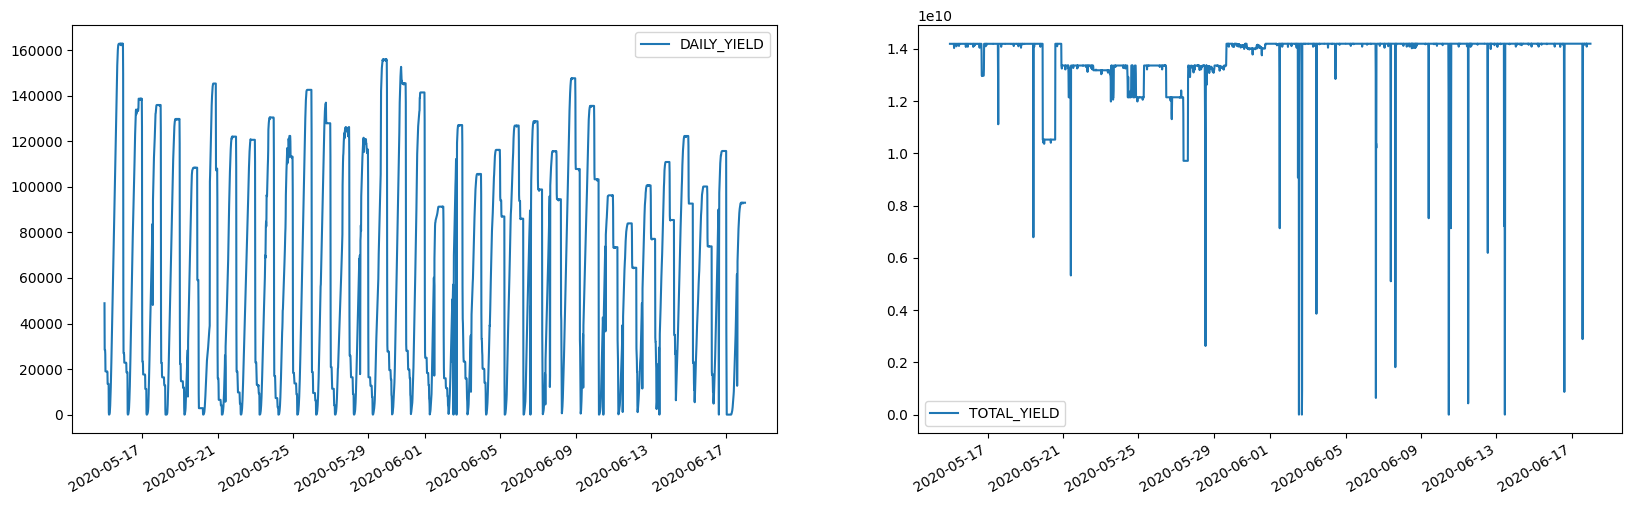

time: 813 ms (started: 2022-03-29 11:07:51 +02:00)


In [17]:
fig,ax = plt.subplots(ncols=2,nrows=1, dpi=100,figsize=(20,6))
gen_data_inv_sum = gen_data.groupby(gen_data.index).sum()
gen_data_inv_sum.plot(y = 'DAILY_YIELD', ax = ax[0])
gen_data_inv_sum.plot(y = 'TOTAL_YIELD', ax = ax[1]);

>Looking at the plots, we can see that there seem to exist a lot of erroneous data points, both for the daily yield as well as the total yield. The daily yield should as per definition be zero at 0:00, increase over each day according to each day´s AC-power production and then drop straight to zero again at 0:00. This is not at all what the plot describes for most days. The total yield looks also really bad. According to its definition, it should only ever increase, which it clearly does not. If we switch to plant 1, we see that the plots look a lot more as expected, but still contain a lot of errors. <br>
Let´s check, wether all the data is as erroneous. Following, you can find plots of the other parameters, plotted as point plots over a single day:

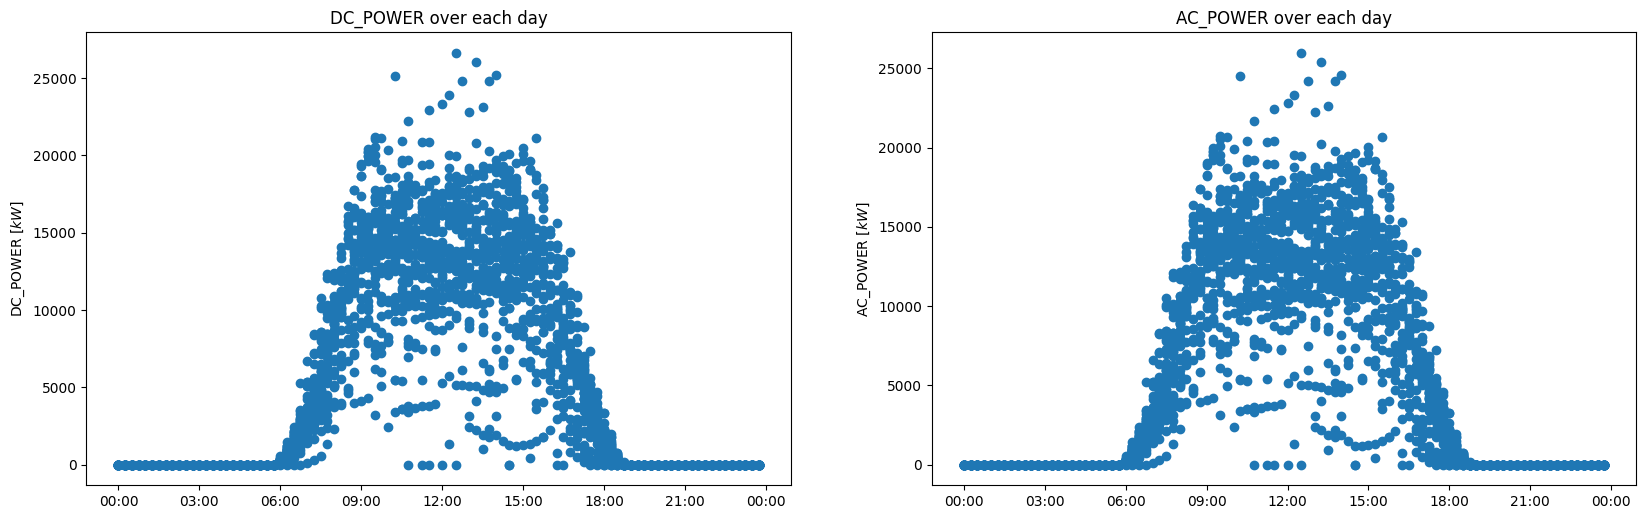

time: 1.11 s (started: 2022-03-29 11:07:52 +02:00)


In [18]:
def plot_ac_dc_power(df):
    fig,ax = plt.subplots(ncols=2,nrows=1, dpi=100,figsize=(20,6))
    for i, name in enumerate(['DC_POWER', 'AC_POWER']):
        ax[i].scatter([dt.datetime.combine(dt.date(2020,1,1), t) for t in df.index.time], df[name])
        ax[i].set_ylabel(f'{name} $[kW]$')
        ax[i].set_title(f"{name} over each day")
        ax[i].xaxis.set_major_formatter(hour_minutes)

plot_ac_dc_power(gen_data_inv_sum)

>Luckily, this looks a lot better that the daily and total yield. This are the key take-aways:
>- First, we see that the plots look very similar except for a small scaling factor (efficiency of the inverter). As we will see later on in the correlation plot, the relationship is in fact linear. Side note: for plant 1, the AC power is around 10.3 times smaller than the DC power, so the efficiency would be around 9.7%, which would be really bad. There seems to be a scaling error of one decimal point for the DC power, since all the other data (daily yield, total yield, ac power) is consistent. 
>- It makes sense that during nighttime hours (around 18:00 till 6:00) there is no power production.
>- The power production seems to rise to a certain amount in the morning, then stays pretty consistent over the day and falls in the evening (looking a little like a capped gaussian distribution)
>- There are some data points where the power production is zero over the day even though the irradiation isn´t (as can be seen below). These data points are only over one 15 minute interval so it seems unlikely, that this is due to repairs / other. Probably, these are errors in the data that need to be fixed.

In [19]:
#efficiency of the inverter:
np.mean(gen_data_inv_sum['AC_POWER']/gen_data_inv_sum['DC_POWER'])

0.9766987572557135

time: 0 ns (started: 2022-03-29 11:07:54 +02:00)


According to https://understandsolar.com/solar-inverter-efficiency/, this is actually top notch. Also, we find out that the inverters are probably from SMA Solar or SolarEdge.

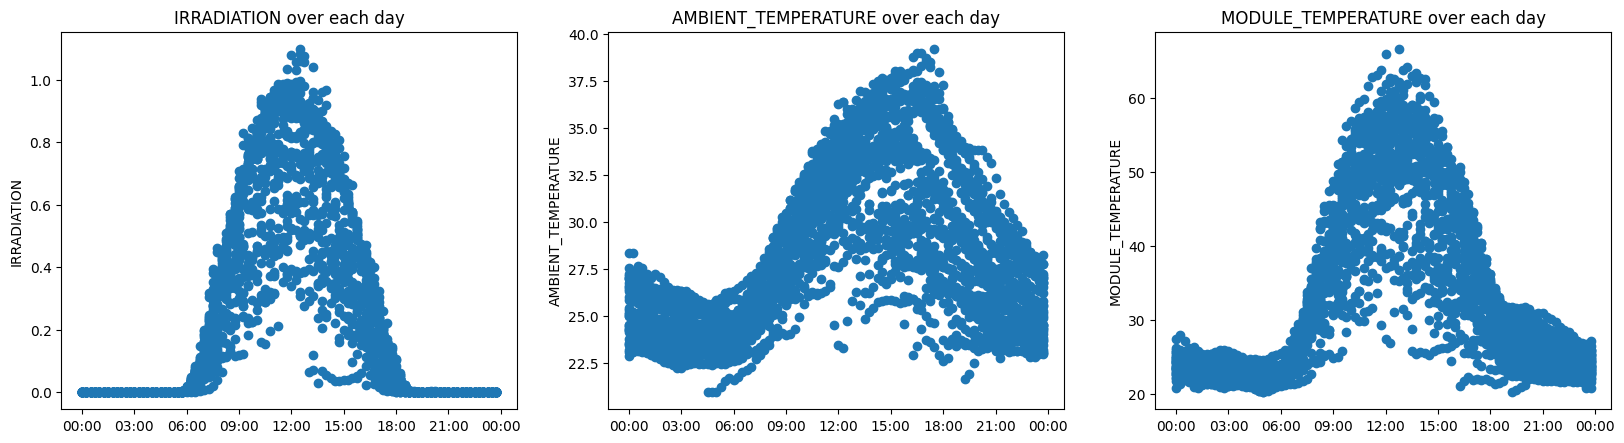

time: 860 ms (started: 2022-03-29 11:07:54 +02:00)


In [20]:
fig,ax = plt.subplots(ncols=3,nrows=1, dpi=100,figsize=(20,5))
for i, name in enumerate(['IRRADIATION','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE']):
    ax[i].scatter([dt.datetime.combine(dt.date(2020,1,1), t) for t in weather_data.index.time], weather_data[name])
    ax[i].set_ylabel(f'{name}')
    ax[i].xaxis.set_major_formatter(hour_minutes)
    ax[i].set_title(f"{name} over each day")

Take-aways:
- The weather sensor data looks really clean and consistent. We can see that the irradiation closely matches the power curves without being capped off, while the module temperature is a overlay of the irradiation and the ambient temperature. All this seems to confirm our physical understanding.
- If we tried to match the irradiation data to the sunrise and sunset data of that particular month and the ambient temperature to the climatic conditions, we could probably narrow down where the plant is stationed in india.
- This place gets really hot in summer

## 2.2 Data Preparation

>Now we gained all the insights we need to start correcting the erroneous data. The revealed issues will be dealt with as follows:
1. step: The total yield will be deleted as it currently has no identifiable surplus value and can easily be reconstructed from the AC power column which will be way easyer than correcting this mess.
2. step: We will try to use linear regression to correct all the zero power production values during daytime hours
3. step: There are several possible methods to deal with the missing inverter data.
- neglecting the parts of the data set where inverters are missing - waste of a lot of useful data
- interpolation of data for the missing inverters - not feasible since the time spans are by far too large
- summing up the power generation of all the inverters per time step while creating another column with the number of working inverters which would have the benefit that the model would take into account the possibility of inverters being out of service, however with only two occurances, the training data would be to limited to understand this relationship
- which leads us to the most feasible solution: summing up the power generation of all the inverters per time step and scaling the power production with the total  number of inverters, divided by the functioning inverters. Of course, we cannot assume that all the inverters produce an equal amount of power but the margin of error should be little enough.
4. step: We will create a correct list of the daily yield and replace the column in the data frame from the AC power column

### 2.2.1 Step 1: Dropping the total yield

In [21]:
gen_data = gen_data.drop(['TOTAL_YIELD'], axis = 1)
gen_data_inv_sum = gen_data_inv_sum.drop(['TOTAL_YIELD'], axis = 1)

time: 15 ms (started: 2022-03-29 11:07:55 +02:00)


### 2.2.2: let´s now create a function that enables us to create a corrected list of the daily yield

In [22]:
def create_daily_yield_list(dataframe, ac_power):
    day_list = []
    for i in list(pd.date_range(start=dataframe.index[0], end=dataframe.index[-1], freq='D')):
        day_list.append(i.strftime('%Y-%m-%d'))
    daily_yield = []
    for datetime in day_list:
        tmp = 0
        for idx, row in dataframe.loc[:,datetime].iterrows():
            tmp += row[ac_power]
            daily_yield.append(tmp)
    return daily_yield

gen_data_inv_sum.loc[:,'DAILY_YIELD'] = create_daily_yield_list(gen_data_inv_sum, 'AC_POWER')

time: 344 ms (started: 2022-03-29 11:07:55 +02:00)


>We see that the plot resembles the other plot closely with the errors being correctet. The new plot is scaled by a factor of 4. I can only guess how this factor comes into play. Most likely, the daily yield is in kWh, so the daily yield would be an integral of the power over the day. Since every quaterly average AC power has to be multiplied by $1/4 hr$ to achieve this, the factor would make sense.

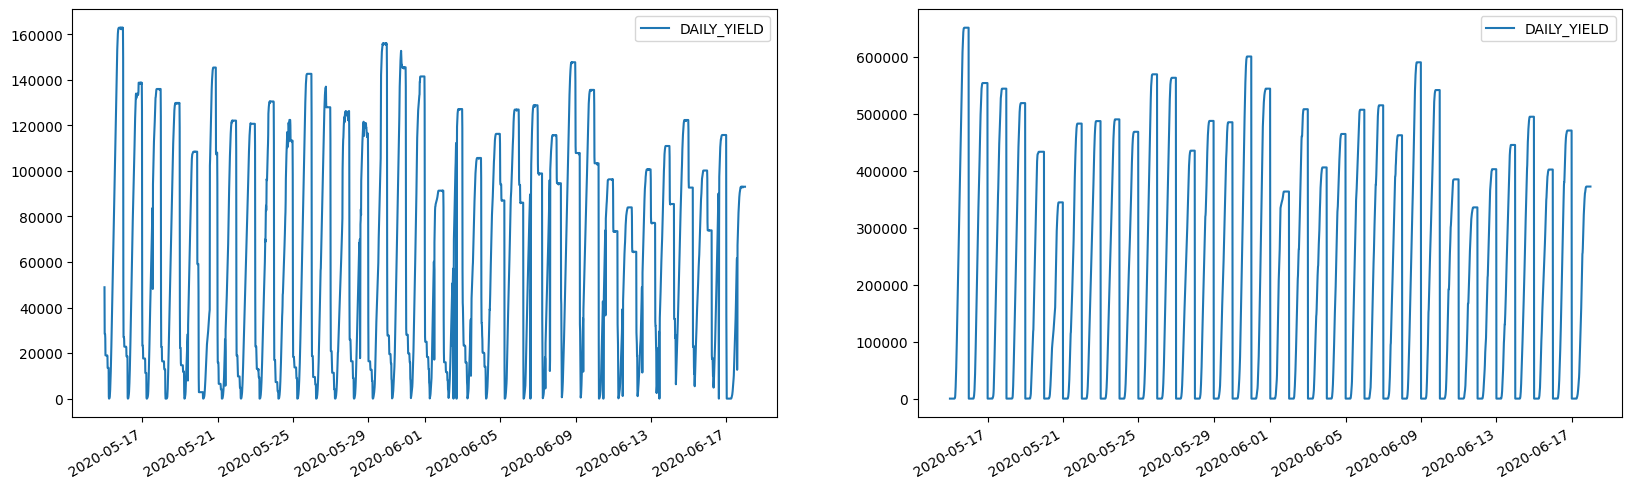

time: 703 ms (started: 2022-03-29 11:07:56 +02:00)


In [23]:
fig,ax = plt.subplots(ncols=2,nrows=1, dpi=100,figsize=(20,6))
fig.autofmt_xdate()
gen_data.groupby(gen_data.index).sum().plot(y = 'DAILY_YIELD', ax = ax[0])
gen_data_inv_sum.plot(y = 'DAILY_YIELD', ax = ax[1]);

Let´s corect this factor:

In [24]:
gen_data_inv_sum['DAILY_YIELD'] = gen_data_inv_sum['DAILY_YIELD'].apply(lambda x: x/4)
gen_data_inv_sum['DAILY_YIELD'].max()

162859.43416700777

time: 16 ms (started: 2022-03-29 11:07:57 +02:00)


### 2.2.3 Step 2: correcting all zero power production values: 

In [25]:
sunrise = 8
sunset = 17
date_time = pd.DatetimeIndex(gen_data_inv_sum.index.values)
day_ix = (date_time.hour >= sunrise) & (date_time.hour <= sunset)
daytime_zeros = day_ix & (gen_data_inv_sum['AC_POWER'] == 0)
gen_data_inv_sum[daytime_zeros]
for i in range(len(daytime_zeros)):
    if daytime_zeros[i]:
        gen_data_inv_sum.iloc[i,0:2] = None
print(f'number of null objects before interpolation: {gen_data_inv_sum.isnull().sum().sum()}')
gen_data_inv_sum = gen_data_inv_sum.interpolate(limit = 1, method ='linear', limit_direction ='both')
print(f'number of null objects after interpolation: {gen_data_inv_sum.isnull().sum().sum()}')

number of null objects before interpolation: 22
number of null objects after interpolation: 0
time: 31 ms (started: 2022-03-29 11:07:57 +02:00)


We can see that 22 daytime zero values were found and corrected via interpolation. The resulting plot can be seen below.

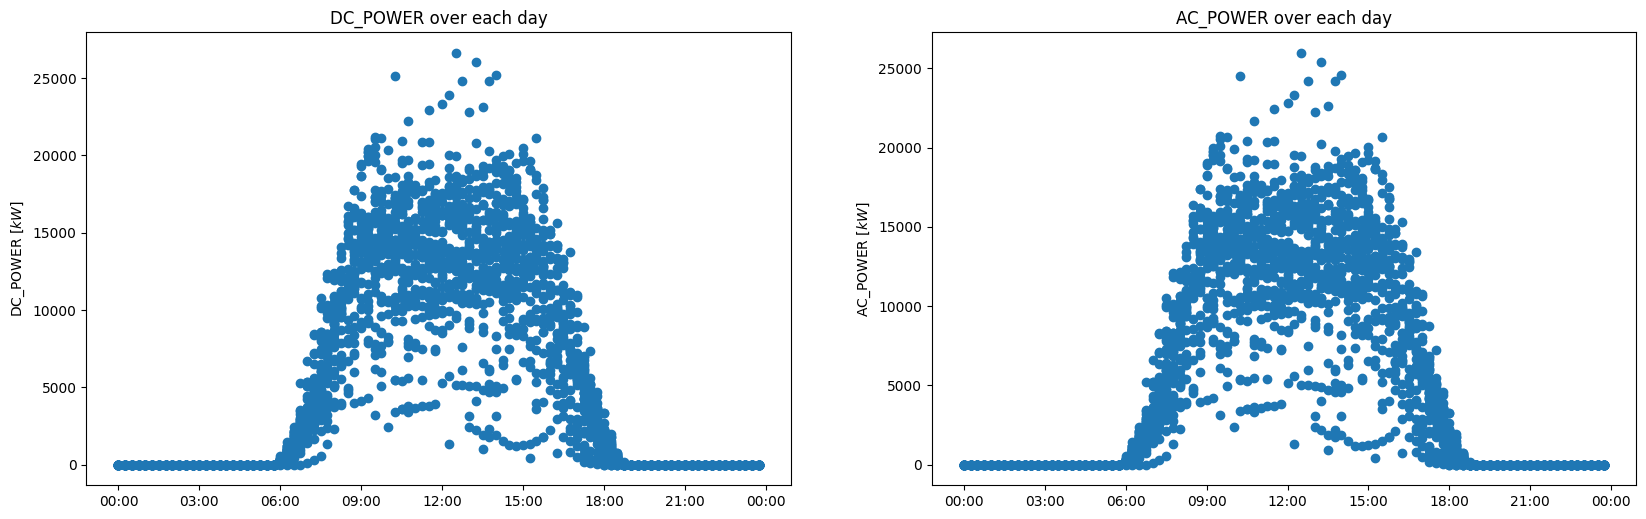

time: 672 ms (started: 2022-03-29 11:07:58 +02:00)


In [26]:
plot_ac_dc_power(gen_data_inv_sum)

### 2.2.4 Step 3: missing inverter data correction

since we know that the irradiation and the AC power are closely linked, let´s use this to check wether our correction makes sense

In [27]:
def plot_daily_yield_and_irradiation(dataframe):
    df_daily_mean = dataframe.groupby(dataframe.index.date).mean()
    fig,ax = plt.subplots(dpi=100,figsize=(10,6))

    plt.ioff()
    plt.grid()
    fig.autofmt_xdate()
    ax.plot(df_daily_mean['IRRADIATION'], label="irradiation", color="b")
    ax.set_ylabel("irradiation",color="b")
    ax2=ax.twinx()
    ax2.plot(df_daily_mean['AC_POWER'], color="g")
    for x, date in enumerate(list(set([d.date() for d in correction_list]))):
        if x!= 0:
            if x==1:
                ax2.plot(df_daily_mean['AC_POWER'][tmp:date], label="missing inverter data corrected", color="r")
            else:
                ax2.plot(df_daily_mean['AC_POWER'][tmp:date], color="r")
        tmp = date
    ax2.set_ylabel(f'AC power $[kW]$', color="g")
    ax2.legend(loc='upper right', shadow=False, fancybox=False, facecolor='white', edgecolor='black')
    ax2.set_title("average daily AC power and irradiation")

time: 0 ns (started: 2022-03-29 11:07:59 +02:00)


This is how the plots look prior to the correction. As predicted, we notice a close correlation for all but the tim span with the missing inverter data.

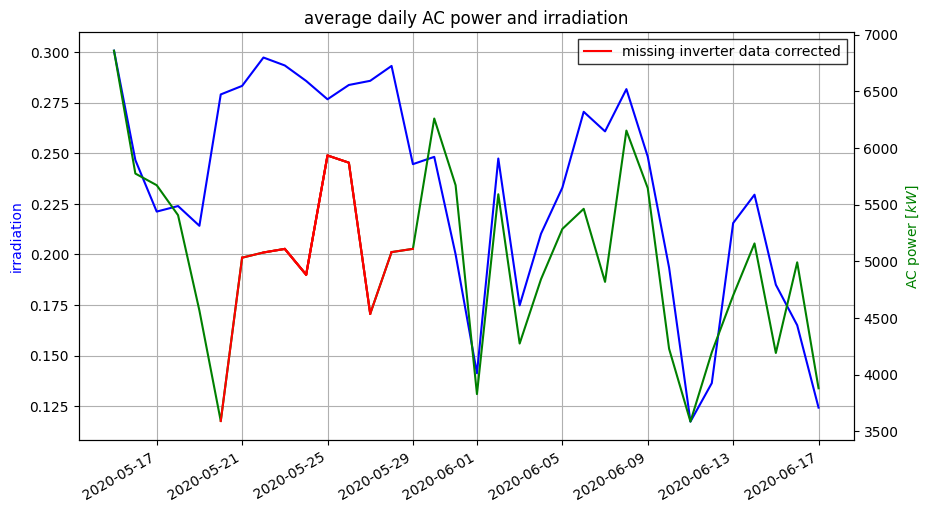

time: 688 ms (started: 2022-03-29 11:07:59 +02:00)


In [28]:
plot_daily_yield_and_irradiation(pd.merge(gen_data_inv_sum, weather_data, left_index=True, right_index=True))

In [29]:
tmp = pd.DataFrame(list(dt_gen_dict.items()), columns = ['DATE_TIME','NO_INVERTERS'])
tmp = (tmp.set_index(pd.DatetimeIndex(pd.to_datetime(tmp["DATE_TIME"]).values))).drop(['DATE_TIME'],axis=1)
corrected_df = pd.merge(gen_data_inv_sum, tmp, left_index=True, right_index=True)
print(corrected_df.loc[correction_list[0]])
for datetime in correction_list:
    corrected_df.loc[datetime] = corrected_df.loc[datetime]/dt_gen_dict[datetime]*22
print(corrected_df.loc[correction_list[0]])


DC_POWER             0.00000
AC_POWER             0.00000
DAILY_YIELD     108388.68066
NO_INVERTERS        12.00000
Name: 2020-05-19 22:15:00, dtype: float64
DC_POWER             0.00000
AC_POWER             0.00000
DAILY_YIELD     198712.58121
NO_INVERTERS        22.00000
Name: 2020-05-19 22:15:00, dtype: float64
time: 922 ms (started: 2022-03-29 11:08:00 +02:00)


From the above example and the plot below, we can see that the correction was successfull and as expected. The correction probably is not perfect but the correlation definitely looks better.

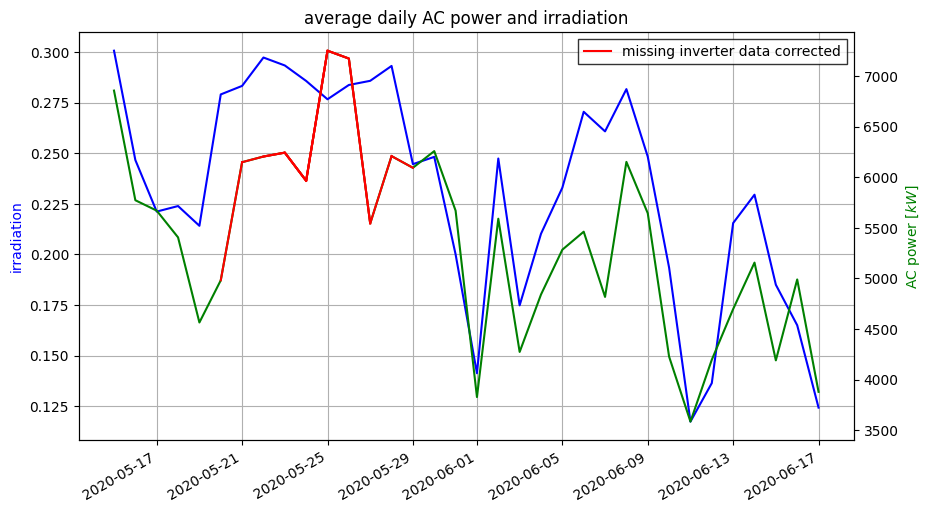

time: 688 ms (started: 2022-03-29 11:08:01 +02:00)


In [30]:
df_plant = pd.merge(corrected_df, weather_data, left_index=True, right_index=True).drop('NO_INVERTERS', axis = 1)
plot_daily_yield_and_irradiation(df_plant)


### 2.2.5 Step 4: Correcting daily yield to update changes made to AC power

In [31]:
df_plant.loc[:,'DAILY_YIELD'] = create_daily_yield_list(df_plant, 'AC_POWER')
df_plant.loc[:,'DAILY_YIELD'] = df_plant.loc[:,'DAILY_YIELD'].apply(lambda x: x/4)
df_plant.loc[:,'DAILY_YIELD'].max()

174037.18997492545

time: 328 ms (started: 2022-03-29 11:08:02 +02:00)


## 2.3 Correlations

In [32]:
correlationMatrix = pd.DataFrame(df_plant).corr() 
correlationMatrix.style.background_gradient(cmap='viridis').set_precision(2)

time: 140 ms (started: 2022-03-29 11:08:03 +02:00)


There´s a lot of insight to be gained here. 
- DC and AC power are perfectly correlated --> there is a linear relationship of the inverter input to output power with its slope being the efficiency of the inverter. 
- irradiation, ac power, dc power, module temperature and ambient temperature are all correlated closely which makes absolute sense. Broken down, the irradiation directly influences the dc power (minus shadowing and efficiency) and the ambient temperature, while the module temperature is influenced by the ambient temperature and the waste energy of the panels and itself infulences the efficiency
- the daily yield shows correlation with the temperature, not so much with the other values. This makes sense, since looking at the pairplots below, we can see a quadratic relationship.
> This is very valuable information. Our aim is to predict the power generated by the solar plant, so we could either predict the DC power, AC power or the daily yield. We now know that the DC power is the AC power multiplied by the efficiency of the inverter, which we also know. What is more, we can construct the daily yield from the ac power and vice versa. <br> This means that we are theoretically free of choice in what quantity we want to predict. However, if we use the weather data, it allows for smaller models if the underlying relationships are linear instead of quadratic. In those cases, it will be advantageous to predict the ac power in order to save ressources. With that, we also know that linear models should already do a pretty good job at predicting

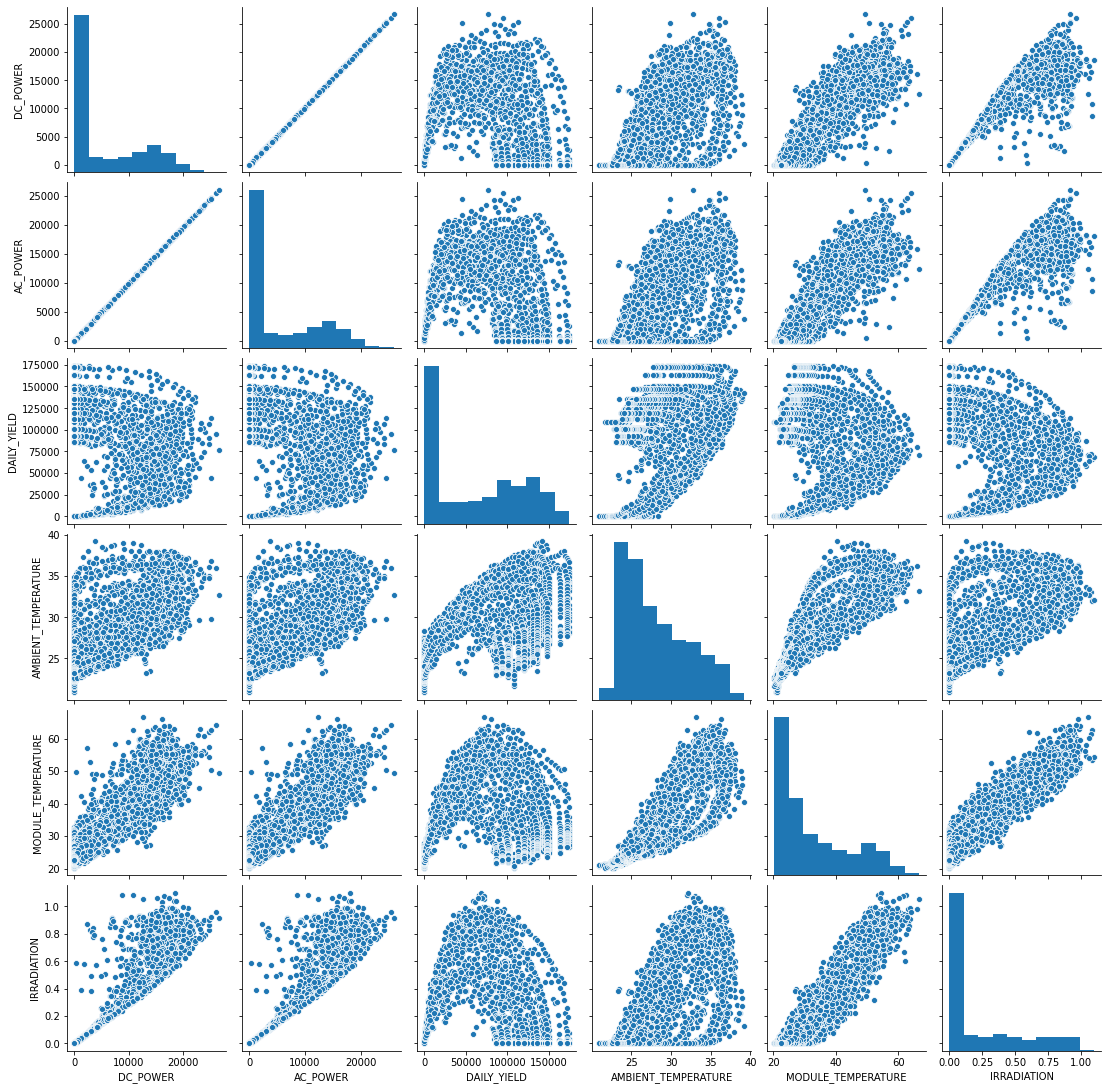

time: 6.25 s (started: 2022-03-29 11:08:04 +02:00)


In [33]:
sns.pairplot(df_plant)
plt.show()

# 3: Testing Phase I: Baseline Models

> since most weather models make hourly forecasts for the next three days at most, and since the reliability of the forecasts decreases significantly after these three days, we will try to predict the solar power generation for a similar period of time. We will do hourly predicitons as this matches the weather model predictions and will reduce model training at least by the factor of 4. For a three-day forecast, there is no need for a higher resolution than 1 hr time steps. For the SARIMAX model, the training time saved is even higher, since the seasonal component appears to have a significant influence on total model training time. Model training with a seasonal factor of 96 was awfully slow.

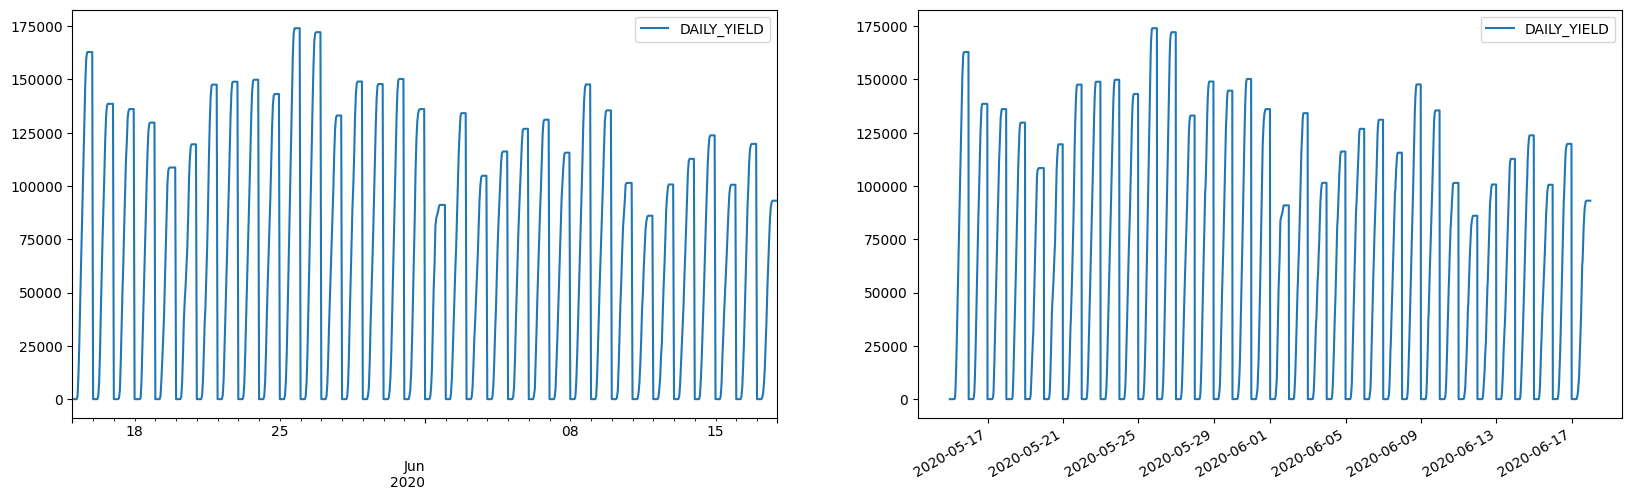

time: 875 ms (started: 2022-03-29 11:08:10 +02:00)


In [34]:
# grouping our data by hour and creating a new dataframe, checking wether it matches the old
df_plant_hour = df_plant.groupby(pd.Grouper(freq='H')).mean()
df_plant_hour.loc[:,'DAILY_YIELD'] = create_daily_yield_list(df_plant_hour, 'AC_POWER')
fig,ax = plt.subplots(ncols=2,nrows=1, dpi=100,figsize=(20,6))
fig.autofmt_xdate()
df_plant_hour.plot(y = 'DAILY_YIELD', ax = ax[0])
df_plant.plot(y = 'DAILY_YIELD', ax = ax[1]);

## 3.1 Autoregression

### 3.1.1 Seasonal Decomposition

Seasonal decomposition is unfortunately not possible due to the short time period of only 34 days

### 3.1.2 lag plot

>We will compare both possible forecasting values and see wether one of them is better suited to be predicted with the SARIMAX model without exogenous factors

<Figure size 432x288 with 0 Axes>

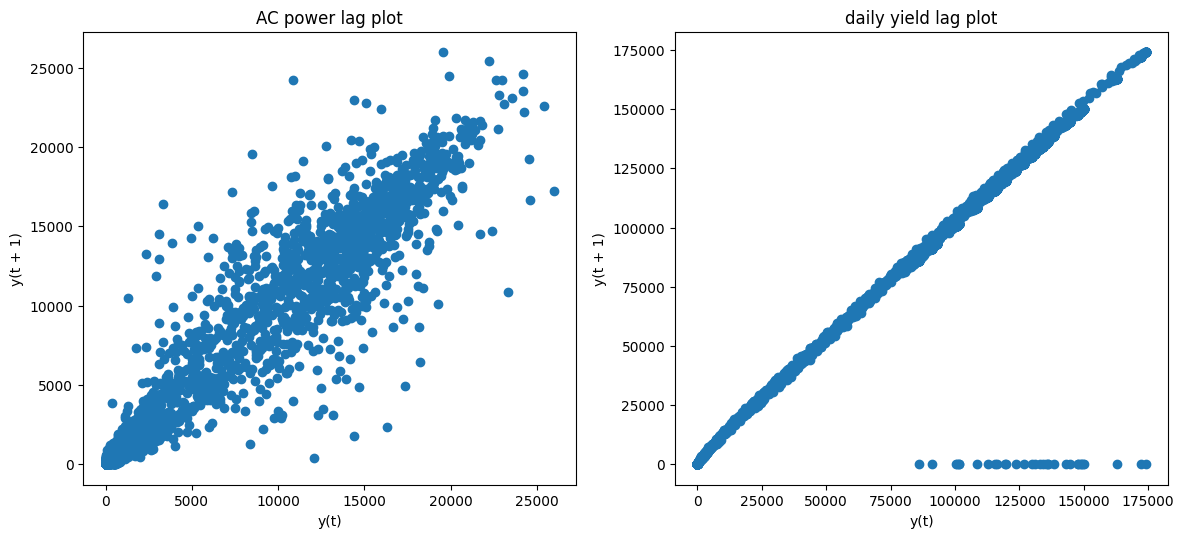

time: 641 ms (started: 2022-03-29 11:08:11 +02:00)


In [35]:
# Plotting the figure:
plt.figure()
fig,ax = plt.subplots(1,2, dpi=100,figsize=(14,6))
lag_plot(df_plant.loc[:,'AC_POWER'], ax = ax[0], lag=1)
lag_plot(df_plant.loc[:,'DAILY_YIELD'], ax = ax[1], lag=1)
ax[0].set_title('AC power lag plot')
ax[1].set_title('daily yield lag plot');

>We can see that both plots show a clear relationship between two following timesteps with seemingly randomly distributed outliers for the AC power plot. The daily yield lag plot shows a very distinct relationship. This makes sense since because of the incremental addition operation, $y(t+1)$ and $y(t)$ are quite similar. We also see that there are a lot of outliers on the $y(t)$ axis. The outliers can be explained by the fact that each day at 0:00, the daily_yield is set to zero again. This will probably be problematic for our SARIMAX model.

### 3.1.3 autocorrelation plot

<Figure size 432x288 with 0 Axes>

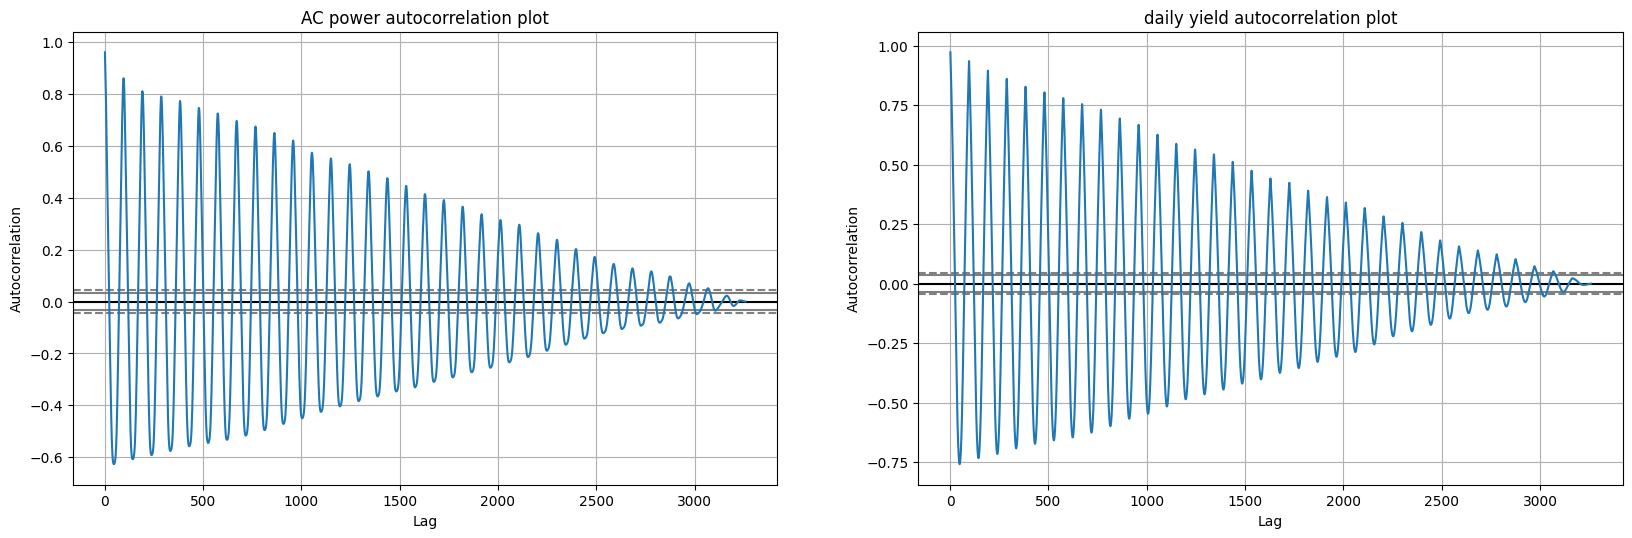

time: 719 ms (started: 2022-03-29 11:08:12 +02:00)


In [36]:
plt.figure()
fig, ax = plt.subplots(1,2, dpi=100,figsize=(20,6))
autocorrelation_plot(df_plant.loc[:,'AC_POWER'], ax = ax[0])
autocorrelation_plot(df_plant.loc[:,'DAILY_YIELD'], ax = ax[1])
ax[0].set_title(f'AC power autocorrelation plot')
ax[1].set_title(f'daily yield autocorrelation plot');

>We can see that there is correlation for a lot of the the previous time steps. Interestingly, both the plots look very similar, but since the daily yield is created from the AC power by summating over it, there inevitably is correlation.

>From now on, both the plots look very similar and since we already determined that the AC power is most likely better suited to be predicted, especially with exogenous factors, we will from now on only plot the AC power for the sake of readability.

<Figure size 432x288 with 0 Axes>

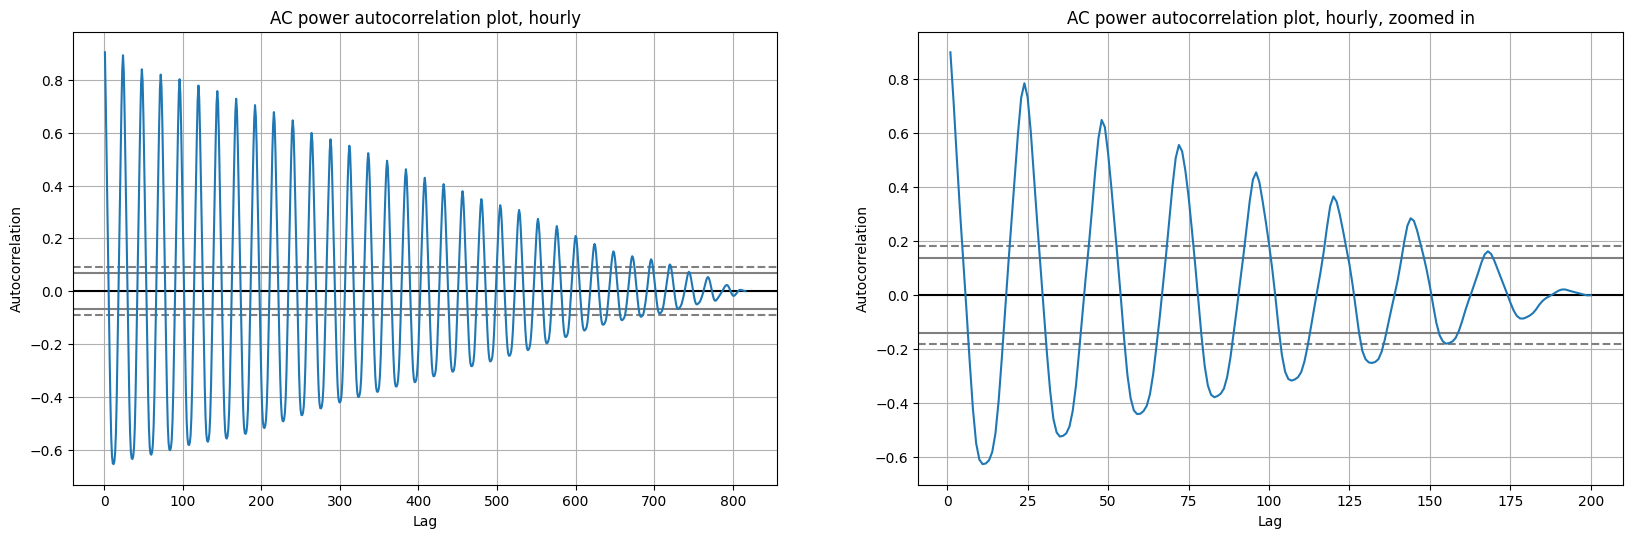

time: 625 ms (started: 2022-03-29 11:08:13 +02:00)


In [37]:
plt.figure()
fig,ax = plt.subplots(1,2, dpi=100,figsize=(20,6))
autocorrelation_plot(df_plant_hour.loc[:,'AC_POWER'], ax = ax[0])
autocorrelation_plot(df_plant_hour.loc[:,'AC_POWER'][0:200], ax = ax[1])
ax[0].set_title('AC power autocorrelation plot, hourly')
ax[1].set_title('AC power autocorrelation plot, hourly, zoomed in');

>If we group the dataframe so that every hour is added up and zoom in, we can see that every 24 hours, the positive correlation is high again, which again makes sense since at this point of time, the sun´s location is almost similar. For the ungrouped dataframe this means that every 24*4=96 time steps, positive correlation is high.

### 3.1.4 Auto Correlation Function

<Figure size 432x288 with 0 Axes>

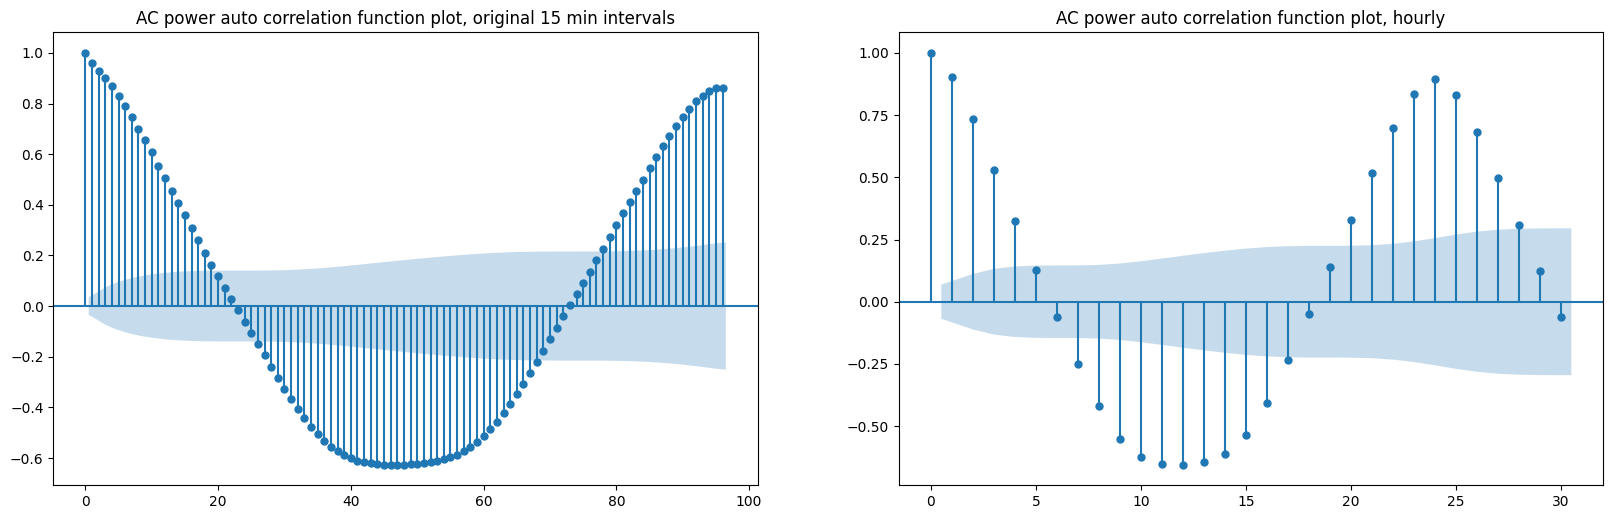

time: 578 ms (started: 2022-03-29 11:08:14 +02:00)


In [38]:
plt.figure()
fig,ax = plt.subplots(1,2, dpi=100,figsize=(20,6))
plot_acf(df_plant.loc[:,'AC_POWER'], ax = ax[0], lags = 24*4)
plot_acf(df_plant_hour.loc[:,'AC_POWER'], ax = ax[1])
ax[0].set_title('AC power auto correlation function plot, original 15 min intervals')
ax[1].set_title('AC power auto correlation function plot, hourly');

>We can see that for the MA parameters of the hourly AC power prediction, 5 lags are beneficial.

C:\Users\AEppl\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


<Figure size 432x288 with 0 Axes>

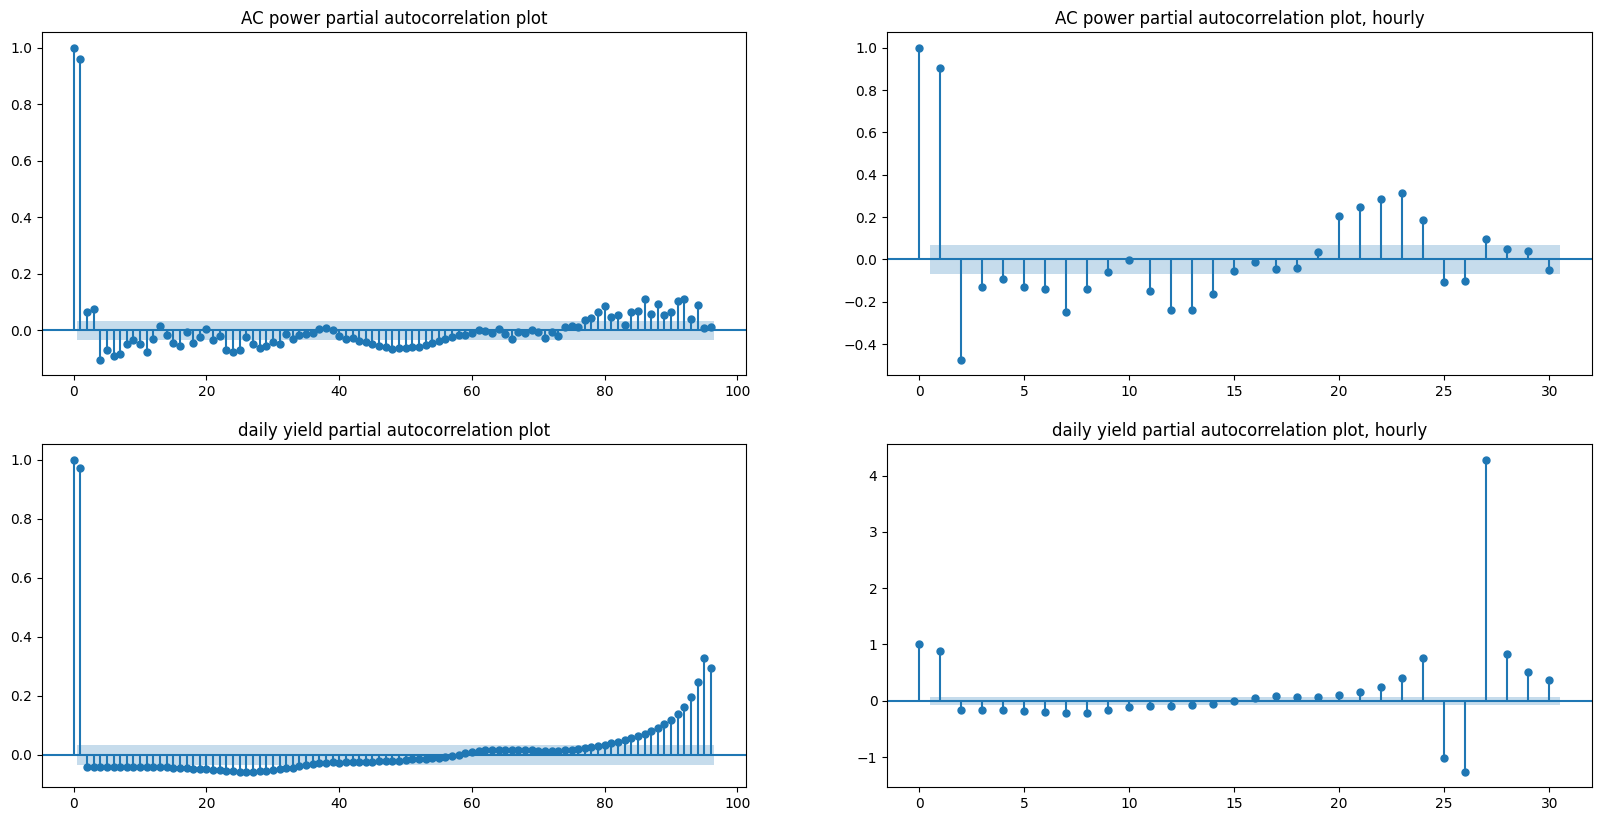

time: 1.22 s (started: 2022-03-29 11:08:15 +02:00)


In [39]:
plt.figure()
fig,ax = plt.subplots(2,2, dpi=100,figsize=(20,10))
plot_pacf(df_plant.loc[:,'AC_POWER'], ax = ax[0][0], lags = 24*4)
plot_pacf(df_plant_hour.loc[:,'AC_POWER'], ax = ax[0][1])
plot_pacf(df_plant.loc[:,'DAILY_YIELD'], ax = ax[1][0], lags = 24*4)
plot_pacf(df_plant_hour.loc[:,'DAILY_YIELD'], ax = ax[1][1])
ax[0][0].set_title('AC power partial autocorrelation plot')
ax[0][1].set_title('AC power partial autocorrelation plot, hourly')
ax[1][0].set_title('daily yield partial autocorrelation plot')
ax[1][1].set_title('daily yield partial autocorrelation plot, hourly');


>We learn that for the hourly AC power forcasting, we could possibly use an AR lag of 8. However, only the first two AR lags shows very high correlation, so another option would be to use an AR lag of two. 

For values higher than 24, the plot shows a weird behaviour, but this seems to have been caused by the underlying mathematical models. https://de.mathworks.com/matlabcentral/answers/122337-wrong-function-partial-autocorrelation-pacf-parcorr-greater-than-1-1

The following code snippet is taken from [medium](https://medium.com/swlh/temperature-forecasting-with-arima-model-in-python-427b2d3bcb53). With it, we want to check wether our data is stationary, which it is for values of $p<0.05$. This is important since any time series data that has to be modeled needs to be stationary. Stationary means that its statistical properties are more or less constant with time. This should probably be the case since each day follows a somewhat similar pattern to the days before.

In [40]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df_plant_hour.AC_POWER, autolag = 'AIC')
print("p-value : ", dftest[1])

p-value :  0.0005845008571331245
time: 78 ms (started: 2022-03-29 11:08:16 +02:00)


>We can observe from the p-value that our data is already stationary so we don´t have to transform it.

## 3.2 SARIMAX model

### 3.2.1 rescaling the data:

We will now scale the data in order for our models to function correctly. Since our data contains only values greater or equal to zero, it seems fitting to use a MINMAX scaler.

In [41]:
# scaler = pp.StandardScaler(copy=True)
scaler1 = pp.MinMaxScaler()
scaler2 = pp.MinMaxScaler()
forecast_variable = 'AC_POWER'
# drop unused columns (we cannot use the module temperature as we other than the irradiation or ambient temperature, we can´t predict this using weather forecasts)
drop_columns = ['DAILY_YIELD', 'DC_POWER', 'MODULE_TEMPERATURE']
#exogenous factors
exog = ['IRRADIATION', 'AMBIENT_TEMPERATURE']

def scale_df(df_to_scale):
    df_scaled = df_to_scale.copy(deep=True).drop(drop_columns, axis = 1)
    df_scaled.loc[:,forecast_variable] = scaler1.fit_transform(df_scaled.loc[:,forecast_variable].values.reshape(-1, 1))
    df_scaled.loc[:,exog] = scaler2.fit_transform(df_scaled[exog])
    return df_scaled

df_plant_scaled = scale_df(df_plant_hour)
df_plant_scaled.describe()

AC_POWER  AMBIENT_TEMPERATURE  IRRADIATION
count  816.000000           816.000000   816.000000
mean     0.227747             0.387921     0.240539
std      0.278977             0.233557     0.317577
min      0.000000             0.000000     0.000000
25%      0.000000             0.186853     0.000000
50%      0.037974             0.331002     0.030827
75%      0.489148             0.557816     0.471928
max      1.000000             1.000000     1.000000

time: 344 ms (started: 2022-03-29 11:08:17 +02:00)


### 3.2.2 Dividing into train and test dataset

Since we have got a relatively small time series of only 34 days, we will use the entire data set while using the last three days as testing data.

In [42]:
# Train-Test Split:
train_start_dt = '2020-05-15 0:00'
test_start_dt = '2020-06-15 0:00'
test_end_dt = '2020-06-17 23:45'
# trainin data: filtered copy
train = df_plant_scaled.copy(deep=True)[(df_plant_scaled.index >= train_start_dt) & (df_plant_scaled.index < test_start_dt)]
# test data: filtered copy
test = df_plant_scaled.copy(deep=True)[(df_plant_scaled.index >= test_start_dt) & (df_plant_scaled.index < test_end_dt)]
#let's see how it looks like:
print('Train data shape: ', train.shape)
print('Test data shape: ', test.shape)

Train data shape:  (744, 3)
Test data shape:  (72, 3)
time: 0 ns (started: 2022-03-29 11:08:18 +02:00)


With three days of test data and 31 days of training data, the test data is around 10% of the training data, which is a pretty common split factor.

### 3.2.3 Setting the hyperparameters

We now set the hyperparameters according to the values previously determined in [3.1](#31-autoregression) we will set the horizon to 24 as this doesn´t change the results noticably from a time horizon of only 4, however it decreases the training time significantly again. since the training has to be performed only thrice.

In [43]:
horizon = 24
#The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. 
# d must be an integer indicating the integration order of the process, while p and q may either 
# be an integers indicating the AR and MA orders (so that all lags up to those orders are included)
# or else iterables giving specific AR and / or MA lags to include. Default is an AR(1) model: (1,0,0).
order = (8, 1, 4)
#The (P,D,Q,s) order of the seasonal component of the model for:
# the AR parameters,  differences, MA parameters, and periodicity.
seasonal_order = (1, 1, 1, 24)
# forecast variable


time: 0 ns (started: 2022-03-29 11:08:18 +02:00)


In [44]:
#Copying the test DF:
test_shifted = test.copy().drop(exog, axis = 1)
#preparing the shifted test data:
for t in range(1, horizon):
    test_shifted.loc[:,f'{forecast_variable}+{str(t)}'] = test_shifted.loc[:,forecast_variable].shift(-t)
test_shifted = test_shifted.dropna()
test_shifted.head(2)

AC_POWER  AC_POWER+1  AC_POWER+2  AC_POWER+3  AC_POWER+4  \
2020-06-15 00:00:00       0.0         0.0         0.0         0.0         0.0   
2020-06-15 01:00:00       0.0         0.0         0.0         0.0         0.0   

                     AC_POWER+5  AC_POWER+6  AC_POWER+7  AC_POWER+8  \
2020-06-15 00:00:00    0.000000    0.057183    0.248394    0.548665   
2020-06-15 01:00:00    0.057183    0.248394    0.548665    0.403908   

                     AC_POWER+9  ...  AC_POWER+14  AC_POWER+15  AC_POWER+16  \
2020-06-15 00:00:00    0.403908  ...     0.455076     0.400312     0.333500   
2020-06-15 01:00:00    0.469428  ...     0.400312     0.333500     0.140949   

                     AC_POWER+17  AC_POWER+18  AC_POWER+19  AC_POWER+20  \
2020-06-15 00:00:00     0.140949     0.044209          0.0          0.0   
2020-06-15 01:00:00     0.044209     0.000000          0.0          0.0   

                     AC_POWER+21  AC_POWER+22  AC_POWER+23  
2020-06-15 00:00:00          0.0          0.0          0.0  
2020-06-15 01:00:00          0.0          0.0          0.0  

[2 rows x 24 columns]

time: 78 ms (started: 2022-03-29 11:08:18 +02:00)


In [45]:
#Warning update:
#----------------
#each optimization inside the profile likelihood generates a warning, 
#we turn off the warnings here to make the output clean in the below cell:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
#You can check the source code from here:
#https://www.statsmodels.org/0.8.0/_modules/statsmodels/base/model.html

time: 0 ns (started: 2022-03-29 11:08:19 +02:00)


We will try the prediction with and without exogenous factors and see, how beneficial it is to include them.

### 3.2.4 No exogenous Factors:

In [46]:
def sarimax(incl_exog = False):
  # Predictions on test data:
  training_window = 720

  test_ts = test_shifted
  #Creating the history
  history = [x for x in train[forecast_variable]]
  if incl_exog: exog_lst = train.loc[:,exog].values.tolist()
  #Filtering the training window: Uncomment the below line if you want.
  # history = history[(-training_window):]
  # exog_lst = exog_lst[(-training_window):]
  #Creating predictions to store the model outcomes:
  predictions = list()
  #Calling model: 
  #Horizon calculation list:
  for t in range(0,test_ts.shape[0],horizon):
    if incl_exog: model = SARIMAX(endog=history, exog = exog_lst, order=order, seasonal_order=seasonal_order)
    else: model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    #Model fitting:
    model_fit = model.fit()
    #Model predictions:
    if incl_exog: y_p = model_fit.forecast(steps = horizon, exog = test.loc[:,exog].values.tolist()[t:(t+horizon)])
    else: y_p = model_fit.forecast(steps = horizon)
    obs = list(test_ts.iloc[t])
  # moving the training window: here I add the prediction as in real life we would 
  # not know the true value! Here we will also save the predictions.
    for j in range(horizon):
      predictions.append(y_p[j])
      history.append(y_p[j])
      if incl_exog: exog_lst.append(test.loc[:,exog].values.tolist()[j+t])
    #Dropping the first horizon elements:
    for j in range(horizon):
      history.pop(0)
      if incl_exog: exog_lst.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', y_p, '\ntrue value =', obs)
  return predictions

time: 0 ns (started: 2022-03-29 11:08:19 +02:00)


In [47]:
predictions_no_exo = sarimax()

C:\Users\AEppl\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\AEppl\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


KeyboardInterrupt: 

time: 36.3 s (started: 2022-03-29 11:08:20 +02:00)


In [ ]:
# model_fit.save("SARIAX_1hr_8_1_4_1_1_1_24_horizon_6")

time: 0 ns (started: 2022-03-29 09:58:20 +02:00)


#### 3.2.4.1 Evaluating results

In [48]:
def create_results_df(predictions, y_test):
    # Evaluation of results:
    # We will combine the predictions with the actual load values in a DF. 
    eval_df = pd.DataFrame(predictions)
    eval_df.columns = ['prediction']
    #Updating the indices:
    eval_df=(eval_df.set_index(y_test.index))
    #Adding true values:
    eval_df['actual'] = y_test
    #Let's check:
    eval_df.info()

    #Back-transforming:
    eval_df[['prediction', 'actual']] = scaler1.inverse_transform(eval_df[['prediction', 'actual']])
    #creating daily yield columns
    eval_df['dy_prediction'] = create_daily_yield_list(eval_df, 'prediction')
    eval_df['dy_actual'] = create_daily_yield_list(eval_df, 'actual')
    return eval_df

time: 0 ns (started: 2022-03-29 11:09:07 +02:00)


In [49]:
results_no_exo = create_results_df(predictions_no_exo, test.loc[:,forecast_variable])

NameError: name 'predictions_no_exo' is not defined

time: 31 ms (started: 2022-03-29 11:09:08 +02:00)


In [50]:
#Plotting predictions vs actual values: 
def plot_pred_vs_actual(eval_df, title):
    fig, ax = plt.subplots(1,2, dpi=100,figsize=(20,6))
    for i in range(0,2):
        ax[i].plot(eval_df.iloc[:,i*2], 'k.-')
        ax[i].plot(eval_df.iloc[:,1+i*2], 'b.-', alpha=0.70)
        ax[i].legend([f'Predicted with {horizon} hr horizon', 'Actual'])
        ax[i].set_title(f"predicted with {title}")
        ax[i].set_xlabel('Time Index')
    ax[0].set_ylabel('AC Power')
    ax[1].set_ylabel('daily yield')

plot_pred_vs_actual(results_no_exo, 'SARIMAX without exogenous factors:')

NameError: name 'results_no_exo' is not defined

time: 31 ms (started: 2022-03-29 11:09:10 +02:00)


>We can see that the prediction succeds at predicting the general trend, however fails drastically in catching daily differences. The forecast for the following day looks exactly as the previous one.

In [51]:
#Visual comparisons of the predictions:
#---------------------------------------
#Visualization of the accuracy
def plot_accuracy(eval_df, title):
    fig, ax = plt.subplots(1,2, dpi=100,figsize=(12,5))
    for i, var in enumerate(["AC Power", "daily yield"]):
        lims = [min(eval_df.iloc[:,i*2].min(), eval_df.iloc[:,1+i*2].min()), max(eval_df.iloc[:,i*2].max(), eval_df.iloc[:,1+i*2].max())]
        ax[i].plot(lims, lims)
        ax[i].scatter(eval_df.iloc[:,1+i*2], eval_df.iloc[:,i*2], marker='o',alpha=0.8)
        ax[i].set_title(f"predicted with {title}")
        ax[i].set_xlabel(f'True {var}')
        ax[i].set_ylabel(f'predicted {var}')

plot_accuracy(results_no_exo, 'SARIMAX without exogenous factors:')

NameError: name 'results_no_exo' is not defined

time: 31 ms (started: 2022-03-29 11:09:12 +02:00)


In order to compare all the different models later on, we will create a dataframe and save the scores in it.

In [52]:
scores_all_models = pd.DataFrame(index=['AC power R² hourly','AC power MAE hourly','daily yield R² hourly','daily yield MAE hourly',
                                        'AC power R² 3 days','AC power MAE 3 days','daily yield R² 3 days','daily yield MAE 3 days'])

time: 16 ms (started: 2022-03-29 11:09:13 +02:00)


In [53]:
def print_eval_scores(eval_df, model, hourly = True):
    mae = [mean_absolute_error(eval_df.iloc[:,1], eval_df.iloc[:,0]), mean_absolute_error(eval_df.iloc[:,3], eval_df.iloc[:,2])]
    r2 = [r2_score(eval_df.iloc[:,1], eval_df.iloc[:,0]), r2_score(eval_df.iloc[:,3], eval_df.iloc[:,2])]
    if hourly: 
        scores_all_models.loc[:'daily yield MAE hourly',model] = [r2[0]*100, mae[0], r2[1]*100, mae[1]]
        print(model, 'hourly prediction')
    else: 
        scores_all_models.loc['AC power R² 3 days':,model] = [r2[0]*100, mae[0], r2[1]*100, mae[1]]
        print(model, 'three day prediction')
    print(f"AC power R2 score:      {r2[0]*100:8.3f}%    MAE:{mae[0]:9.2f}kW")
    print(f"daily yield R2 score:   {r2[1]*100:8.3f}%    MAE:{mae[1]:9.2f}kWh")
    
print_eval_scores(results_no_exo, 'SARIMAX w/o exog', hourly = False)

NameError: name 'results_no_exo' is not defined

time: 31 ms (started: 2022-03-29 11:09:14 +02:00)


In [54]:
scores_all_models

Empty DataFrame
Columns: []
Index: [AC power R² hourly, AC power MAE hourly, daily yield R² hourly, daily yield MAE hourly, AC power R² 3 days, AC power MAE 3 days, daily yield R² 3 days, daily yield MAE 3 days]

time: 0 ns (started: 2022-03-29 11:09:15 +02:00)


>Due to the fact that the daily trend is cought, the predictions show high R2 scores. It can also be seen that if the daily trend is cought, the daily yield shows a better R2 score.

### 3.2.5 Using exogenous Factors

In [ ]:
predictions_exo = sarimax(True)

2020-06-15 00:00:00
1 : predicted = [-4.46472455e-04  4.16141118e-03  5.10310524e-03  5.13257534e-04
  5.81682643e-03  8.58180122e-03  6.17191121e-02  2.45611371e-01
  5.54697682e-01  5.73355840e-01  5.63494649e-01  4.06075985e-01
  4.68919448e-01  2.73131532e-01  4.75177021e-01  4.36454829e-01
  3.29724125e-01  1.41757928e-01  2.49774010e-02 -9.09605449e-03
 -7.19642529e-03 -4.74560719e-03 -1.52721463e-03 -1.47621095e-03] 
true value = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05718273351072785, 0.24839415124157982, 0.5486646268916426, 0.40390771063601116, 0.46942782318717685, 0.37278718586271914, 0.41303841283447695, 0.3715779999350146, 0.45507557721010555, 0.4003123648905488, 0.33349996544329114, 0.1409487997555733, 0.04420930328372375, 0.0, 0.0, 0.0, 0.0, 0.0]
2020-06-16 00:00:00
25 : predicted = [-1.82424415e-03  1.36390757e-04  2.19858781e-03  1.28450298e-03
  3.19709320e-03  4.92036480e-03  5.76599159e-02  2.05062107e-01
  4.14613107e-01  4.61976997e-01  4.28347203e-01  4.49543669e-01
  

#### 3.2.5.1 Evaluating results

In [ ]:
results_exo = create_results_df(predictions_exo, test.loc[:,forecast_variable])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2020-06-15 00:00:00 to 2020-06-17 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  72 non-null     float64
 1   actual      72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB
time: 62 ms (started: 2022-03-29 10:02:50 +02:00)


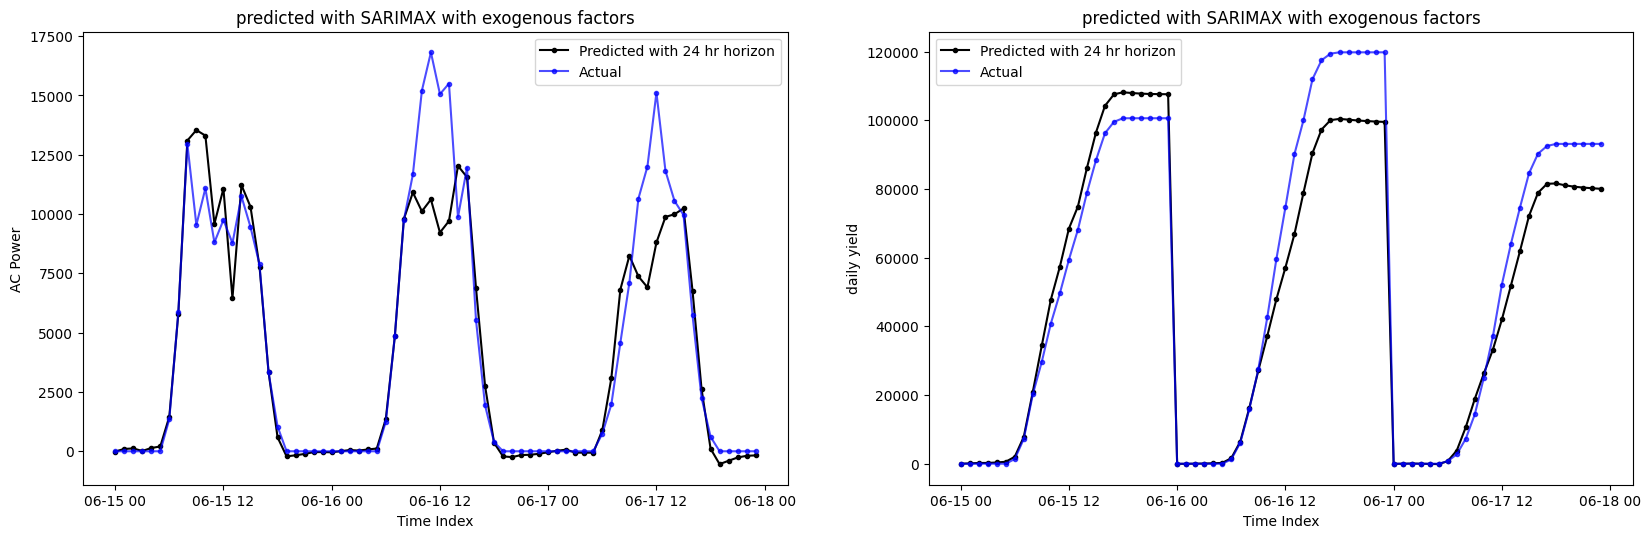

time: 906 ms (started: 2022-03-29 10:02:50 +02:00)


In [ ]:
plot_pred_vs_actual(results_exo, 'SARIMAX with exogenous factors')

We can see that the model with exogenous factors is drastically better at catching the values after sunrise / before sunset since this information is included in the exogenous factors. However, we can also see that the fluctuations over midday hours are not cought correctly.

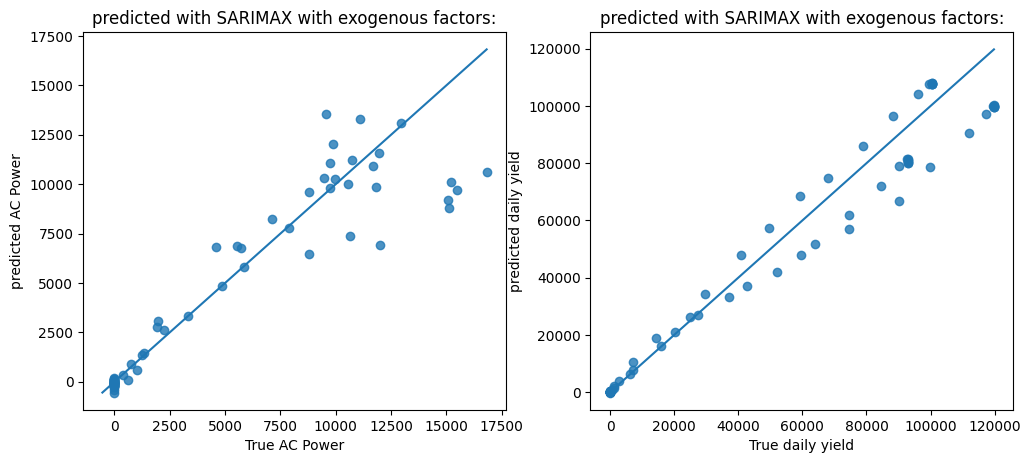

time: 797 ms (started: 2022-03-29 10:02:52 +02:00)


In [ ]:
plot_accuracy(results_exo, 'SARIMAX with exogenous factors:')

In [ ]:
print_eval_scores(results_exo, 'SARIMAX with exog', hourly = False)

SARIMAX with exog three day prediction
AC power R2 score:        87.255%    MAE:   968.36kW
daily yield R2 score:     94.899%    MAE:  7409.24kWh
time: 0 ns (started: 2022-03-29 10:02:53 +02:00)


We can see that including exogenous factors increases the general forecasting ability of our SARIMAX model which is probably due to its performance close to sunrise/sunset .

## 3.3 Baseline Model

Since our basic models are not overly calculatory expensive, we can switch to observing every quaterly time interval for the following models. If you want to see results even more quickly, switch to hourly predictions. However, please notice that the hyperparameter ranges are set for quaterhourly time intervals and need to be reset for hourly observations

In [55]:
observe_15_min_interval = True # set this to False in order to observe hourly intervals (saves a lot of time)
if observe_15_min_interval: df_plant_scaled = scale_df(df_plant)
else: df_plant_scaled = scale_df(df_plant_hour)
df_plant_scaled.describe()

AC_POWER  AMBIENT_TEMPERATURE  IRRADIATION
count  3259.000000          3259.000000  3259.000000
mean      0.207016             0.390751     0.211817
std       0.259427             0.222682     0.284586
min       0.000000             0.000000     0.000000
25%       0.000000             0.200652     0.000000
50%       0.021437             0.331092     0.017329
75%       0.442664             0.554539     0.399282
max       1.000000             1.000000     1.000000

time: 47 ms (started: 2022-03-29 11:09:26 +02:00)


>As a baseline model, we will do a linear regression simply based on the irradiation data which we consider to be possesing due to weather forecasts. The results should be already reasonably good as we know from our correlation matrix (see [2.3](#23-correlations)) that there is 93% correlation between the irradiation and the AC power.

### 3.3.1 Train Test Split

In [56]:
X_baseline = df_plant_scaled.loc[:,'IRRADIATION']
y_baseline = df_plant_scaled.loc[:,forecast_variable]

time: 0 ns (started: 2022-03-29 11:09:27 +02:00)


In [57]:
# Train-Test Split function with option to split into validation data also:
def train_test_split(X, y, test_start_dt, val_start_dt = None, val = False):
    train_start_dt = '2020-05-15 0:00'
    test_end_dt = '2020-06-18 0:00'
    
    if val: train_end_dt = val_start_dt
    else: train_end_dt = test_start_dt

    #Let's use the same notation: 
    X_train = X.copy()[(X.index >= train_start_dt)& (X.index < train_end_dt)]
    y_train = y.copy()[(y.index >= train_start_dt)& (y.index < train_end_dt)]
    
    if val:
        X_val = X.copy()[(X.index >= val_start_dt)& (X.index < test_start_dt)]
        y_val = y.copy()[(y.index >= val_start_dt)& (y.index < test_start_dt)]

    X_test =  X.copy()[(X.index >= test_start_dt) & (X.index < test_end_dt)]
    y_test =  y.copy()[(y.index >= test_start_dt) & (y.index < test_end_dt)]

    print('Train data shape: ', X_train.shape, y_train.shape)
    if val: print('Validation data shape: ', X_val.shape, y_val.shape)
    print('Test data shape: ', X_test.shape, y_test.shape)
    if val: return X_train, y_train, X_val, y_val, X_test, y_test
    else: return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split(X_baseline, y_baseline, test_start_dt = '2020-06-15 0:00')

#if doing single input linear regression, Scikit-learn requires reshape of input data
X_train = X_train.to_numpy().reshape(-1, 1)
X_test =  X_test.to_numpy().reshape(-1, 1)

Train data shape:  (2971,) (2971,)
Test data shape:  (288,) (288,)
time: 0 ns (started: 2022-03-29 11:09:27 +02:00)


In [58]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

time: 0 ns (started: 2022-03-29 11:09:28 +02:00)


### 3.3.2 Model Creation

In [59]:
#Model Predictions:
#------------------
def model_prediction_scores(model, X_val, y_val, model_name, val = True):

    y_train_pred = model.predict(X_train)
    scoreTraining = r2_score(y_train, y_train_pred)
    print('-----------------------------------')
    print(f'{model_name} Training R^2 Score: ', scoreTraining)
    print('-----------------------------------')
    y_val_pred = model.predict(X_val)
    scoreValidation = r2_score(y_val, y_val_pred)
    print('-----------------------------------')
    if val: print(f'{model_name} Validation R^2 Score: ', scoreValidation)
    else: print(f'{model_name} Test R^2 Score: ', scoreValidation)
    print('-----------------------------------')

model_prediction_scores(model_lr, X_test, y_test, "linear regression", val = False)

-----------------------------------
linear regression Training R^2 Score:  0.8699676319214511
-----------------------------------
-----------------------------------
linear regression Test R^2 Score:  0.8233666746163089
-----------------------------------
time: 15 ms (started: 2022-03-29 11:09:28 +02:00)


In [60]:
predictions = model_lr.predict(X_test)
results_lr = create_results_df(predictions, y_test)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2020-06-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  288 non-null    float64
 1   actual      288 non-null    float64
dtypes: float64(2)
memory usage: 6.8 KB
time: 78 ms (started: 2022-03-29 11:09:29 +02:00)


### 3.3.3 Results

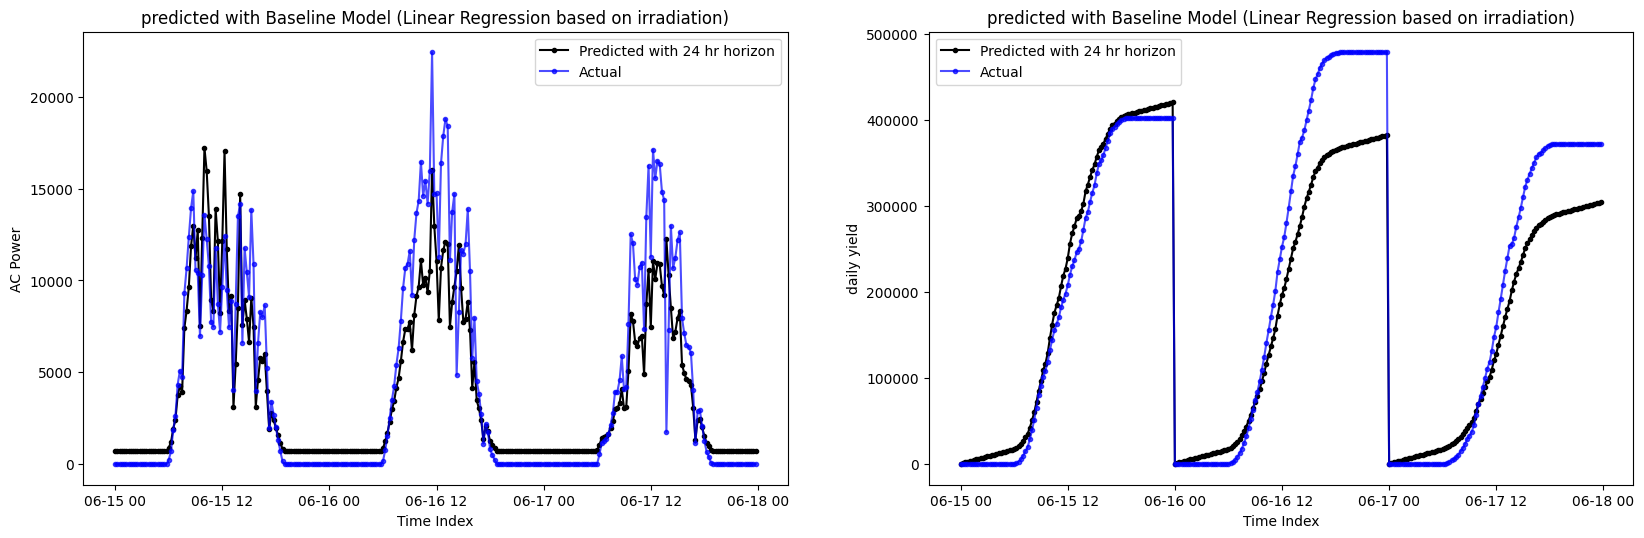

time: 750 ms (started: 2022-03-29 11:09:30 +02:00)


In [61]:
plot_pred_vs_actual(results_lr, 'Baseline Model (Linear Regression based on irradiation)')

>We can see that our baseline model is very good at catching the general trend of the AC power since it´s largely depending on the Irradiation, however, it seems to lack some sort of scaling.

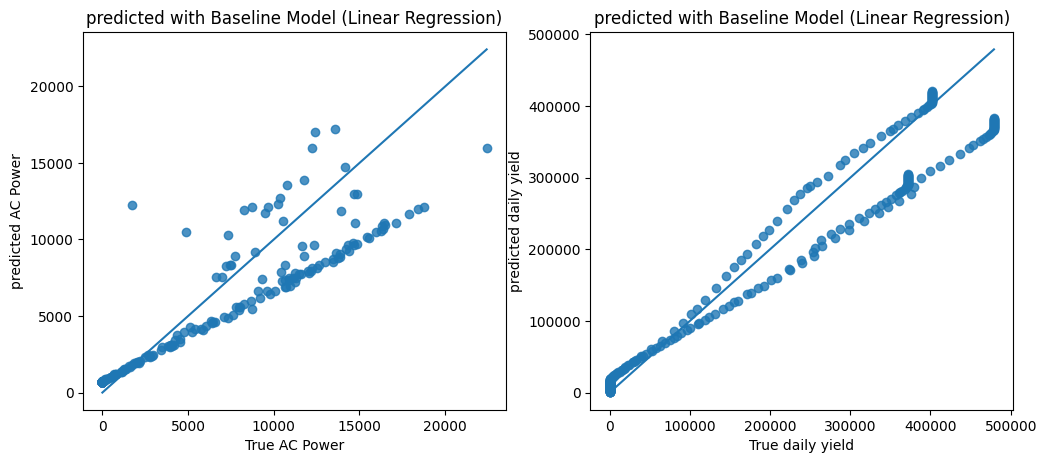

time: 563 ms (started: 2022-03-29 11:09:31 +02:00)


In [62]:
plot_accuracy(results_lr, 'Baseline Model (Linear Regression)')

In [63]:
print_eval_scores(results_lr, 'Baseline Model', hourly = False)

Baseline Model three day prediction
AC power R2 score:        82.337%    MAE:  1629.42kW
daily yield R2 score:     91.889%    MAE: 37391.20kWh
time: 15 ms (started: 2022-03-29 11:09:32 +02:00)


## 3.4 SVM

### 3.4.1 Feature Creation

In [64]:
# function that allows to add features such as minimum values and standard deviation to the dataframe:
def adding_features(df, time_interval):
    #Defining the time intervall (rolling window width in hours):
    hours = time_interval
    #Calling Rolling:
    window = df[[forecast_variable]].rolling(window=hours + 1)
    if observe_15_min_interval: hours = hours/4
    # Additional features: mean, median, std, min, max
    new_df = pd.concat([window.mean(), window.median(), window.std(), window.min(), window.max()], axis=1)
    new_df.columns = [f'mean_{hours}h', f'median_{hours}h', f'std_{hours}h', f'min_{hours}h', f'max_{hours}h']
    new_df = pd.merge(df, new_df, left_index=True, right_index=True)
    return new_df

time: 0 ns (started: 2022-03-29 11:09:34 +02:00)


We will add both features for the near term as well as for the last 12, 24, 36 and 48 hours in order to capture the daily seasonality trends of the data. I found out that little features were necessary to get good predictions for the following time step, however at least as many features were necessary to achive good predictions for the 72 hour forecasts.
>The function is constructed so that the feature list t_intv can be changed without requiring further code changes.

In [65]:
t_intv = [1,2,4,12,24,48]
if observe_15_min_interval: t_intv = [4,8,16,48,96,192] #[4,8,16,32,48,96,144,192]
def create_feature_df(dataframe):
    new_df = adding_features(dataframe, t_intv[0])
    for t in t_intv[1:]:
        new_df = adding_features(new_df, t)
    new_df = new_df.dropna() 
    return new_df

feature_df = create_feature_df(df_plant_scaled)
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3067 entries, 2020-05-17 00:15:00 to 2020-06-17 23:45:00
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AC_POWER             3067 non-null   float64
 1   AMBIENT_TEMPERATURE  3067 non-null   float64
 2   IRRADIATION          3067 non-null   float64
 3   mean_1.0h            3067 non-null   float64
 4   median_1.0h          3067 non-null   float64
 5   std_1.0h             3067 non-null   float64
 6   min_1.0h             3067 non-null   float64
 7   max_1.0h             3067 non-null   float64
 8   mean_2.0h            3067 non-null   float64
 9   median_2.0h          3067 non-null   float64
 10  std_2.0h             3067 non-null   float64
 11  min_2.0h             3067 non-null   float64
 12  max_2.0h             3067 non-null   float64
 13  mean_4.0h            3067 non-null   float64
 14  median_4.0h          3067 non-null   float64
 15  st

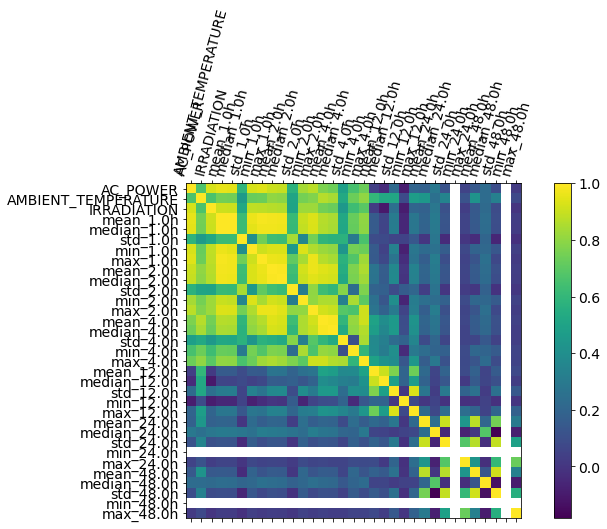

time: 1.86 s (started: 2022-03-29 11:09:35 +02:00)


In [66]:
#Correlation Matrix
correlationMatrix = pd.DataFrame(feature_df).corr() 

f = plt.figure(figsize=(12, 6))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(feature_df.shape[1]), feature_df.columns, fontsize=14, rotation=75)
plt.yticks(range(feature_df.shape[1]), feature_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

The correlation matrix is very conclusive as it reveals that the short term features in general show drastically higher correlation than the ones covering 12 hours or more. However, there is still correlation which we will need to catch the seasonality effects, other than through irradiation and ambient temperature. We also see that some features like the standard deviation shows less correlation, while the median shows higher correlation for the longer time periods. For values higher than daytime hours (~13h), the minimum value is missing since it is zero for the entire dataframe. However, this could still prove to be a valuable info (e.g. for decision trees / neural networks)

### 3.4.2 Train Val Test Split

We will now create a sliding window over 48 hours

In [67]:
#finding the indices as integers for time substraction below:
start = 0
end = len(feature_df)
#setting windows width:
horizon = 72
window = horizon
if observe_15_min_interval: window = horizon * 4
#emply datalist
dataX = []
dataY = []
column_names = []
for i in range(start,end-window):

    # Slice a window of features
    dataX.append((feature_df.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(feature_df[forecast_variable].iloc[i+window] )

for j in range(1,window+1):
    column_names.append([f"{x}_t_{j}" for x in feature_df.columns])

column_names = itertools.chain(*column_names)
dataX = pd.DataFrame(np.vstack(dataX),index=feature_df.iloc[start+window:end].index)
dataX.columns = column_names
dataY =pd.Series(dataY,index=feature_df.iloc[start+window:end].index)
dataY.column = [forecast_variable]

time: 875 ms (started: 2022-03-29 11:09:39 +02:00)


In [68]:
dataX.head(2)

AC_POWER_t_1  AMBIENT_TEMPERATURE_t_1  IRRADIATION_t_1  \
2020-05-20 00:30:00           0.0                 0.285455              0.0   
2020-05-20 00:45:00           0.0                 0.270908              0.0   

                     mean_1.0h_t_1  median_1.0h_t_1  std_1.0h_t_1  \
2020-05-20 00:30:00   3.657448e-16              0.0  6.803338e-09   
2020-05-20 00:45:00   3.657448e-16              0.0  6.803338e-09   

                     min_1.0h_t_1  max_1.0h_t_1  mean_2.0h_t_1  \
2020-05-20 00:30:00           0.0           0.0            0.0   
2020-05-20 00:45:00           0.0           0.0            0.0   

                     median_2.0h_t_1  ...  mean_24.0h_t_288  \
2020-05-20 00:30:00              0.0  ...          0.172099   
2020-05-20 00:45:00              0.0  ...          0.172099   

                     median_24.0h_t_288  std_24.0h_t_288  min_24.0h_t_288  \
2020-05-20 00:30:00            0.000635         0.243153              0.0   
2020-05-20 00:45:00            0.000635         0.243153              0.0   

                     max_24.0h_t_288  mean_48.0h_t_288  median_48.0h_t_288  \
2020-05-20 00:30:00         0.685632          0.190006                 0.0   
2020-05-20 00:45:00         0.685632          0.190006                 0.0   

                     std_48.0h_t_288  min_48.0h_t_288  max_48.0h_t_288  
2020-05-20 00:30:00         0.256808              0.0         0.685632  
2020-05-20 00:45:00         0.256808              0.0         0.685632  

[2 rows x 9504 columns]

time: 47 ms (started: 2022-03-29 11:09:40 +02:00)


In [69]:
dataY.head(2)

2020-05-20 00:30:00    0.0
2020-05-20 00:45:00    0.0
dtype: float64

time: 16 ms (started: 2022-03-29 11:09:41 +02:00)


Finally, we split our data into training, validation and test data set with the last three days as a test set and the three days before that as a validation set. We will already require a validation set since I decided to directly include the model selection in this step. The way we created our data we could also split up the training and validation data sets randomly and perform cross validation. However, as this took significantly more time and didn´t lead to noticable improvements, the "classic" time series approach for splitting into training, validation and test set was used.

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = train_test_split(dataX, dataY, val_start_dt = '2020-6-12 0:00', test_start_dt = '2020-06-15 0:00', val = True)

Train data shape:  (2203, 9504) (2203,)
Validation data shape:  (288, 9504) (288,)
Test data shape:  (288, 9504) (288,)
time: 1.73 s (started: 2022-03-29 10:46:55 +02:00)


### 3.4.3 Model Creation

we will first create the model with its default parameters and see how well it performs on the validation data, then perform the hyperparameter optimization and check how much it improved.

In [ ]:
# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
#Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
#against simplicity of the decision surface. 
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1   # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)
 

time: 0 ns (started: 2022-03-29 10:03:07 +02:00)


In [ ]:
# Model Training:
model_svr = svr
#Fitting the model according to given data:
model_svr.fit(X_train, y_train)

SVR(kernel='linear', tol=1e-05)

time: 6.75 s (started: 2022-03-29 10:03:07 +02:00)


In [ ]:
model_prediction_scores(model_svr, X_val, y_val, "SVM Regression")

-----------------------------------
SVM Regression Training R^2 Score:  0.9444962723918442
-----------------------------------
-----------------------------------
SVM Regression Validation R^2 Score:  0.771322614229067
-----------------------------------
time: 6.42 s (started: 2022-03-29 10:03:14 +02:00)


>We can observe that the model seems to overfit the training data since the training R² score is significantly better than the validation score. This should leave us plenty of room for improvement regarding optimization.

### 3.4.4 Hyperparameter optimization

>We will use optuna for the parameter optimization as this is a quite recently developed library that uses pruning (automatically stopping unpromising trials at the early stages) and therefore takes very little time for successfull optimization. Furthermore, it possesses some useful visualization libraries.
Inspiration was taken from here:
https://towardsdatascience.com/how-to-make-your-model-awesome-with-optuna-b56d490368af

In order to use optuna, we must first define an objective function that contains all the necessary information (parameter range, model and error function). The limits of the hyperparameters were narrowed down to reasonable ranges in several iterative steps.

In [ ]:
def objective_svr(n_trials):
    params = {
        # in a previous iteration step it was found out that the rbf kernel produces the best results. Therefore, it was set to default in order to tune gamma
        'kernel' : 'rbf', # n_trials.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]), #
        'gamma' : n_trials.suggest_float('gamma', 1e-4, 0.1, log = True), # 'scale',
        'C': n_trials.suggest_float('C', 1e-2, 10, log = True),
        'epsilon' : n_trials.suggest_float('epsilon', 1e-3, 1, log = True),
        'tol': 1e-5,
        'max_iter': 500
    }
    model = SVR()
    model.set_params(**params)
    regressor = model.fit(X_train, y_train)
    y_pred = regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    return mse

time: 0 ns (started: 2022-03-29 10:03:21 +02:00)


What´s really handy about optuna is that we can set a time limit / define the number of trials, which we will set to 50.

In [ ]:
study_svr = op.create_study(direction="minimize")
study_svr.optimize(objective_svr, n_trials=100)
print(f"Optimized MSE: {study_svr.best_value:.4f}")
print("Best params:")
for key, value in study_svr.best_params.items():
    print(f"\t{key}: {value}")

[I 2022-03-29 10:03:21,914] A new study created in memory with name: no-name-43c20b60-732f-459d-a915-0ea6437a742a
C:\Users\AEppl\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
[I 2022-03-29 10:03:41,192] Trial 0 finished with value: 0.04910241095640065 and parameters: {'gamma': 0.08289962650439078, 'C': 0.027789450727145053, 'epsilon': 0.007380170306423202}. Best is trial 0 with value: 0.04910241095640065.
C:\Users\AEppl\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
[I 2022-03-29 10:03:54,339] Trial 1 finished with value: 0.03281515702030144 and parameters: {'gamma

Optimized MSE: 0.0056
Best params:
	gamma: 0.000933146573376786
	C: 0.6015439953903707
	epsilon: 0.01042026344303606
time: 22min 7s (started: 2022-03-29 10:03:21 +02:00)


<ipython-input-82-24f79c47bcc3>:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_svr);


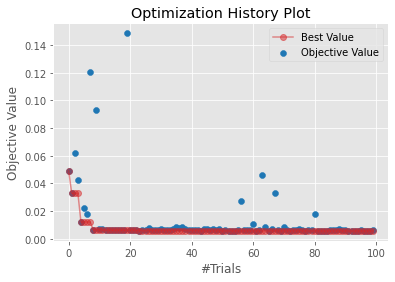

time: 813 ms (started: 2022-03-29 10:25:30 +02:00)


In [ ]:
# svm_opt_results_df = study_svr.trials_dataframe()
plot_optimization_history(study_svr);

The following plot shows the importance of the hyperparameters on the result (kind of like in a design of experiments study). We can see that the epsilon value plays the highest influence on the result.

In [ ]:
fig = op.visualization.plot_param_importances(study_svr)
fig.show()

time: 7.2 s (started: 2022-03-29 10:25:31 +02:00)


For the following plot, you can use the interactive feature of the plot in order to zoom. We can directly see that epsilon values higher than 0.5 and C values higher than 3 lead to huge errors. If we zoom in on the y-axis, we can also see that the the errors rise for small values of C and epsilon. We can therefore see that we picked reasonable ranges for the hyperparameter values. We can also see that rbf overal has the best performance.

In [ ]:
fig = op.visualization.plot_slice(study_svr)
fig.show()

time: 1.34 s (started: 2022-03-29 10:25:38 +02:00)


>Let´s now see how well our tuned model performs on the validation data. We can see significant improvements in the validation error. We can also see that the error gap was significantly reduced (overfit is less of a problem now).

In [ ]:
model_svr.set_params(**study_svr.best_params, kernel = 'rbf')
model_svr.fit(X_train, y_train)
model_prediction_scores(model_svr, X_val, y_val, 'tuned Support Vector Regression')

-----------------------------------
tuned Support Vector Regression Training R^2 Score:  0.9449613593104067
-----------------------------------
-----------------------------------
tuned Support Vector Regression Validation R^2 Score:  0.875420305878645
-----------------------------------
time: 55.1 s (started: 2022-03-29 10:25:41 +02:00)


### 3.4.5 Results hourly forecast

>We now use the combined training and validation data to train the best parameter model in order to evaluate it on the test data:

In [ ]:
# Train-Test Split:
X_train, y_train, X_test, y_test = train_test_split(dataX, dataY, test_start_dt = '2020-06-15 0:00')
model_svr.fit(X_train, y_train)

Train data shape:  (2491, 9504) (2491,)
Test data shape:  (288, 9504) (288,)


SVR(C=0.6015439953903707, epsilon=0.01042026344303606,
    gamma=0.000933146573376786, tol=1e-05)

time: 22.8 s (started: 2022-03-29 10:26:36 +02:00)


Best values so far: SVR(C=0.5015923028438802, epsilon=0.04135159370098645, gamma=0.0015781386040614827, kernel = 'svr, tol=1e-05)

In [ ]:
predictions = model_svr.predict(X_test)
results_svm_hourly = create_results_df(predictions, y_test)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2020-06-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  288 non-null    float64
 1   actual      288 non-null    float64
dtypes: float64(2)
memory usage: 6.8 KB
time: 7.58 s (started: 2022-03-29 10:27:00 +02:00)


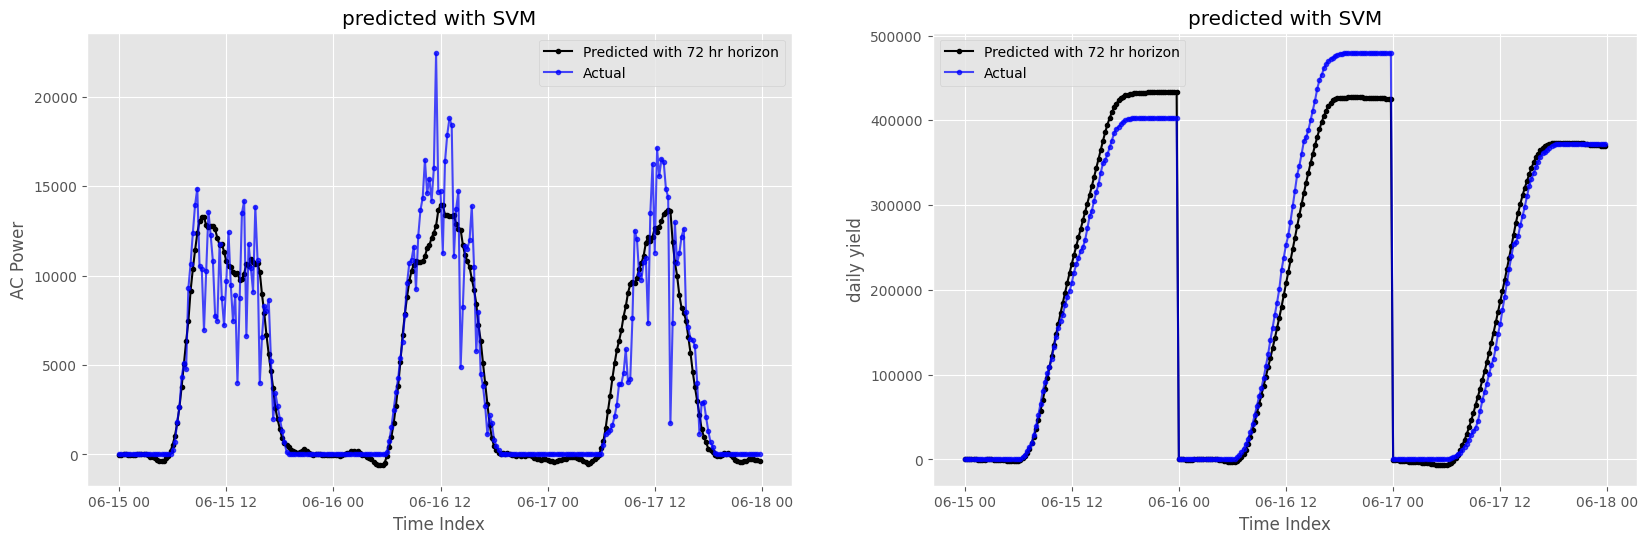

time: 2.42 s (started: 2022-03-29 10:27:08 +02:00)


In [ ]:
plot_pred_vs_actual(results_svm_hourly, 'SVM')

We can see that the model is very good at catching the daily overall trend, however it does not manage to catch the quaterhourly fluctuations very well. This allows the model to forecast the daily yield very accurately though.

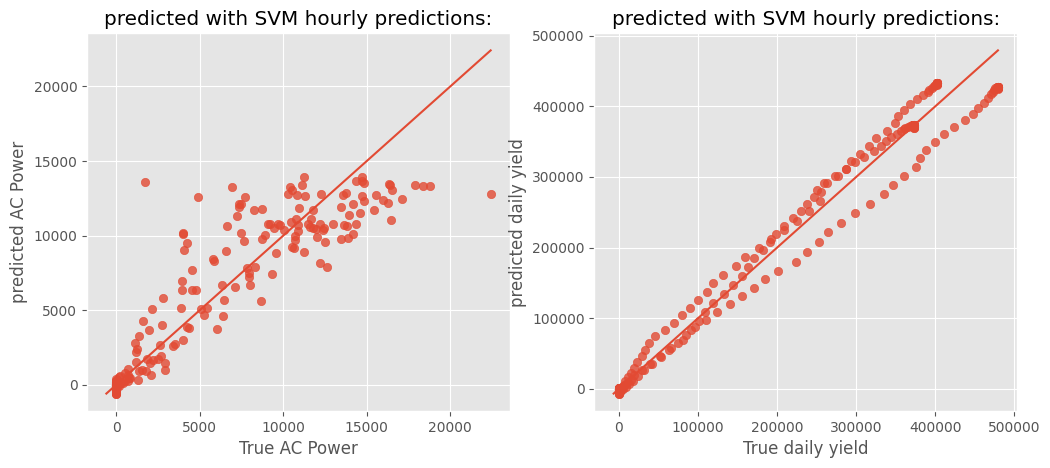

time: 922 ms (started: 2022-03-29 10:27:11 +02:00)


In [ ]:
plot_accuracy(results_svm_hourly, 'SVM hourly predictions:')

In [ ]:
print_eval_scores(results_svm_hourly, 'SVM', hourly = True)

SVM hourly prediction
AC power R2 score:        86.397%    MAE:  1186.98kW
daily yield R2 score:     97.891%    MAE: 18622.71kWh
time: 15 ms (started: 2022-03-29 10:27:13 +02:00)


### 3.4.6 Results Three Days Forecast

We will now create a time frame possessing the weather info in order to do predictions for the next three days.

In [ ]:
# we need the start time to be earlier according to the longest feature in order to allow us to update the features later on.
feature_start_time = pd.Timestamp(y_test.index[0]) - DateOffset(hours=t_intv[-1])
test_weather_info = df_plant_scaled.copy(deep = True)[(df_plant_scaled.index >= feature_start_time) & (df_plant_scaled.index < test_start_dt)]
tmp = df_plant_scaled.copy(deep = True)[(df_plant_scaled.index >= test_start_dt) & (df_plant_scaled.index < test_end_dt)]
# we will pretend to not know the AC power values while possesing knowledge of the ambient tmeperature and irradiation through weather forecasts,
# therefore we will fill the AC power column with null values, starting at the first value we want to predict
tmp[forecast_variable] = None
test_weather_info = test_weather_info.append(tmp)
test_weather_info

AC_POWER  AMBIENT_TEMPERATURE  IRRADIATION
2020-06-07 00:00:00       0.0             0.188787          0.0
2020-06-07 00:15:00       0.0             0.189141          0.0
2020-06-07 00:30:00       0.0             0.187325          0.0
2020-06-07 00:45:00       0.0             0.189115          0.0
2020-06-07 01:00:00       0.0             0.184207          0.0
...                       ...                  ...          ...
2020-06-17 22:30:00       NaN             0.147250          0.0
2020-06-17 22:45:00       NaN             0.140868          0.0
2020-06-17 23:00:00       NaN             0.139254          0.0
2020-06-17 23:15:00       NaN             0.132262          0.0
2020-06-17 23:30:00       NaN             0.128770          0.0

[1055 rows x 3 columns]

time: 157 ms (started: 2022-03-29 10:27:13 +02:00)


This is a function that we can reuse for all the baseline models, it updates our AC_power column from the test_weather_info df with every prediction loop, in order to update our feature dataframe to work for the next prediction

In [ ]:
def pred_three_days(model, test_weather_info, n_features, np_able = True):
    # series to store the predicted values
    test_weather = test_weather_info.copy(deep = True)
    y_predicted =pd.Series(index=y_test.index, dtype='float64')
    if np_able: X_test_last = X_test.copy(deep = True).iloc[0:1].to_numpy()
    else: X_test_last = X_test.copy(deep = True).iloc[0:1]
    for case_index in y_test.index:
    # predicting with trained input model
        prediction = model.predict(X_test_last).flatten()[0]
        # print(prediction)
        y_predicted.update(pd.Series(prediction,index=[case_index]))
        test_weather.loc[case_index, forecast_variable] = prediction
        update_next_hour = create_feature_df(test_weather)
        
        test_weather = test_weather.iloc[1:, :]
        # updating X_test_last with new values
        for i in range (X_test_last.shape[1]-n_features):
            if np_able: X_test_last[0][i] = X_test_last[0][i+n_features]
            else: X_test_last.iloc[0,i] = X_test_last.iloc[0,i+n_features]
        for i in range(update_next_hour.shape[1]):   
            if np_able: X_test_last[0][X_test_last.shape[1]-n_features+i] = update_next_hour.iloc[0,i]
            else: X_test_last.iloc[0,X_test_last.shape[1]-n_features+i] = update_next_hour.iloc[0,i]
    return y_predicted

predictions = pred_three_days(model_svr, test_weather_info, feature_df.shape[1])
results_svm = create_results_df(predictions, y_test.copy(deep=True))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2020-06-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  288 non-null    float64
 1   actual      288 non-null    float64
dtypes: float64(2)
memory usage: 6.8 KB
time: 31.8 s (started: 2022-03-29 10:27:14 +02:00)


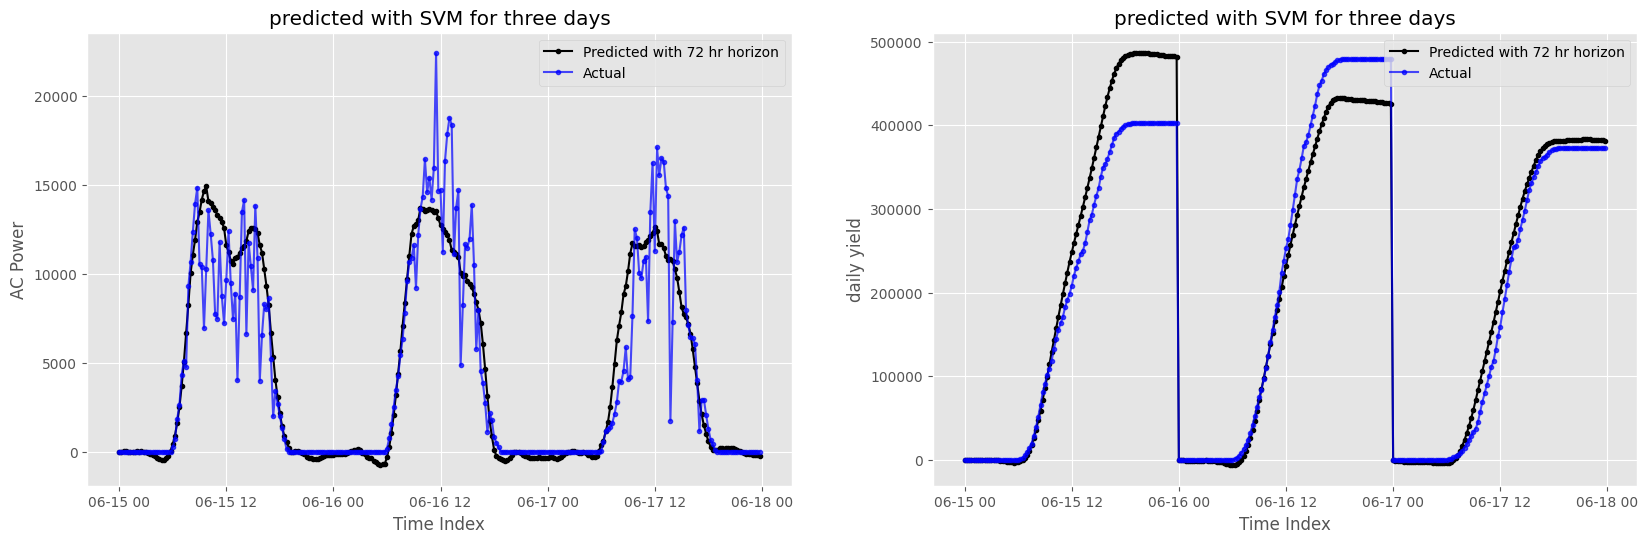

time: 1.28 s (started: 2022-03-29 10:27:46 +02:00)


In [ ]:
plot_pred_vs_actual(results_svm, 'SVM for three days')

we can see that our model is surprisingly good at predicting the next three days and that the results are very similar to the hourly predictions, only slightly less accurate. This can possibly be contributed to the model heavily depending on the "weather forecast" data.

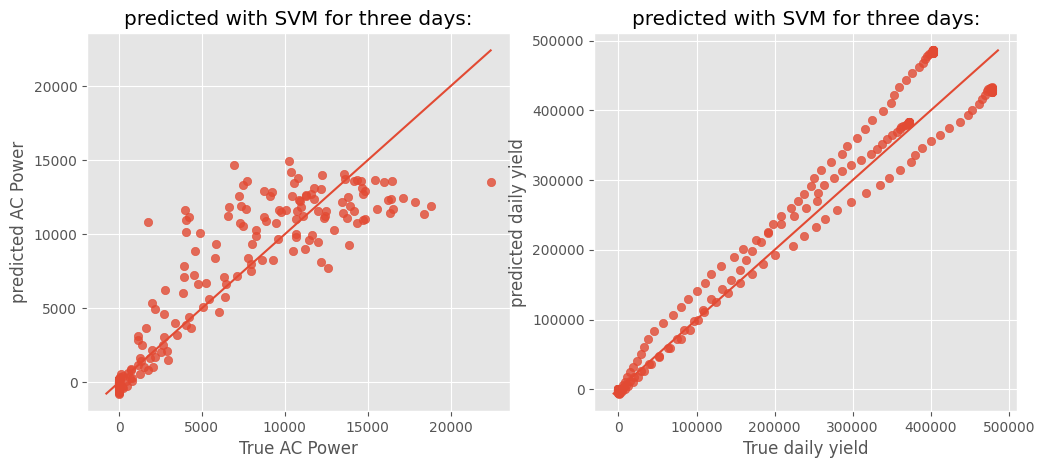

time: 688 ms (started: 2022-03-29 10:27:48 +02:00)


In [ ]:
plot_accuracy(results_svm, 'SVM for three days:')

In [ ]:
print_eval_scores(results_svm, 'SVM', hourly = False)

SVM three day prediction
AC power R2 score:        84.518%    MAE:  1272.39kW
daily yield R2 score:     95.812%    MAE: 25955.66kWh
time: 15 ms (started: 2022-03-29 10:27:49 +02:00)


## 3.5 Bayesian Ridge Regression

We need to do the train test val split again since our training data currently consists of the combined training and validation data

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = train_test_split(dataX, dataY, val_start_dt = '2020-6-12 0:00', test_start_dt = '2020-06-15 0:00', val = True)

Train data shape:  (2203, 9504) (2203,)
Validation data shape:  (288, 9504) (288,)
Test data shape:  (288, 9504) (288,)
time: 1.84 s (started: 2022-03-29 10:27:50 +02:00)


### 3.5.1 Model Creation

In [ ]:
# Hyperparameters:
n_iter = 500 # default=300 Maximum number of iterations. Should be greater than or equal to 1.
tol = 1e-5 # default=1e-3 Stop the algorithm if w has converged.
alpha_1 = 1e-6 # default=1e-6 Hyper-parameter : shape parameter for the Gamma distribution prior over the alpha parameter.
alpha_2 = 1e-6 # default=1e-6 Hyper-parameter : inverse scale parameter (rate parameter) for the Gamma distribution prior over the alpha parameter.
lambda_1 = 1e-6 # default=1e-6 Hyper-parameter : shape parameter for the Gamma distribution prior over the lambda parameter.
lambda_2 = 1e-6 # default=1e-6 Hyper-parameter : inverse scale parameter (rate parameter) for the Gamma distribution prior over the lambda parameter.

brr = BayesianRidge(n_iter = n_iter, tol = tol, alpha_1 = alpha_1, alpha_2 = alpha_2, lambda_1 = lambda_1, lambda_2 = lambda_2, compute_score=True)

model_brr = brr.fit(X_train, y_train)
model_prediction_scores(model_brr, X_val, y_val, 'Bayesian Ridge Regression')

-----------------------------------
Bayesian Ridge Regression Training R^2 Score:  0.9761751432401644
-----------------------------------
-----------------------------------
Bayesian Ridge Regression Validation R^2 Score:  0.8337057898001121
-----------------------------------
time: 51.2 s (started: 2022-03-29 10:27:52 +02:00)


>We can see that the default brr model does a better job at predicting the validation data than the support vector regression. Let´s see how well it performs after tuning its hyperparameters:

### 3.5.2 Hyperparameter optimization

In [ ]:
def objective_brr(n_trials):
    params = {
        'alpha_1' : n_trials.suggest_float('alpha_1', 1e-3, 20, log = True),
        'alpha_2' : n_trials.suggest_float('alpha_2', 5, 20, log = True),
        'lambda_1' : n_trials.suggest_float('lambda_1', 1e-8, 10, log = True),
        'lambda_2' : n_trials.suggest_float('lambda_2', 1e-8, 0.01, log = True),
        'tol': 1e-5,
        'n_iter': 500
    }
    model = BayesianRidge()
    model.set_params(**params)
    regressor = model.fit(X_train, y_train)
    y_pred = regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    return mse

time: 15 ms (started: 2022-03-29 10:28:43 +02:00)


In [ ]:
study_brr = op.create_study(direction="minimize")
study_brr.optimize(objective_brr, n_trials=100)
print(f"Optimized MSE: {study_brr.best_value:.4f}")
print("Best params:")
for key, value in study_brr.best_params.items():
    print(f"\t{key}: {value}")

[I 2022-03-29 10:28:44,447] A new study created in memory with name: no-name-0cb999d5-cf78-41ac-b4ad-400d2054487c
[I 2022-03-29 10:29:29,387] Trial 0 finished with value: 0.006069517820146018 and parameters: {'alpha_1': 0.5456560266681754, 'alpha_2': 12.16226810392913, 'lambda_1': 0.0017330469213521155, 'lambda_2': 0.00040741114470728933}. Best is trial 0 with value: 0.006069517820146018.
[I 2022-03-29 10:30:07,395] Trial 1 finished with value: 0.006074238010470056 and parameters: {'alpha_1': 0.05396654872172844, 'alpha_2': 12.828302697626029, 'lambda_1': 0.00946310411831845, 'lambda_2': 0.00021982668316486347}. Best is trial 0 with value: 0.006069517820146018.


KeyboardInterrupt: 

time: 2min 6s (started: 2022-03-29 10:28:44 +02:00)


<ipython-input-101-a1826ab50b02>:2: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



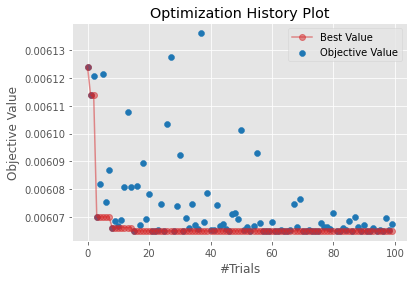

time: 687 ms (started: 2022-03-28 23:52:47 +02:00)


In [ ]:
# svm_opt_results_df = study_svr.trials_dataframe()
plot_optimization_history(study_brr);

In [ ]:
fig = op.visualization.plot_param_importances(study_brr)
fig.show()

time: 3.47 s (started: 2022-03-28 23:52:48 +02:00)


we can see that the hyperparameter alpha_2 has by far the highest influence and resembles a quadratic function with a minimum by 10. This is especially interesting since this is not influenced by the other parameters.

In [ ]:
fig = op.visualization.plot_slice(study_brr)
fig.show()

time: 140 ms (started: 2022-03-28 23:52:52 +02:00)


In [ ]:
model_brr.set_params(**study_brr.best_params)
model_brr.fit(X_train, y_train)
model_prediction_scores(model_brr, X_val, y_val, 'tuned Bayesian Ridge Regression')

-----------------------------------
tuned Bayesian Ridge Regression Training R^2 Score:  0.9410593346865329
-----------------------------------
-----------------------------------
tuned Bayesian Ridge Regression Validation R^2 Score:  0.8692557118079541
-----------------------------------
time: 29 s (started: 2022-03-28 23:52:52 +02:00)


### 3.5.3 Results hourly forecast

>We now use the combined training and validation data to train the best parameter model in order to evaluate it on the test data:

In [ ]:
# Train-Test Split:
X_train, y_train, X_test, y_test = train_test_split(dataX, dataY, test_start_dt = '2020-06-15 0:00')
model_brr.fit(X_train, y_train)

Train data shape:  (2491, 9504) (2491,)
Test data shape:  (288, 9504) (288,)


BayesianRidge(alpha_1=0.036963947352652994, alpha_2=9.668617345818294,
              compute_score=True, lambda_1=6.669478079442799e-08,
              lambda_2=1.620586779105171e-08, n_iter=500, tol=1e-05)

time: 35.5 s (started: 2022-03-28 23:53:22 +02:00)


Best model so far: BayesianRidge(alpha_1=0.052848385400894766, alpha_2=9.675552813257122,
              compute_score=True, lambda_1=1.7809367277804678e-07,
              lambda_2=1.7789563688872938e-07, n_iter=500, tol=1e-05)

In [ ]:
predictions = model_brr.predict(X_test)
results_brr_hourly = create_results_df(predictions, y_test)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2020-06-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  288 non-null    float64
 1   actual      288 non-null    float64
dtypes: float64(2)
memory usage: 6.8 KB
time: 250 ms (started: 2022-03-28 23:53:58 +02:00)


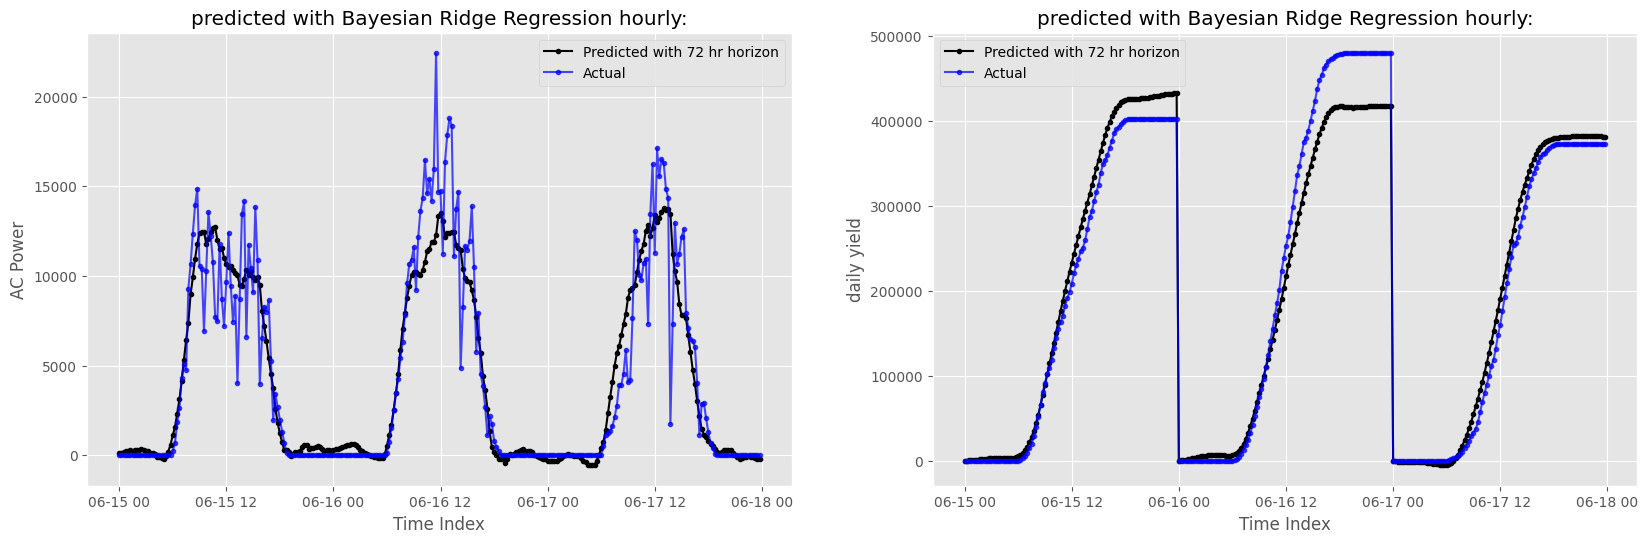

time: 656 ms (started: 2022-03-28 23:53:59 +02:00)


In [ ]:
plot_pred_vs_actual(results_brr_hourly, 'Bayesian Ridge Regression hourly:')

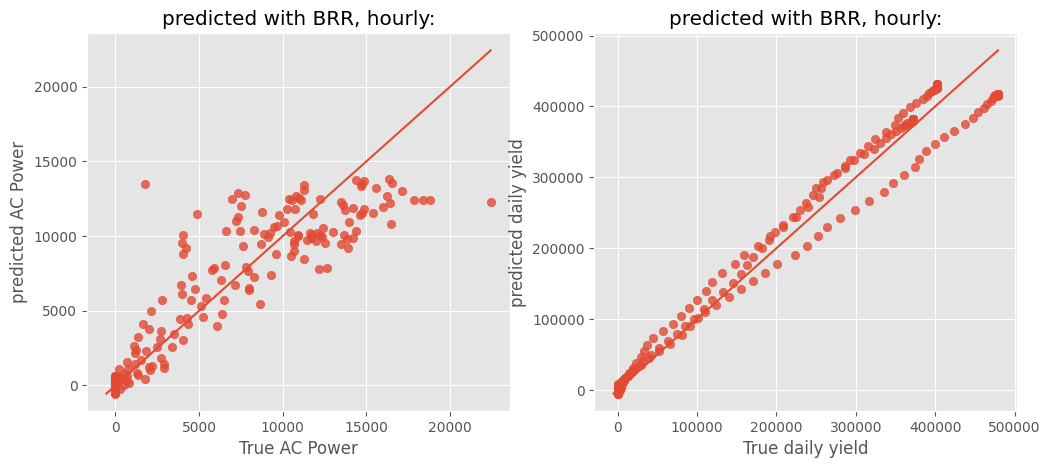

time: 391 ms (started: 2022-03-28 23:54:00 +02:00)


In [ ]:
plot_accuracy(results_brr_hourly, 'BRR, hourly:')

In [ ]:
print_eval_scores(results_brr_hourly, 'Bayesian Ridge Regression', hourly = True)

Bayesian Ridge Regression hourly prediction
AC power R2 score:        86.067%    MAE:  1243.96kW
daily yield R2 score:     97.581%    MAE: 20423.93kWh
time: 0 ns (started: 2022-03-28 23:54:01 +02:00)


### 3.5.4 Results Three Days forecast

In [ ]:
predictions = pred_three_days(model_brr, test_weather_info, feature_df.shape[1])
results_brr = create_results_df(predictions, y_test.copy(deep=True))


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2020-06-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  288 non-null    float64
 1   actual      288 non-null    float64
dtypes: float64(2)
memory usage: 6.8 KB
time: 14.8 s (started: 2022-03-28 23:54:01 +02:00)


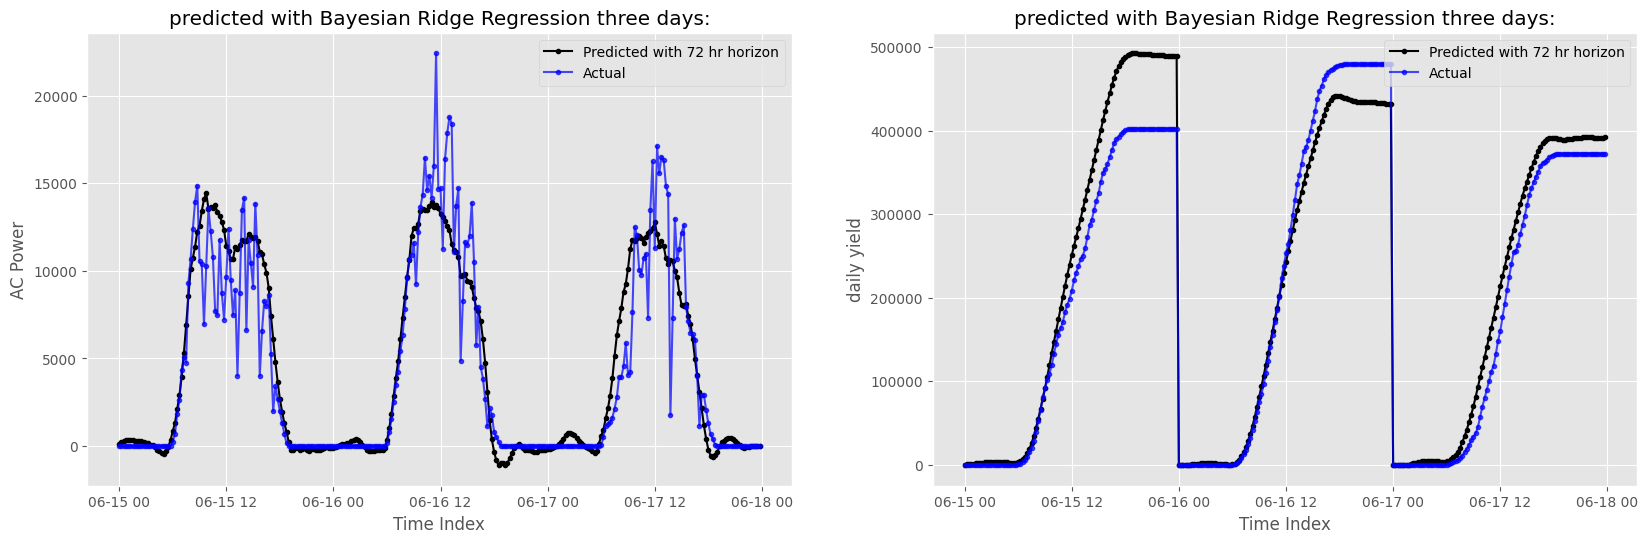

time: 531 ms (started: 2022-03-28 23:54:16 +02:00)


In [ ]:
plot_pred_vs_actual(results_brr, 'Bayesian Ridge Regression three days:')

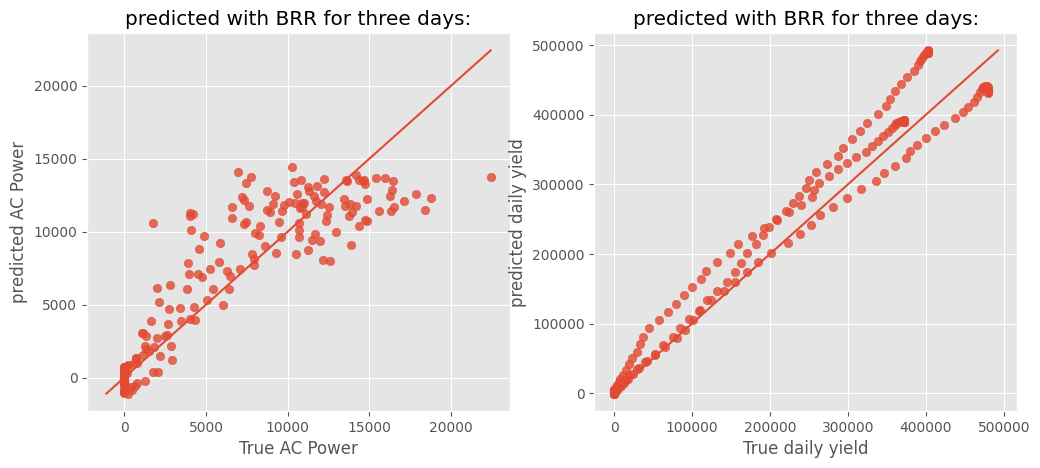

time: 562 ms (started: 2022-03-28 23:54:17 +02:00)


In [ ]:
plot_accuracy(results_brr, 'BRR for three days:')

In [ ]:
print_eval_scores(results_brr, 'Bayesian Ridge Regression', hourly = False)

Bayesian Ridge Regression three day prediction
AC power R2 score:        84.636%    MAE:  1319.75kW
daily yield R2 score:     95.460%    MAE: 27644.50kWh
time: 0 ns (started: 2022-03-28 23:54:18 +02:00)


## 3.6 Elastic Net

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = train_test_split(dataX, dataY, val_start_dt = '2020-6-12 0:00', test_start_dt = '2020-06-15 0:00', val = True)

Train data shape:  (2203, 9504) (2203,)
Validation data shape:  (288, 9504) (288,)
Test data shape:  (288, 9504) (288,)
time: 1.2 s (started: 2022-03-28 23:54:19 +02:00)


### 3.6.1 Model Creation

In [ ]:

# Hyperparameters:
max_iter = 500
tol = 1e-5 # default = 1e-4
alpha = 1 # default = 1
l1_ratio = 0.5 # default = 0.5

en = ElasticNet(max_iter = max_iter, tol = tol, alpha = alpha, l1_ratio = l1_ratio)

model_en = en.fit(X_train, y_train)
model_prediction_scores(model_en, X_val, y_val, 'Elastic Net Regression')

-----------------------------------
Elastic Net Regression Training R^2 Score:  0.0
-----------------------------------
-----------------------------------
Elastic Net Regression Validation R^2 Score:  -0.023840337508981957
-----------------------------------
time: 515 ms (started: 2022-03-28 23:54:20 +02:00)


we can see that the basic elastic net regression does a very poor job at predicting.
>In fact, the R² score of 0 seems to imply that every prediction is the same and is simply the mean of all the true AC power values. For the formula of R², please see [Chapter 1.2](#12-choosing-a-measure-of-losssuccess)

### 3.6.1 hyperparameter optimization

In [ ]:
def objective(n_trials):
    params = {
        'alpha': n_trials.suggest_float('alpha', 1e-3, 0.1, log = True),
        'l1_ratio': n_trials.suggest_float('l1_ratio', 1e-2, 1, log=True),
        'max_iter': 1000,
        'tol': 1e-5
    }
    model = ElasticNet()
    model.set_params(**params)
    regressor = model.fit(X_train, y_train)
    y_pred = regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    return mse

time: 0 ns (started: 2022-03-28 23:54:21 +02:00)


In [ ]:
study_en = op.create_study(direction="minimize")
study_en.optimize(objective, n_trials=100)
print(f"Optimized MAE: {study_en.best_value:.4f}")
print("Best params:")
for key, value in study_en.best_params.items():
    print(f"\t{key}: {value}")

[I 2022-03-28 23:54:22,066] A new study created in memory with name: no-name-83819874-3624-41d8-9e1d-9edf2963a7ad
[I 2022-03-28 23:54:25,755] Trial 0 finished with value: 0.0060678534686967565 and parameters: {'alpha': 0.008257105532487418, 'l1_ratio': 0.6736196519828163}. Best is trial 0 with value: 0.0060678534686967565.
[I 2022-03-28 23:54:33,005] Trial 1 finished with value: 0.005822404158453768 and parameters: {'alpha': 0.005206800579609443, 'l1_ratio': 0.2298568402503087}. Best is trial 1 with value: 0.005822404158453768.
[I 2022-03-28 23:54:39,889] Trial 2 finished with value: 0.009460021902348062 and parameters: {'alpha': 0.07560285416783341, 'l1_ratio': 0.24972008610655713}. Best is trial 1 with value: 0.005822404158453768.
[I 2022-03-28 23:54:46,752] Trial 3 finished with value: 0.005798223704271028 and parameters: {'alpha': 0.012004011956123101, 'l1_ratio': 0.27684696449875007}. Best is trial 3 with value: 0.005798223704271028.
[I 2022-03-28 23:54:49,584] Trial 4 finished wi

Optimized MAE: 0.0058
Best params:
	alpha: 0.01042784310949051
	l1_ratio: 0.21421459789329492
time: 12min 38s (started: 2022-03-28 23:54:22 +02:00)


<ipython-input-118-839950ed6695>:1: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

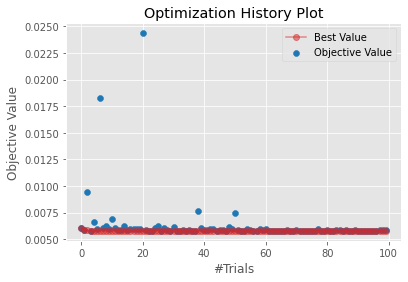

time: 360 ms (started: 2022-03-29 00:07:00 +02:00)


In [ ]:
plot_optimization_history(study_en)

In [ ]:
fig = op.visualization.plot_param_importances(study_en)
fig.show()

time: 2.81 s (started: 2022-03-29 00:07:01 +02:00)


In [ ]:
fig = op.visualization.plot_slice(study_en, params=['alpha', 'l1_ratio'])
fig.show()

time: 2.14 s (started: 2022-03-29 00:07:04 +02:00)


In [ ]:
model_en.set_params(**study_en.best_params)
model_en.fit(X_train, y_train)
model_prediction_scores(model_en, X_val, y_val, 'Elastic Net Regression')

-----------------------------------
Elastic Net Regression Training R^2 Score:  0.9302984277713211
-----------------------------------
-----------------------------------
Elastic Net Regression Validation R^2 Score:  0.8755404053812699
-----------------------------------
time: 6.11 s (started: 2022-03-29 00:07:07 +02:00)


C:\Users\AEppl\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001889574331512378, tolerance: 0.0015540240697845009



Best Parameters so far: ElasticNet(alpha=0.01088263937530115, l1_ratio=0.2257132626448524, max_iter=500,
           tol=1e-05)

In [ ]:
# Train-Test Split:
X_train, y_train, X_test, y_test = train_test_split(dataX, dataY, test_start_dt = '2020-06-15 0:00')
model_en.fit(X_train, y_train)

Train data shape:  (2491, 9504) (2491,)
Test data shape:  (288, 9504) (288,)


C:\Users\AEppl\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005444466381433699, tolerance: 0.0016904390321114439



ElasticNet(alpha=0.01042784310949051, l1_ratio=0.21421459789329492,
           max_iter=500, tol=1e-05)

time: 7.28 s (started: 2022-03-29 00:07:13 +02:00)


Best model: ElasticNet(alpha=0.01088263937530115, l1_ratio=0.2257132626448524, max_iter=500, tol=1e-05)

### 3.6.2 Results hourly predictions

In [ ]:
predictions = model_en.predict(X_test)
results_en_hourly = create_results_df(predictions, y_test)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2020-06-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  288 non-null    float64
 1   actual      288 non-null    float64
dtypes: float64(2)
memory usage: 6.8 KB
time: 109 ms (started: 2022-03-29 00:07:21 +02:00)


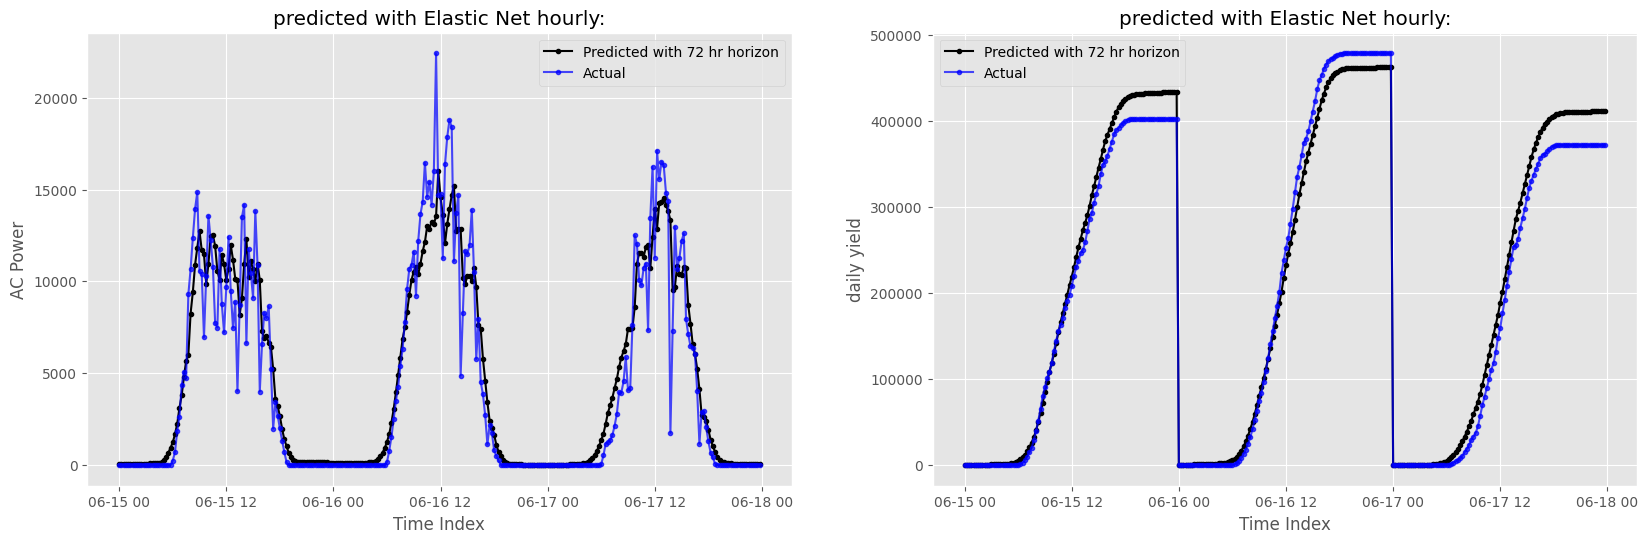

time: 625 ms (started: 2022-03-29 00:07:22 +02:00)


In [ ]:
plot_pred_vs_actual(results_en_hourly, 'Elastic Net hourly:')

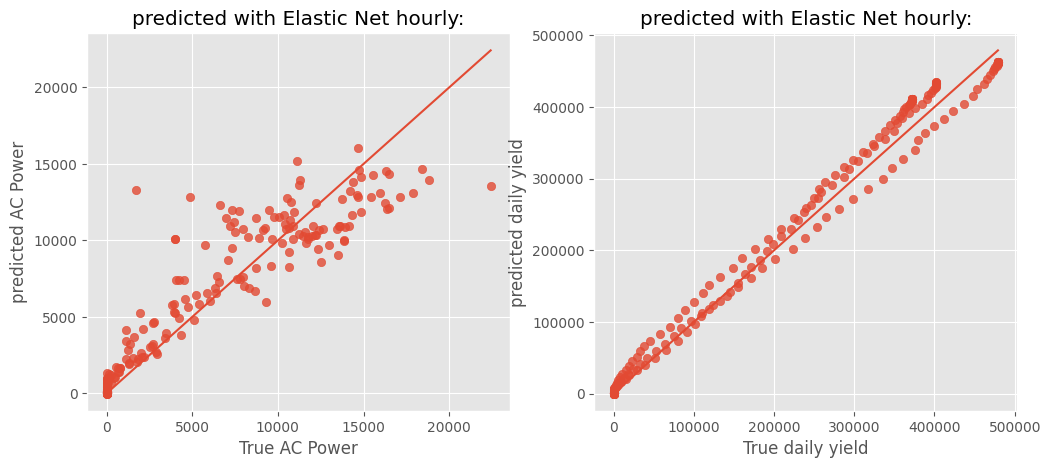

time: 360 ms (started: 2022-03-29 00:07:23 +02:00)


In [ ]:
plot_accuracy(results_en_hourly, 'Elastic Net hourly:')

In [ ]:
print_eval_scores(results_en_hourly, 'Elastic Net', hourly = True)

Elastic Net hourly prediction
AC power R2 score:        88.069%    MAE:  1117.50kW
daily yield R2 score:     98.692%    MAE: 16392.52kWh
time: 16 ms (started: 2022-03-29 00:07:24 +02:00)


### 3.6.3 Results three days

In [ ]:
predictions = pred_three_days(model_en, test_weather_info, feature_df.shape[1])
results_en = create_results_df(predictions, y_test.copy(deep=True))


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2020-06-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  288 non-null    float64
 1   actual      288 non-null    float64
dtypes: float64(2)
memory usage: 6.8 KB
time: 14.9 s (started: 2022-03-29 00:07:24 +02:00)


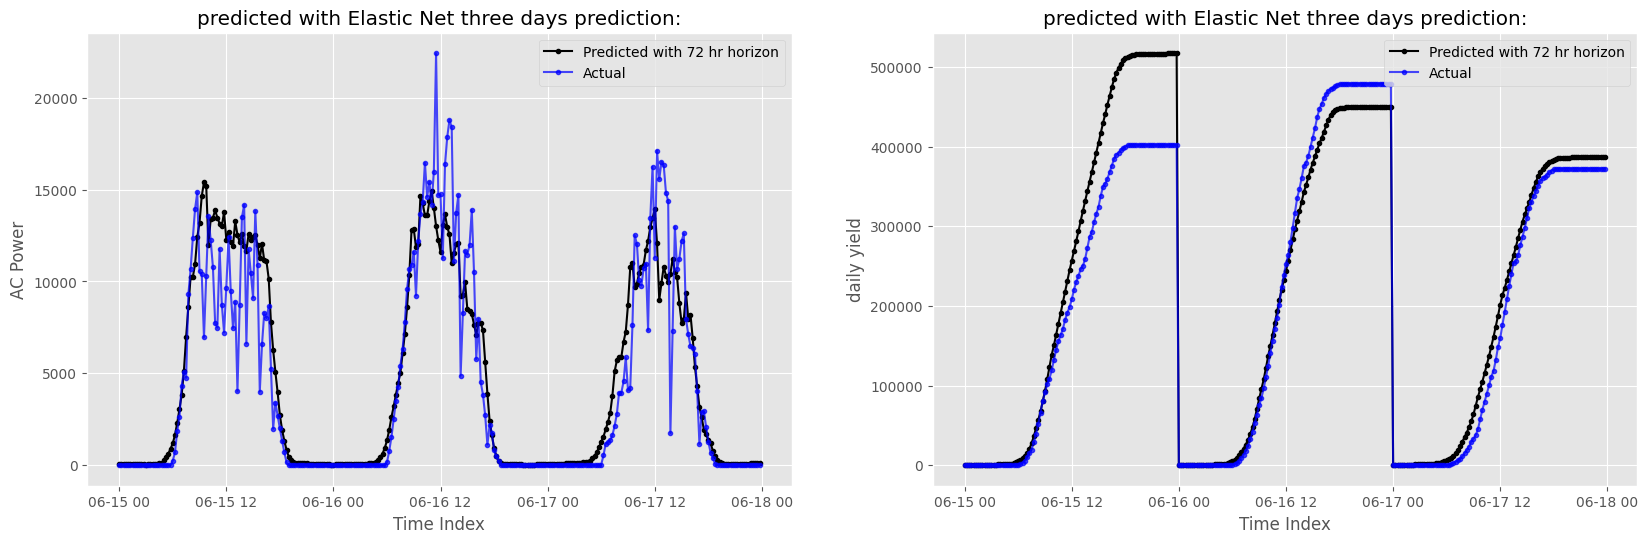

time: 500 ms (started: 2022-03-29 00:07:39 +02:00)


In [ ]:
plot_pred_vs_actual(results_en, 'Elastic Net three days prediction:')

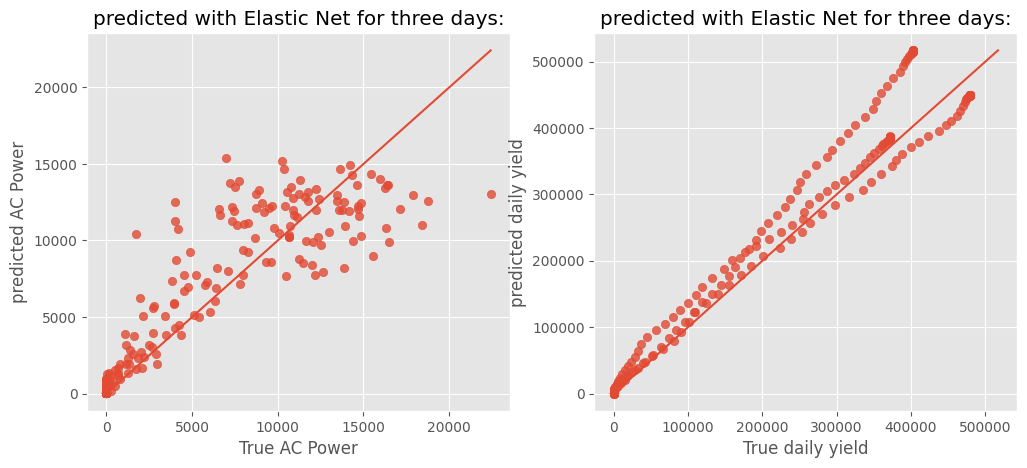

time: 453 ms (started: 2022-03-29 00:07:40 +02:00)


In [ ]:
plot_accuracy(results_en, 'Elastic Net for three days:')

In [ ]:
print_eval_scores(results_en, 'Elastic Net', hourly = False)

Elastic Net three day prediction
AC power R2 score:        82.776%    MAE:  1324.08kW
daily yield R2 score:     94.185%    MAE: 27897.09kWh
time: 0 ns (started: 2022-03-29 00:07:41 +02:00)


## 3.7 Gradient Boosting

In [ ]:
### building XGboost model
max_depth = 10
learning_rate = 1
min_child_weight = 0
n_estimators = 500
min_split_loss = 1

RegModel=XGBRegressor(max_depth = max_depth, 
                      learning_rate = learning_rate, 
                      min_child_weight = min_child_weight, 
                      n_estimators = n_estimators, 
                      min_split_loss = min_split_loss,
                      objective = 'reg:squarederror', 
                      booster = 'gbtree')

model_xgb = RegModel.fit(X_train, y_train)
model_prediction_scores(model_xgb, X_val, y_val, 'XGboost')


-----------------------------------
XGboost Training R^2 Score:  0.9270348218127171
-----------------------------------
-----------------------------------
XGboost Validation R^2 Score:  0.8465743375567297
-----------------------------------
time: 16min 15s (started: 2022-03-29 00:07:42 +02:00)


In [ ]:
predictions = model_xgb.predict(X_test)
results_xgb_hourly = create_results_df(predictions, y_test)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2020-06-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  288 non-null    float32
 1   actual      288 non-null    float64
dtypes: float32(1), float64(1)
memory usage: 5.6 KB
time: 656 ms (started: 2022-03-29 00:23:58 +02:00)


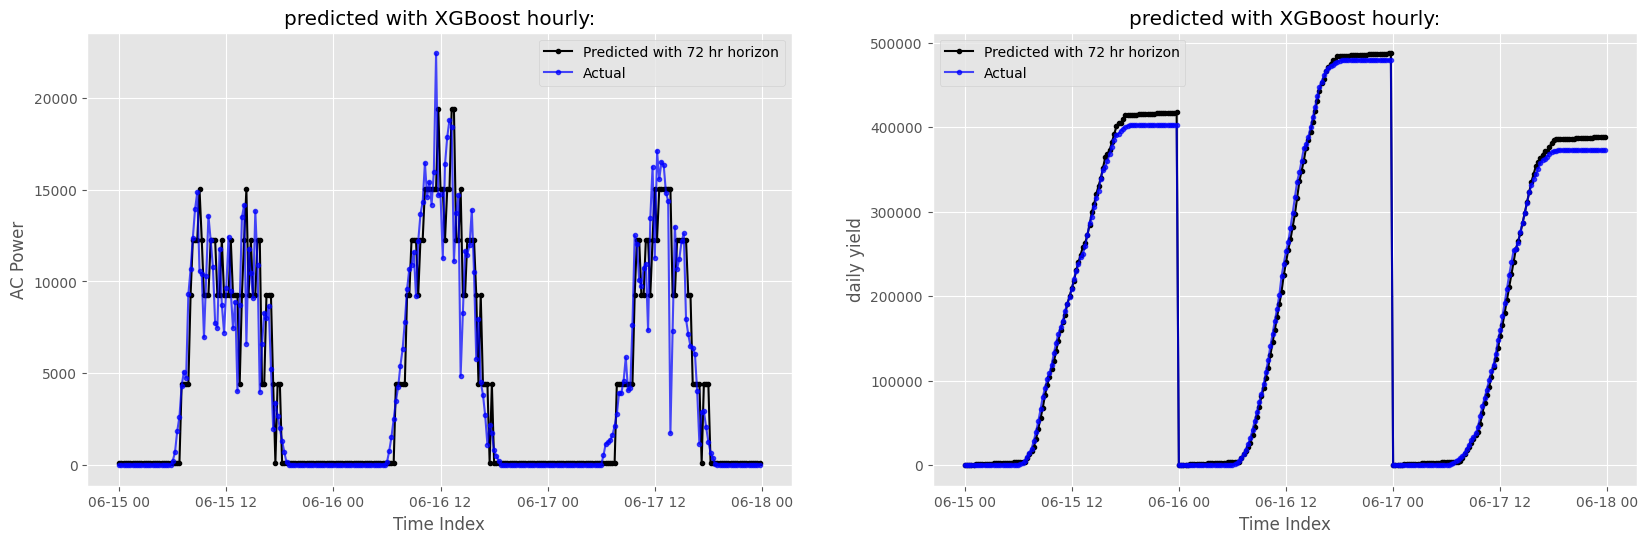

time: 1.09 s (started: 2022-03-29 00:24:00 +02:00)


In [ ]:
plot_pred_vs_actual(results_xgb_hourly, 'XGBoost hourly:')

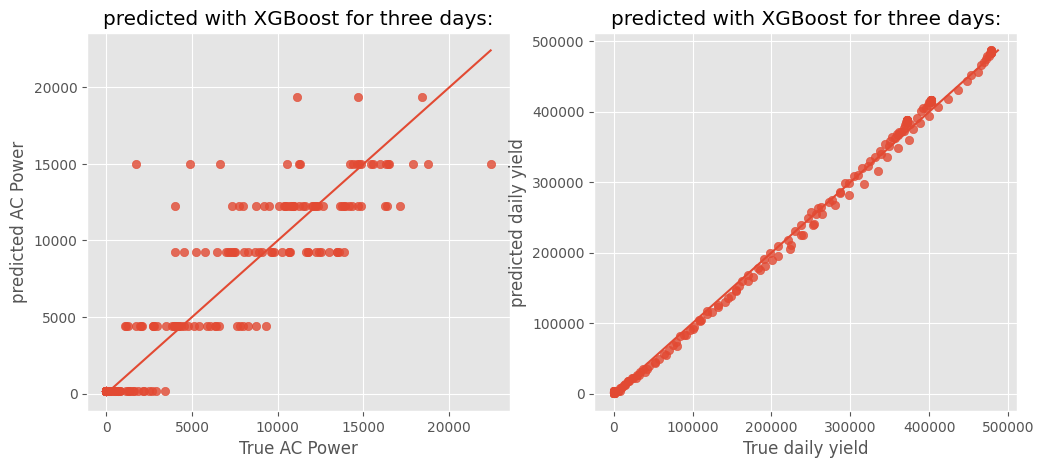

time: 766 ms (started: 2022-03-29 00:24:02 +02:00)


In [ ]:
plot_accuracy(results_xgb_hourly, 'XGBoost for three days:')

In [ ]:
print_eval_scores(results_xgb_hourly, 'XGBoost hourly predictions')

XGBoost hourly predictions hourly prediction
AC power R2 score:        84.927%    MAE:  1213.70kW
daily yield R2 score:     99.805%    MAE:  6312.80kWh
time: 16 ms (started: 2022-03-29 00:24:04 +02:00)


In [ ]:
predictions = pred_three_days(model_xgb, test_weather_info, feature_df.shape[1], np_able = False)
results_xgb = create_results_df(predictions, y_test.copy(deep=True))


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2020-06-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  288 non-null    float64
 1   actual      288 non-null    float64
dtypes: float64(2)
memory usage: 6.8 KB
time: 9min 50s (started: 2022-03-29 00:24:05 +02:00)


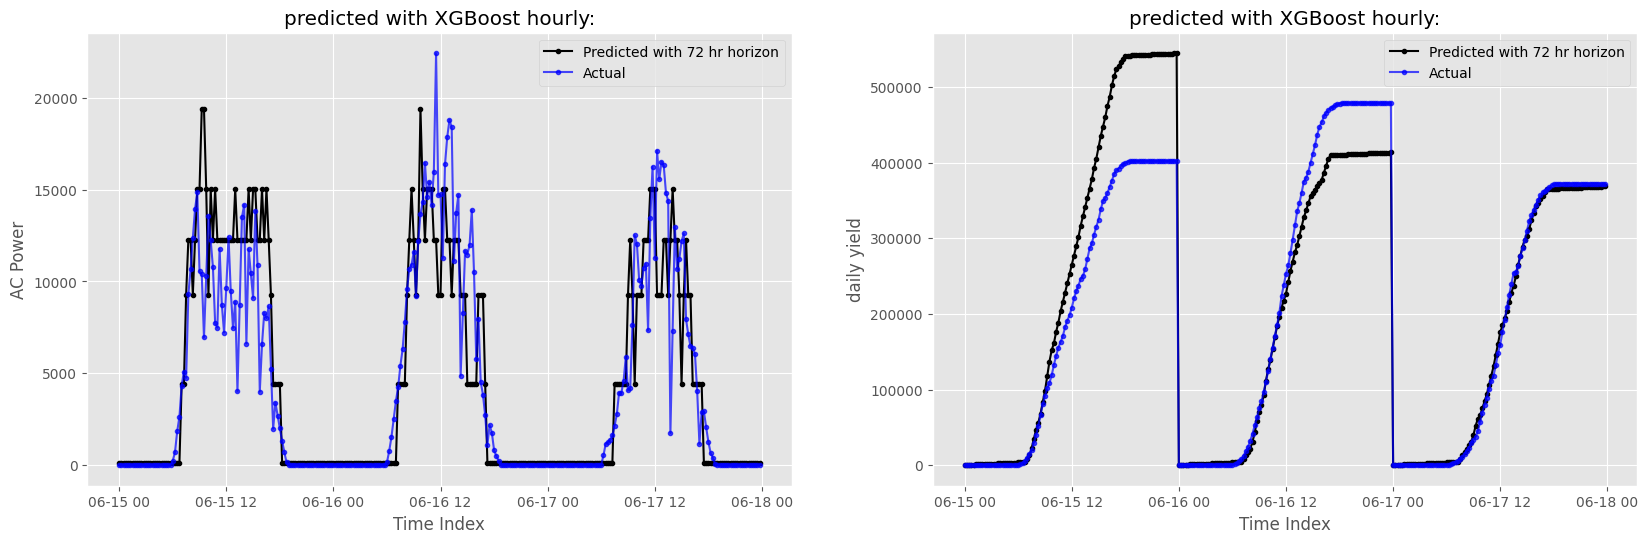

time: 484 ms (started: 2022-03-29 00:33:56 +02:00)


In [ ]:
plot_pred_vs_actual(results_xgb, 'XGBoost hourly:')

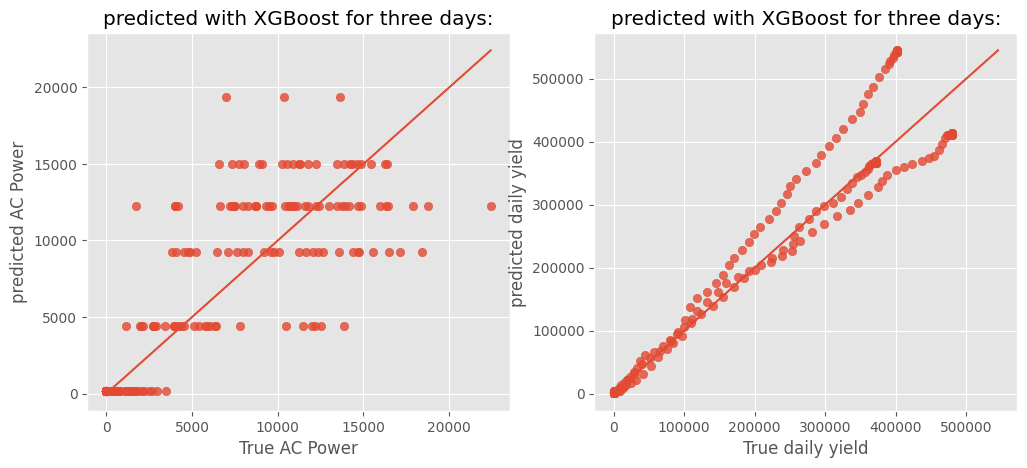

time: 422 ms (started: 2022-03-29 00:33:57 +02:00)


In [ ]:
plot_accuracy(results_xgb, 'XGBoost for three days:')

In [ ]:
print_eval_scores(results_xgb, 'XGBoost three day predictions')

XGBoost three day predictions hourly prediction
AC power R2 score:        71.786%    MAE:  1688.66kW
daily yield R2 score:     90.470%    MAE: 33540.02kWh
time: 15 ms (started: 2022-03-29 00:33:58 +02:00)


# 4: Testing Phase 2: Model Development

In [ ]:
# Train-Validation-Test Split:
X_train, y_train, X_val, y_val, X_test, y_test = train_test_split(dataX, dataY, val_start_dt = '2020-6-12 0:00', test_start_dt = '2020-06-15 0:00', val = True)

Train data shape:  (2203, 9504) (2203,)
Validation data shape:  (288, 9504) (288,)
Test data shape:  (288, 9504) (288,)
time: 1.72 s (started: 2022-03-29 10:47:04 +02:00)


## 4.1 Simple Neural Network

### 4.1.1 Create Neural Network Model

In [ ]:
def build_model_batch(learning_rate, no_layers, neurons, dropout, activation):
    #Here we will use Sequential API
    model = models.Sequential()

    if activation in ['relu', 'selu']:
        model.add(layers.Dense(neurons, kernel_initializer="he_normal", input_shape=(X_train.shape[1],), activation = activation))
    elif activation == 'leaky_relu':
        model.add(layers.Dense(neurons, kernel_initializer="he_normal", input_shape=(X_train.shape[1],)))
        model.add(keras.layers.LeakyReLU(alpha=0.1))
    else:
        model.add(layers.Dense(neurons, input_shape=(X_train.shape[1],), activation = activation))

    model.add(layers.Dropout(dropout))                        
    model.add(layers.BatchNormalization())

    for _ in range (no_layers):
        if activation in ['relu', 'selu', 'gelu']:
            model.add(layers.Dense(neurons, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal", activation = activation))
        elif activation == 'leaky_relu':
            model.add(layers.Dense(neurons, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal"))
            model.add(keras.layers.LeakyReLU(alpha=0.1))
        else:
            model.add(layers.Dense(neurons, activation = activation))
        model.add(layers.Dropout(dropout))
        model.add(layers.BatchNormalization())

    # here, we will use the fact that our model can only have positive values by using relu in the last activation layer
    model.add(layers.Dense(1, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal", activation = 'relu'))

    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss=['mse'], metrics=['mae'])
    return model

time: 0 ns (started: 2022-03-29 10:47:06 +02:00)


In [ ]:
#Looking at the graph:
build_model_batch(learning_rate = 0.001, no_layers = 4, neurons = 32, dropout = 0.2, activation = 'leaky_relu').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                304160    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [ ]:
#We will first create the object to feed fit() method:
myCheckpoint= keras.callbacks.ModelCheckpoint("model_nn.h5", save_best_only=True)

time: 0 ns (started: 2022-03-29 10:47:13 +02:00)


In [ ]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
early_stopping_patience = 20
myEarly_stopping = keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

time: 0 ns (started: 2022-03-29 10:47:13 +02:00)


In [ ]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 500
batch_size = 32

time: 0 ns (started: 2022-03-29 10:47:14 +02:00)


In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_base = build_model_batch(learning_rate = 0.001, no_layers = 4, neurons = 32, dropout = 0.2, activation = 'leaky_relu')

#Training step: Trains the model in silent mode (verbose = 0)
history_base = model_base.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val) , 
                                callbacks=[myCheckpoint,myEarly_stopping], verbose=2)

Epoch 1/500
69/69 - 2s - loss: 0.3136 - mae: 0.3430 - val_loss: 0.0933 - val_mae: 0.1639
Epoch 2/500
69/69 - 2s - loss: 0.1725 - mae: 0.2451 - val_loss: 0.0827 - val_mae: 0.1497
Epoch 3/500
69/69 - 3s - loss: 0.1448 - mae: 0.2201 - val_loss: 0.0532 - val_mae: 0.1037
Epoch 4/500
69/69 - 4s - loss: 0.1346 - mae: 0.2094 - val_loss: 0.0467 - val_mae: 0.0836
Epoch 5/500
69/69 - 10s - loss: 0.1195 - mae: 0.1872 - val_loss: 0.0459 - val_mae: 0.0827
Epoch 6/500
69/69 - 10s - loss: 0.1111 - mae: 0.1778 - val_loss: 0.0403 - val_mae: 0.0774
Epoch 7/500
69/69 - 8s - loss: 0.0945 - mae: 0.1556 - val_loss: 0.0350 - val_mae: 0.0573
Epoch 8/500
69/69 - 10s - loss: 0.0793 - mae: 0.1365 - val_loss: 0.0325 - val_mae: 0.0483
Epoch 9/500
69/69 - 7s - loss: 0.0717 - mae: 0.1260 - val_loss: 0.0329 - val_mae: 0.0497
Epoch 10/500
69/69 - 8s - loss: 0.0626 - mae: 0.1113 - val_loss: 0.0331 - val_mae: 0.0525
Epoch 11/500
69/69 - 3s - loss: 0.0588 - mae: 0.1058 - val_loss: 0.0329 - val_mae: 0.0544
Epoch 12/500
69/

In [ ]:
#Calling back the best model:
model_nn = keras.models.load_model("model_nn.h5")

time: 703 ms (started: 2022-03-29 10:56:37 +02:00)


In [ ]:
#Let's look into the history recorded:
hist_nn = pd.DataFrame(history_base.history)
#Adding epoch column:
hist_nn['epoch'] = history_base.epoch
print("best epoch:")
hist_nn.iloc[-early_stopping_patience-1]

best epoch:


loss          0.008011
mae           0.047762
val_loss      0.006275
val_mae       0.040332
epoch       200.000000
Name: 200, dtype: float64

time: 16 ms (started: 2022-03-29 10:56:38 +02:00)


In [ ]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history['epoch'],history['loss'], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'],history['val_loss'], "b-.", linewidth=1.5, label="Validation")
  plt.legend()
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Loss (MSE)")

time: 0 ns (started: 2022-03-29 10:56:38 +02:00)


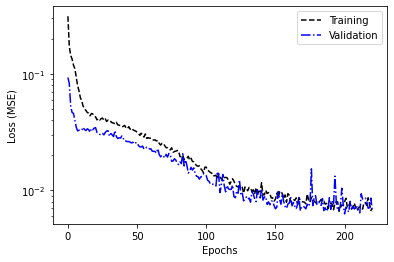

time: 1.08 s (started: 2022-03-29 10:56:38 +02:00)


In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_nn)

In [ ]:
model_prediction_scores(model_nn, X_val, y_val, 'Neural Network')

-----------------------------------
Neural Network Training R^2 Score:  0.942077061974813
-----------------------------------
-----------------------------------
Neural Network Validation R^2 Score:  0.8829912577382283
-----------------------------------
time: 2.17 s (started: 2022-03-29 10:56:40 +02:00)


### 4.1.2 Hyperparameter optimization

With the help of Optuna, we will optimize the batch size, optimizer learning rate, the number of layers, the dropout rate as well as the activation function. Below, you can find an overview of the activation functions used.

In [ ]:
Image(url="activation functions.png", width = 700)

time: 0 ns (started: 2022-03-29 10:56:42 +02:00)


In [ ]:
def objective_nn(n_trials):
    params = {
        'batch_size' : n_trials.suggest_categorical('batch_size', [8, 16, 32, 64, 128]),
        'learning_rate' : n_trials.suggest_float('learning_rate', 1e-4, 1e-1, log = True),
        'no_layers' : n_trials.suggest_int('no_layers', 1, 4),
        'neurons' : 20, # n_trials.suggest_int('neurons', 5, 30, log = True),
        'dropout' : n_trials.suggest_float('dropout', 0.2, 0.5, log = True),
        'activation' : n_trials.suggest_categorical('activation', ['sigmoid', 'tanh', 'softsign', 'relu', 'leaky_relu'])
    }
    model = build_model_batch(learning_rate = params['learning_rate'], no_layers = params['no_layers'], neurons = params['neurons'], 
                              dropout = params['dropout'], activation = params['activation'])
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=params['batch_size'], validation_data=(X_val, y_val) , 
                                callbacks=[myCheckpoint,myEarly_stopping], verbose=0)

    mse = pd.DataFrame(history.history).iloc[-early_stopping_patience-1][3]
    return mse

time: 0 ns (started: 2022-03-29 00:37:13 +02:00)


In [ ]:
study_nn = op.create_study(direction="minimize")
# setting garbage collector after each trial to true in order to avoid runout of memory (OOM)
study_nn.optimize(objective_nn, n_trials=100, gc_after_trial = True)  
print(f"Optimized MSE: {study_nn.best_value:.4f}")
print("Best params:")
for key, value in study_nn.best_params.items():
    print(f"\t{key}: {value}")

[I 2022-03-29 00:37:14,155] A new study created in memory with name: no-name-aa2cd261-90f5-4e47-b406-33e6df6dab98
[I 2022-03-29 00:37:31,485] Trial 0 finished with value: 0.051206424832344055 and parameters: {'batch_size': 32, 'learning_rate': 0.006183547251708438, 'no_layers': 1, 'dropout': 0.49248989272152616, 'activation': 'softsign'}. Best is trial 0 with value: 0.051206424832344055.
[I 2022-03-29 00:39:49,363] Trial 1 finished with value: 0.04105685278773308 and parameters: {'batch_size': 16, 'learning_rate': 0.001754343090378966, 'no_layers': 3, 'dropout': 0.40318740265223596, 'activation': 'leaky_relu'}. Best is trial 1 with value: 0.04105685278773308.
[I 2022-03-29 00:41:47,411] Trial 2 finished with value: 0.04510744288563728 and parameters: {'batch_size': 8, 'learning_rate': 0.011794595310389802, 'no_layers': 4, 'dropout': 0.2517957210507911, 'activation': 'leaky_relu'}. Best is trial 1 with value: 0.04105685278773308.
[I 2022-03-29 00:42:03,450] Trial 3 finished with value: 

Optimized MSE: 0.0395
Best params:
	batch_size: 32
	learning_rate: 0.004542297052594332
	no_layers: 2
	dropout: 0.38805414453715714
	activation: leaky_relu
time: 3h 32min 15s (started: 2022-03-29 00:37:14 +02:00)


<ipython-input-155-7beff2a1392e>:2: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



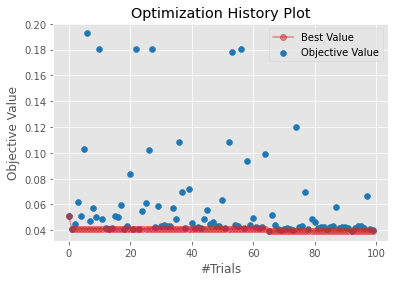

time: 406 ms (started: 2022-03-29 04:09:29 +02:00)


In [ ]:
# svm_opt_results_df = study_svr.trials_dataframe()
plot_optimization_history(study_nn);

In [ ]:
fig = op.visualization.plot_param_importances(study_nn)
fig.show()

time: 3.91 s (started: 2022-03-29 04:09:30 +02:00)


In [ ]:
fig = op.visualization.plot_slice(study_nn)
fig.show()

time: 125 ms (started: 2022-03-29 04:09:35 +02:00)


In [ ]:
model_nn = build_model_batch(learning_rate = study_nn.best_params['learning_rate'], no_layers = study_nn.best_params['no_layers'], 
                             neurons = 20, dropout = study_nn.best_params['dropout'], activation = study_nn.best_params['activation']) # study_nn.best_params['neurons']
history_nn = model_nn.fit(X_train, y_train, epochs=num_epochs, batch_size=study_nn.best_params['batch_size'], validation_data=(X_val, y_val) , 
                          callbacks=[myCheckpoint,myEarly_stopping], verbose=2)

Epoch 1/500
69/69 - 1s - loss: 0.2725 - mae: 0.2942 - val_loss: 0.0740 - val_mae: 0.1624
Epoch 2/500
69/69 - 1s - loss: 0.1216 - mae: 0.2121 - val_loss: 0.0877 - val_mae: 0.1803
Epoch 3/500
69/69 - 1s - loss: 0.1128 - mae: 0.2006 - val_loss: 0.0876 - val_mae: 0.1803
Epoch 4/500
69/69 - 1s - loss: 0.1062 - mae: 0.1944 - val_loss: 0.0873 - val_mae: 0.1801
Epoch 5/500
69/69 - 1s - loss: 0.0956 - mae: 0.1781 - val_loss: 0.0513 - val_mae: 0.1302
Epoch 6/500
69/69 - 1s - loss: 0.0750 - mae: 0.1551 - val_loss: 0.0214 - val_mae: 0.0683
Epoch 7/500
69/69 - 1s - loss: 0.0579 - mae: 0.1345 - val_loss: 0.0165 - val_mae: 0.0534
Epoch 8/500
69/69 - 1s - loss: 0.0427 - mae: 0.1165 - val_loss: 0.0184 - val_mae: 0.0601
Epoch 9/500
69/69 - 1s - loss: 0.0351 - mae: 0.1034 - val_loss: 0.0150 - val_mae: 0.0489
Epoch 10/500
69/69 - 1s - loss: 0.0335 - mae: 0.1007 - val_loss: 0.0150 - val_mae: 0.0489
Epoch 11/500
69/69 - 1s - loss: 0.0299 - mae: 0.0916 - val_loss: 0.0160 - val_mae: 0.0511
Epoch 12/500
69/69 

In [ ]:
model_nn = keras.models.load_model("model_nn.h5")
model_prediction_scores(model_nn, X_val, y_val, 'Neural Network')

-----------------------------------
Neural Network Training R^2 Score:  0.9128432100154474
-----------------------------------
-----------------------------------
Neural Network Validation R^2 Score:  0.886069597123413
-----------------------------------
time: 1.24 s (started: 2022-03-29 04:11:26 +02:00)


In [ ]:
predictions = pd.Series(model_nn.predict(X_test).flatten(),index=X_test.index)
results_nn_hourly = create_results_df(predictions, y_test)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2020-06-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  288 non-null    float32
 1   actual      288 non-null    float64
dtypes: float32(1), float64(1)
memory usage: 5.6 KB
time: 344 ms (started: 2022-03-29 04:11:27 +02:00)


### 4.1.2 Results hourly forecast

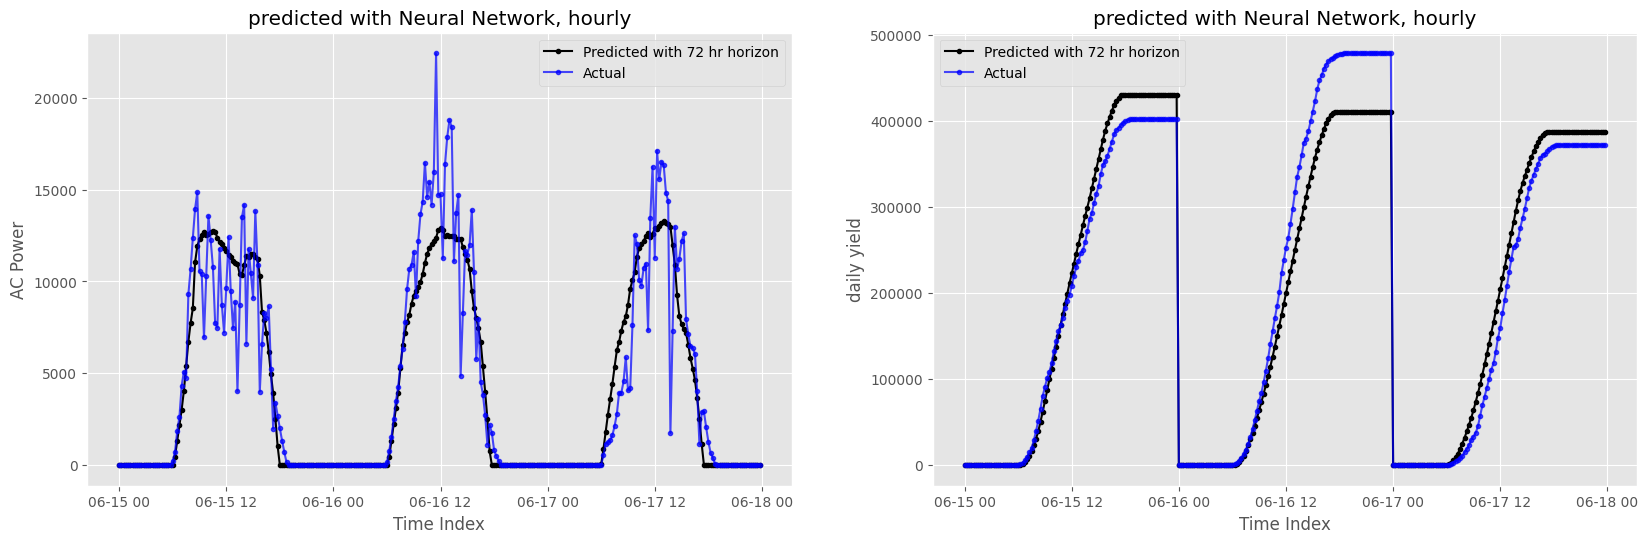

time: 531 ms (started: 2022-03-29 04:11:28 +02:00)


In [ ]:
plot_pred_vs_actual(results_nn_hourly, 'Neural Network, hourly')

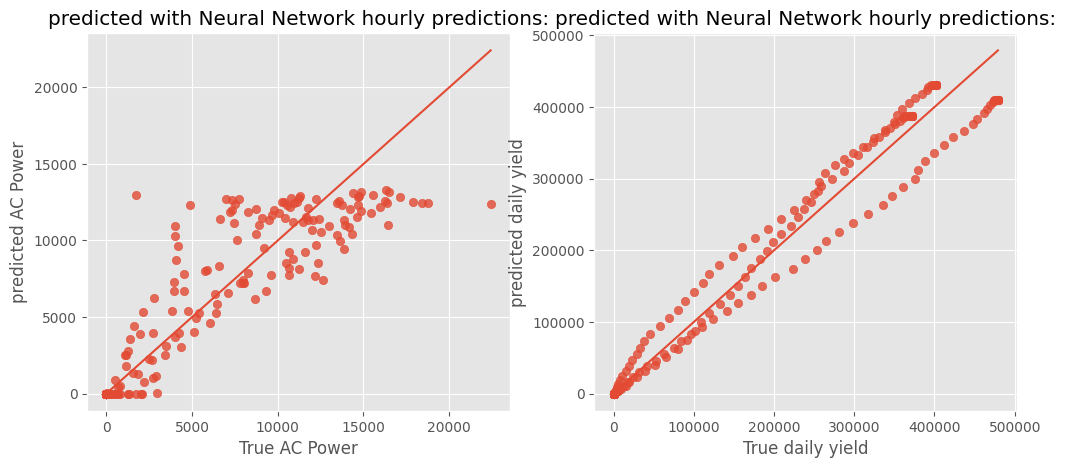

time: 593 ms (started: 2022-03-29 04:11:29 +02:00)


In [ ]:
plot_accuracy(results_nn_hourly, 'Neural Network hourly predictions:')

In [ ]:
print_eval_scores(results_nn_hourly, 'Neural Network', hourly = True)

Neural Network hourly prediction
AC power R2 score:        84.980%    MAE:  1211.83kW
daily yield R2 score:     96.628%    MAE: 23909.26kWh
time: 0 ns (started: 2022-03-29 04:11:29 +02:00)


In [ ]:
predictions = pred_three_days(model_nn, test_weather_info, feature_df.shape[1])
results_nn = create_results_df(predictions, y_test.copy(deep=True))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2020-06-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  288 non-null    float64
 1   actual      288 non-null    float64
dtypes: float64(2)
memory usage: 6.8 KB
time: 25.6 s (started: 2022-03-29 04:11:30 +02:00)


### 4.1.3 Results Three Days Forecast

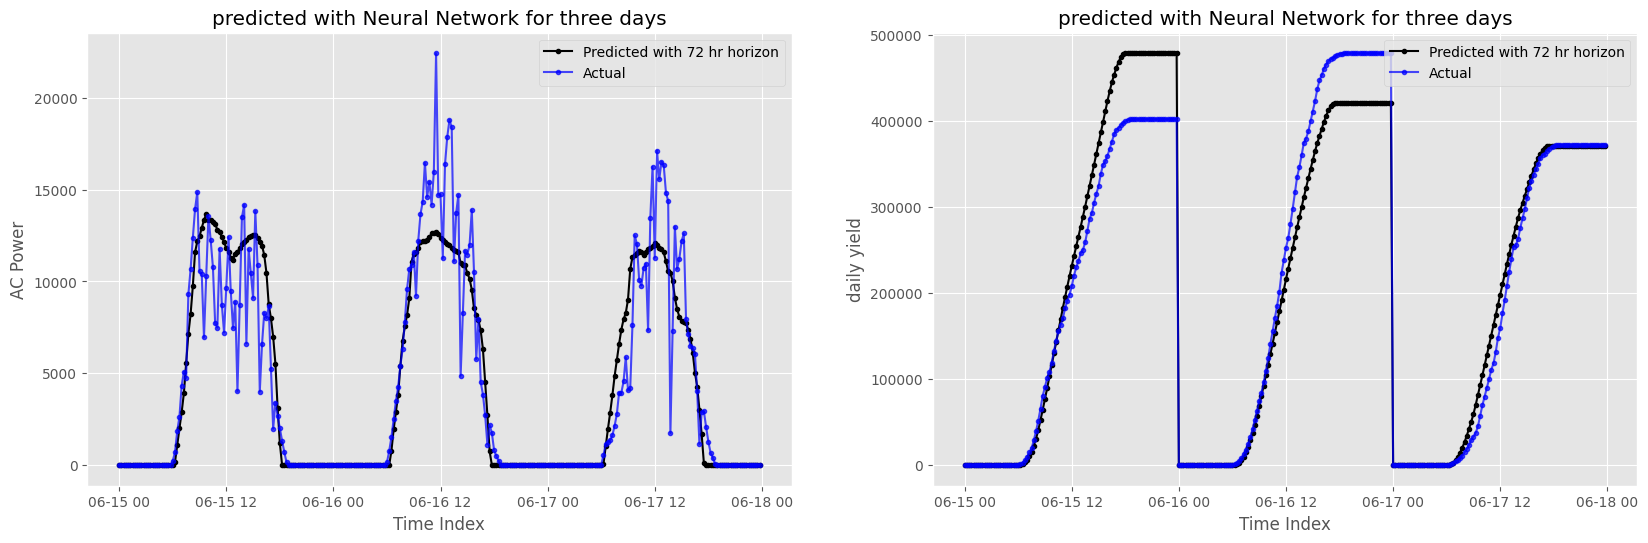

time: 547 ms (started: 2022-03-29 04:11:56 +02:00)


In [ ]:
plot_pred_vs_actual(results_nn, 'Neural Network for three days')

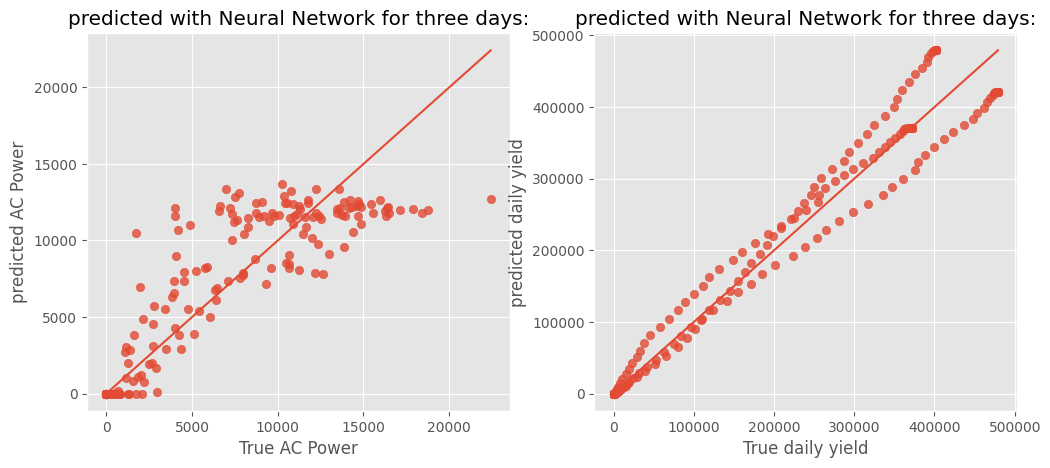

time: 485 ms (started: 2022-03-29 04:11:57 +02:00)


In [ ]:
plot_accuracy(results_nn, 'Neural Network for three days:')

In [ ]:
print_eval_scores(results_nn, 'Neural Network', hourly = False)

Neural Network three day prediction
AC power R2 score:        84.075%    MAE:  1248.24kW
daily yield R2 score:     95.878%    MAE: 24565.09kWh
time: 0 ns (started: 2022-03-29 04:11:58 +02:00)


## 4.2 LSTM

### 4.2.1 Reshaping the data

In [70]:
feature_df.head(2)

AC_POWER  AMBIENT_TEMPERATURE  IRRADIATION     mean_1.0h  \
2020-05-17 00:15:00       0.0             0.285455          0.0  3.657448e-16   
2020-05-17 00:30:00       0.0             0.270908          0.0  3.657448e-16   

                     median_1.0h      std_1.0h  min_1.0h  max_1.0h  mean_2.0h  \
2020-05-17 00:15:00          0.0  6.803338e-09       0.0       0.0        0.0   
2020-05-17 00:30:00          0.0  6.803338e-09       0.0       0.0        0.0   

                     median_2.0h  ...  mean_24.0h  median_24.0h  std_24.0h  \
2020-05-17 00:15:00          0.0  ...    0.219939      0.000642   0.283557   
2020-05-17 00:30:00          0.0  ...    0.219939      0.000642   0.283557   

                     min_24.0h  max_24.0h  mean_48.0h  median_48.0h  \
2020-05-17 00:15:00        0.0   0.797827     0.24046       0.01165   
2020-05-17 00:30:00        0.0   0.797827     0.24046       0.01165   

                     std_48.0h  min_48.0h  max_48.0h  
2020-05-17 00:15:00   0.296077        0.0   0.797827  
2020-05-17 00:30:00   0.296077        0.0   0.797827  

[2 rows x 33 columns]

time: 47 ms (started: 2022-03-29 11:09:51 +02:00)


In [71]:
dataY_temporal = feature_df[forecast_variable]
dataX_temporal = feature_df.drop(forecast_variable, axis = 1)
X_train0, y_train0, X_val0, y_val0, X_test0, y_test0 = train_test_split(dataX_temporal, dataY_temporal, val_start_dt = '2020-6-10 0:00', test_start_dt = '2020-06-14 0:00', val = True)

Train data shape:  (2299, 32) (2299,)
Validation data shape:  (384, 32) (384,)
Test data shape:  (384, 32) (384,)
time: 16 ms (started: 2022-03-29 11:09:52 +02:00)


In [72]:
#Reshaping the 2D [samples, features] data into 3D:[samples, timesteps, features]
#Note that reshape is no longer available in Pandas; this is why we convert it to numpy
#array first.
def dimension_fix(train, label, n_input = 24, n_output=24, batch_size = 32):

  #Preparing the time stamps:
  label_index = label.index

  train = train.to_numpy()
  label = label.to_numpy()
  X, y = list(), list()

# looping one time step at a time:
  for i_start in range(len(train)):
  # define the end of the sequence
    i_end = i_start + n_input
  # ensure we have enough data
    if i_end <= len(train):
      X.append(train[i_start:i_end, :])

#------------------------------------------------------

  for i_start in range(len(label)):
  # define the end of the input sequence
    i_end = i_start + n_input - 1
    out_end = i_end + n_output
  # ensure we have enough data
    if out_end <= len(label):
      y.append(label[i_end:out_end])
  #------------------------#
  #--------Clean up--------#
  #------------------------#
  #we need to omit the data that does not have labels:
  if n_output > 1:
    ranged = [i for i in range(-1,-n_output,-1)]
    X = np.delete(X, ranged, axis=0)

  # finding the remain wrt batch size (assumed 32 here)
  reminder_elements = len(X)%batch_size
  #filtering the matrices: creating a range
  ranged_x = [-i for i in range(reminder_elements)]
  ranged_y = [-i for i in range(reminder_elements)]
  #Filtering X:
  X = np.delete(X, ranged_x, axis=0)
  #Filtering y: due to the n_input shift
  label_index = label_index[n_input:]
  #Filtering y: due to mod operation
  y = np.delete(y, ranged_y, axis=0)
  label_index = label_index[0:len(y)]

  return np.array(X), np.array(y), label_index


time: 0 ns (started: 2022-03-29 11:09:53 +02:00)


In [73]:
#Reshaping the 2D data into 3D:[samples, timesteps, features]
#Note that reshape is no longer available in Pandas; this is why we convert it to numpy
#array first.
batch_size = 32
X_train, y_train, iy_train  = dimension_fix(X_train0, y_train0, 96, 1, batch_size)
X_val, y_val, iy_val = dimension_fix(X_val0, y_val0, 96, 1, batch_size)
X_test, y_test, iy_test = dimension_fix(X_test0, y_test0, 96, 1, batch_size)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
print(iy_train.shape, iy_test.shape)

(2176, 96, 32) (2176, 1) (288, 96, 32) (288, 1) (288, 96, 32) (288, 1)
(2176,) (288,)
time: 110 ms (started: 2022-03-29 11:09:54 +02:00)


In [74]:
#Check the shifts by 24 hours, since AC_power for nighttime hours is zero, we will make a shift to daytime
if observe_15_min_interval: shift = 12*4
else: shift = 12
print(iy_test[0+shift],y_test[0+shift])
print(iy_test[1+shift],y_test[1+shift])
print(iy_test[2+shift],y_test[2+shift])

2020-06-15 12:00:00 [0.37221744]
2020-06-15 12:15:00 [0.47781538]
2020-06-15 12:30:00 [0.36452094]
time: 15 ms (started: 2022-03-29 11:09:54 +02:00)


In [75]:
#Original dataset:
if observe_15_min_interval: print(y_test0[96+shift:len(y_test)+96+shift].iloc[:3])
else: print(y_test0[24+shift:len(y_test)+24+shift].iloc[:3])

2020-06-15 12:00:00    0.372217
2020-06-15 12:15:00    0.477815
2020-06-15 12:30:00    0.364521
Name: AC_POWER, dtype: float64
time: 0 ns (started: 2022-03-29 11:09:55 +02:00)


### 4.2.2 Model Creation

In [76]:
def build_model_lstm(learning_rate, no_layers, neurons, dropout, activation):
    #Here we will use Sequential API
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    model = models.Sequential()

    if activation in ['relu', 'selu']:
        model.add(layers.LSTM(neurons, kernel_initializer="he_normal", return_sequences=True, input_shape=(None, n_features), stateful=False, activation = activation))
    elif activation == 'leaky_relu':
        model.add(layers.LSTM(neurons, kernel_initializer="he_normal", return_sequences=True, input_shape=(None, n_features), stateful=False))
        model.add(keras.layers.LeakyReLU(alpha=0.1))
    else:
        model.add(layers.LSTM(neurons, return_sequences=True, input_shape=(None, n_features), stateful=False, activation = activation))

    model.add(layers.Dropout(dropout))

    for layer in range (no_layers):
        return_sequences = True
        if layer == no_layers-1: return_sequences = False
        if activation in ['relu', 'selu', 'gelu']:
            model.add(layers.LSTM(neurons, return_sequences=return_sequences, stateful=False, kernel_regularizer=regularizers.l2(0.0001), 
                                   kernel_initializer="he_normal", activation = activation))
        elif activation == 'leaky_relu':
            model.add(layers.LSTM(neurons, return_sequences=return_sequences, stateful=False, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal"))
            model.add(keras.layers.LeakyReLU(alpha=0.1))
        else:
            model.add(layers.LSTM(neurons, return_sequences=return_sequences, stateful=False, activation = activation))
        model.add(layers.Dropout(dropout))

    # here, we will use the fact that our model can only have positive values by using relu in the last activation layer
    model.add(layers.Dense(1, kernel_regularizer=regularizers.l2(0.0001), kernel_initializer="he_normal", activation = 'relu'))

    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss=['mse'], metrics=['mae'])
    return model

time: 0 ns (started: 2022-03-29 11:09:56 +02:00)


In [77]:
#Looking at the graph:
build_model_lstm(0.001, 4, 32, 0.2, 'tanh').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 32)          8

In [78]:
#We will first create the object to feed fit() method:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint("model_LSTM.h5", save_best_only=True)

time: 0 ns (started: 2022-03-29 11:10:04 +02:00)


In [79]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

time: 0 ns (started: 2022-03-29 11:10:57 +02:00)


In [80]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 150
batch_size = 32

time: 0 ns (started: 2022-03-29 11:10:58 +02:00)


In [81]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_lstm = build_model_lstm(0.001, 4, 32, 0.2, 'tanh')

#Training step: Trains the model in silent mode (verbose = 0)
history_lstm = model_lstm.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])#, verbose=0)
#Calling back the best model:
model_lstm = keras.models.load_model("model_LSTM.h5")


Epoch 1/150
136/136 [==============================] - 11s 78ms/step - loss: 0.0256 - mae: 0.0981 - val_loss: 0.0188 - val_mae: 0.0835
Epoch 2/150
136/136 [==============================] - 7s 54ms/step - loss: 0.0154 - mae: 0.0714 - val_loss: 0.0138 - val_mae: 0.0694
Epoch 3/150
136/136 [==============================] - 7s 52ms/step - loss: 0.0132 - mae: 0.0650 - val_loss: 0.0148 - val_mae: 0.0700
Epoch 4/150
136/136 [==============================] - 7s 52ms/step - loss: 0.0124 - mae: 0.0623 - val_loss: 0.0125 - val_mae: 0.0638
Epoch 5/150
136/136 [==============================] - 7s 55ms/step - loss: 0.0119 - mae: 0.0609 - val_loss: 0.0231 - val_mae: 0.0922
Epoch 6/150
136/136 [==============================] - 8s 57ms/step - loss: 0.0112 - mae: 0.0582 - val_loss: 0.0122 - val_mae: 0.0649
Epoch 7/150
136/136 [==============================] - 7s 53ms/step - loss: 0.0112 - mae: 0.0586 - val_loss: 0.0146 - val_mae: 0.0683
Epoch 8/150
136/136 [==============================] - 7s 50m

In [ ]:
#Let's look into the history recorded:
hist_lstm = pd.DataFrame(history_lstm.history)
#Adding epoch column:
hist_lstm['epoch'] = history_lstm.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
hist_lstm.sample(3)

hist_lstm.iloc[-21:-20]

loss       mae  val_loss   val_mae  epoch
8  0.01092  0.058156  0.010212  0.058693      8

time: 0 ns (started: 2022-03-29 11:00:56 +02:00)


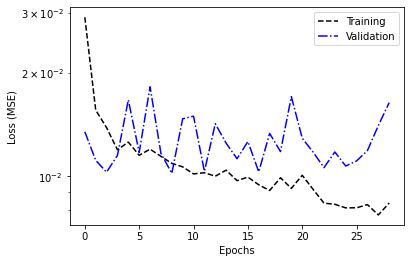

time: 484 ms (started: 2022-03-29 11:00:56 +02:00)


In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_lstm)

### 4.2.3 Hyperparameter optimization

With the help of Optuna, we will optimize the batch size, optimizer learning rate, the number of layers, the dropout rate as well as the activation function. Below, you can find an overview of the activation functions used.

In [ ]:
def objective_lstm(n_trials):
    params = {
        'batch_size' : n_trials.suggest_categorical('batch_size', [32, 72, 144]),
        'learning_rate' : n_trials.suggest_float('learning_rate', 1e-4, 1e-1, log = True),
        'no_layers' : n_trials.suggest_int('no_layers', 1, 4),
        'neurons' : 20, # n_trials.suggest_int('neurons', 5, 30, log = True),
        'dropout' : n_trials.suggest_float('dropout', 0.2, 0.5, log = True),
        'activation' : n_trials.suggest_categorical('activation', ['sigmoid', 'tanh', 'softsign', 'relu', 'leaky_relu'])
    }
    print(params)
    model = build_model_lstm(learning_rate = params['learning_rate'], no_layers = params['no_layers'], neurons = params['neurons'], 
                              dropout = params['dropout'], activation = params['activation'])
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=params['batch_size'], validation_data=(X_val, y_val) , 
                                callbacks=[myCheckpoint,myEarly_stopping], verbose=0)

    mse = pd.DataFrame(history.history).iloc[-early_stopping_patience-1][3]
    return mse

time: 0 ns (started: 2022-03-29 11:00:56 +02:00)


In [ ]:
study_lstm = op.create_study(direction="minimize")
# setting garbage collector after each trial to true in order to avoid runout of memory (OOM)
study_lstm.optimize(objective_lstm, n_trials=100, gc_after_trial = True)  
print(f"Optimized MSE: {study_lstm.best_value:.4f}")
print("Best params:")
for key, value in study_lstm.best_params.items():
    print(f"\t{key}: {value}")

[I 2022-03-29 11:04:25,922] A new study created in memory with name: no-name-11e3ed55-d8c1-4c6e-812d-429203f0054b


In [ ]:
# svm_opt_results_df = study_svr.trials_dataframe()
plot_optimization_history(study_lstm);

In [ ]:
fig = op.visualization.plot_param_importances(study_lstm)
fig.show()

In [ ]:
fig = op.visualization.plot_slice(study_lstm)
fig.show()

In [ ]:
model_lstm = build_model_batch(learning_rate = study_lstm.best_params['learning_rate'], no_layers = study_lstm.best_params['no_layers'], 
                             neurons = 20, dropout = study_lstm.best_params['dropout'], activation = study_lstm.best_params['activation']) # study_lstm.best_params['neurons']
history_lstm = model_lstm.fit(X_train, y_train, epochs=num_epochs, batch_size=study_lstm.best_params['batch_size'], validation_data=(X_val, y_val) , 
                          callbacks=[myCheckpoint,myEarly_stopping], verbose=2)

In [ ]:
model_lstm = keras.models.load_model("model_LSTM.h5")
model_prediction_scores(model_nn, X_val, y_val, 'LSTM')

In [ ]:
#Label and indices:
#Since we have shifted the data by 4 width windows, initial label DF is to be filtered.
y_test_filtered = y_test0.loc[iy_test]
y_test_filtered

2020-06-15 00:00:00    0.0
2020-06-15 00:15:00    0.0
2020-06-15 00:30:00    0.0
2020-06-15 00:45:00    0.0
2020-06-15 01:00:00    0.0
                      ... 
2020-06-17 22:45:00    0.0
2020-06-17 23:00:00    0.0
2020-06-17 23:15:00    0.0
2020-06-17 23:30:00    0.0
2020-06-17 23:45:00    0.0
Name: AC_POWER, Length: 288, dtype: float64

time: 15 ms (started: 2022-03-28 14:52:27 +02:00)


In [ ]:
predictions = pd.Series(model_lstm.predict(X_test).flatten(),index=y_test_filtered.index)
results_lstm_hourly = create_results_df(predictions, y_test_filtered)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2020-06-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  288 non-null    float32
 1   actual      288 non-null    float64
dtypes: float32(1), float64(1)
memory usage: 5.6 KB
time: 6.53 s (started: 2022-03-28 15:08:19 +02:00)


### 4.2.4 Results hourly forecast

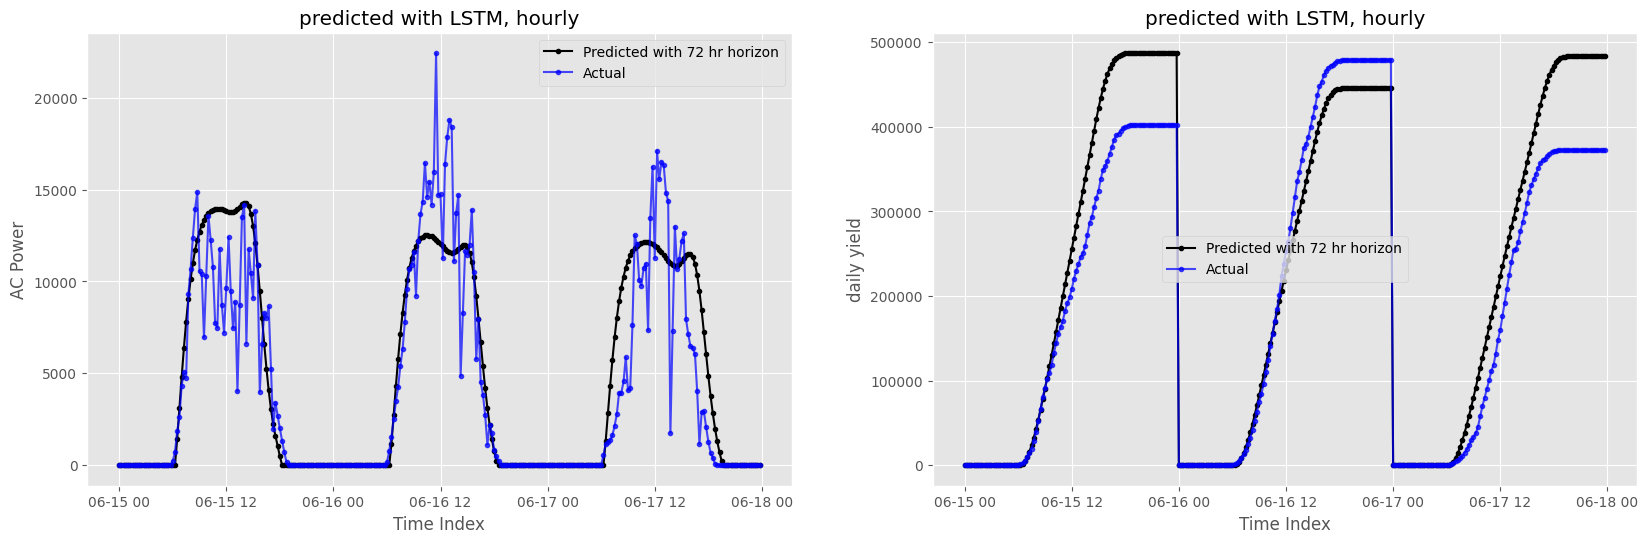

time: 625 ms (started: 2022-03-28 15:08:26 +02:00)


In [ ]:
plot_pred_vs_actual(results_lstm_hourly, 'LSTM, hourly')

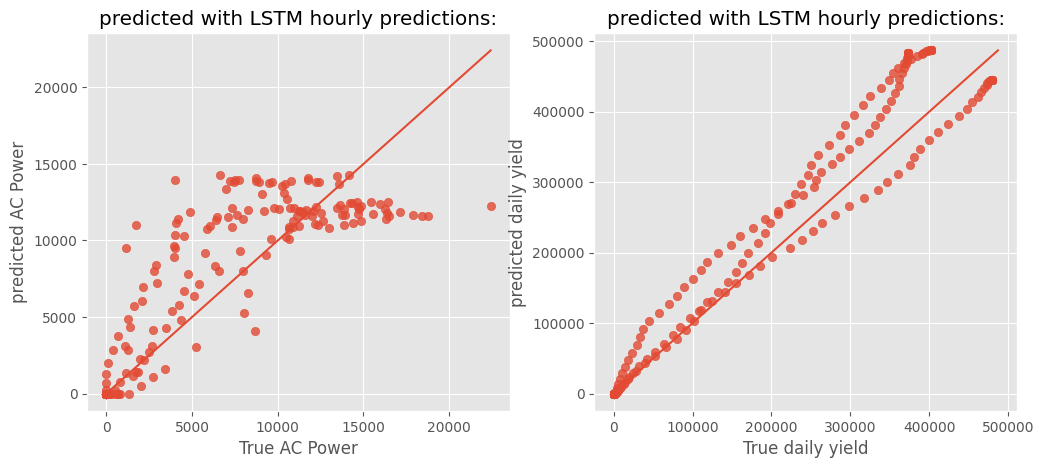

time: 625 ms (started: 2022-03-28 15:08:27 +02:00)


In [ ]:
plot_accuracy(results_lstm_hourly, 'LSTM hourly predictions:')

In [ ]:
print_eval_scores(results_lstm_hourly, 'LSTM', hourly = True)

LSTM hourly prediction
AC power R2 score:        77.359%    MAE:  1494.45kW
daily yield R2 score:     91.221%    MAE: 38556.27kWh
time: 0 ns (started: 2022-03-28 15:08:28 +02:00)


### 4.2.5 Results three days

In [ ]:
def pred_three_days(model, test_weather_info, n_features):
    # series to store the predicted values
    test_weather = test_weather_info.copy(deep = True)
    y_predicted =pd.Series(index=y_test_filtered.index, dtype='float64')
    X_test_last = X_test[0].reshape((1,X_test[0].shape[0], X_test[0].shape[1]))
    for case_index in y_test_filtered.index:
    # predicting with trained input model
        prediction = model.predict(X_test_last).flatten()[0]
        # print(prediction)
        y_predicted.update(pd.Series(prediction,index=[case_index]))
        test_weather.loc[case_index, forecast_variable] = prediction
        update_next_hour = create_feature_df(test_weather)
        
        test_weather = test_weather.iloc[1:, :]
        # updating X_test_last with new values
        for i in range (X_test_last.shape[1]-1):
            X_test_last[0][i] = X_test_last[0][i+1]
        for i in range(update_next_hour.shape[1]-1):
            X_test_last[0][X_test_last.shape[1]-1][i] = update_next_hour.iloc[0,i]
    return y_predicted

time: 15 ms (started: 2022-03-28 15:08:38 +02:00)


In [ ]:
X_test_last = X_test[0].reshape((1,X_test[0].shape[0], X_test[0].shape[1]))
X_test_last.shape

(1, 96, 32)

time: 0 ns (started: 2022-03-28 15:08:39 +02:00)


In [ ]:
predictions = pred_three_days(model_lstm, test_weather_info, feature_df.shape[1])
results_lstm = create_results_df(predictions, y_test_filtered.copy(deep=True))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2020-06-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  288 non-null    float64
 1   actual      288 non-null    float64
dtypes: float64(2)
memory usage: 6.8 KB
time: 38 s (started: 2022-03-28 15:08:40 +02:00)


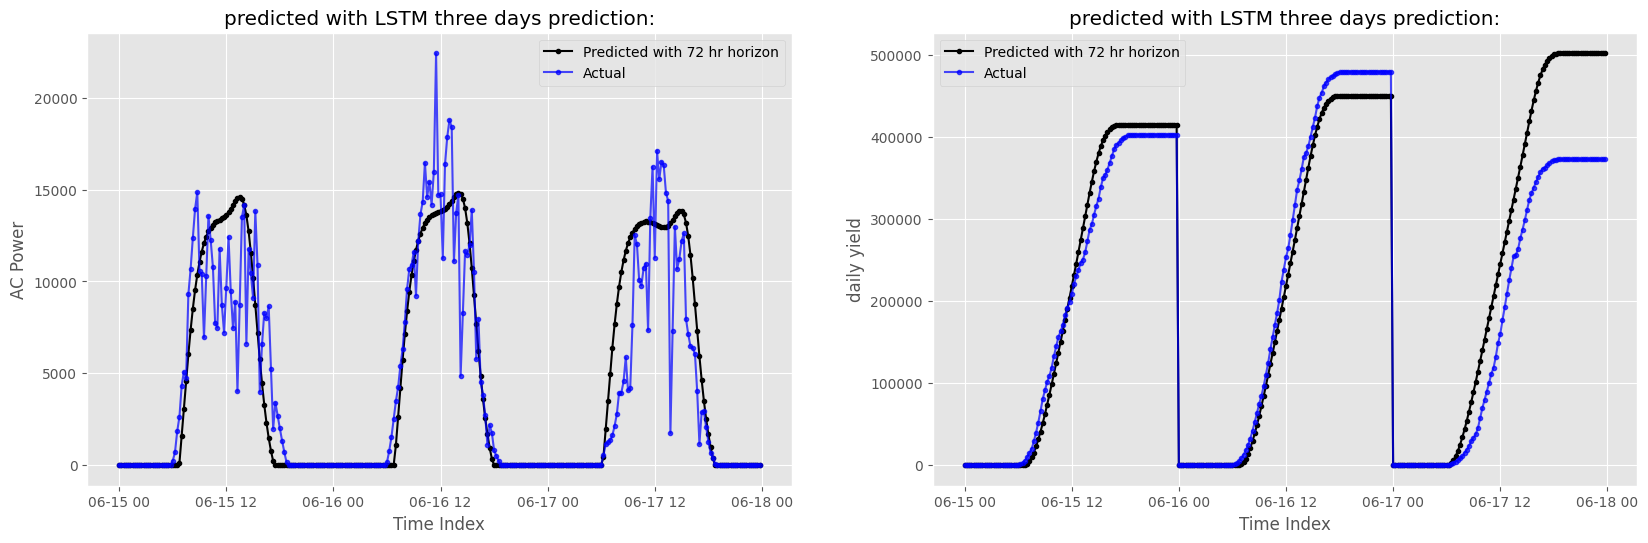

time: 641 ms (started: 2022-03-28 15:09:18 +02:00)


In [ ]:
plot_pred_vs_actual(results_lstm, 'LSTM three days prediction:')

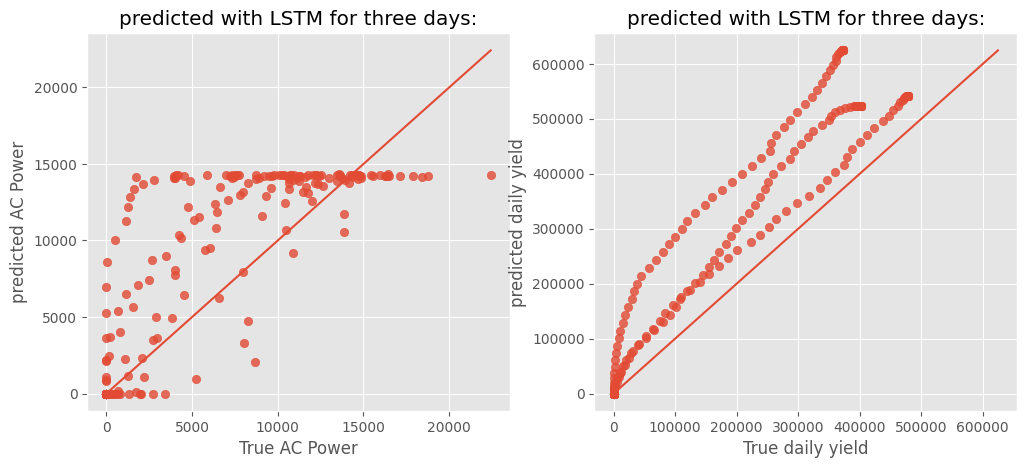

time: 594 ms (started: 2022-03-28 14:53:26 +02:00)


In [ ]:
plot_accuracy(results_lstm, 'LSTM for three days:')

In [ ]:
print_eval_scores(results_lstm, 'LSTM', hourly = False)

LSTM three day prediction
AC power R2 score:        57.632%    MAE:  2113.56kW
daily yield R2 score:     55.523%    MAE: 89997.00kWh
time: 16 ms (started: 2022-03-28 14:53:26 +02:00)


# 5: Evaluation of the model predictions

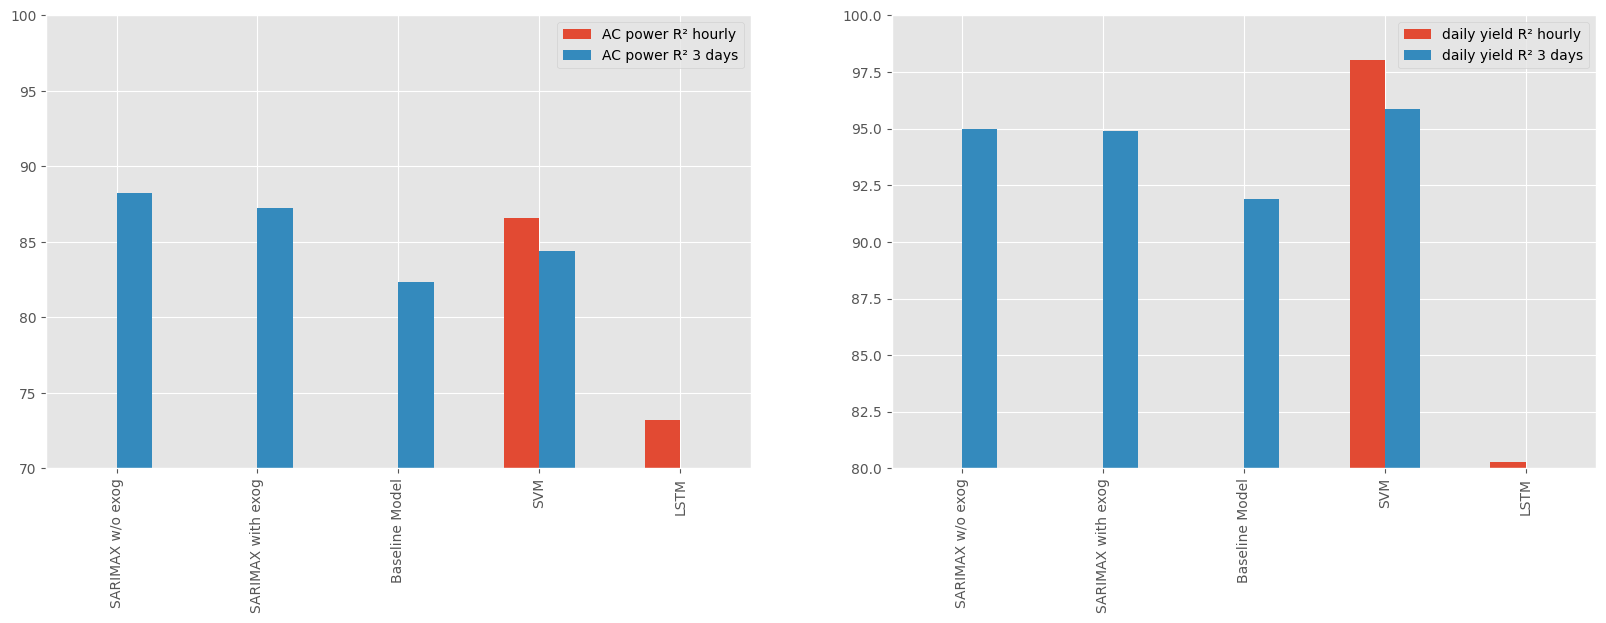

time: 578 ms (started: 2022-03-28 14:53:27 +02:00)


In [ ]:
fig,ax = plt.subplots(ncols=2,nrows=1, dpi=100,figsize=(20,6))
ax[0].set_ylim(70,100)
ax[1].set_ylim(80,100)
scores_all_models.iloc[[0,4]].T.plot.bar(ax = ax[0]);
scores_all_models.iloc[[2,6]].T.plot.bar(ax = ax[1]);

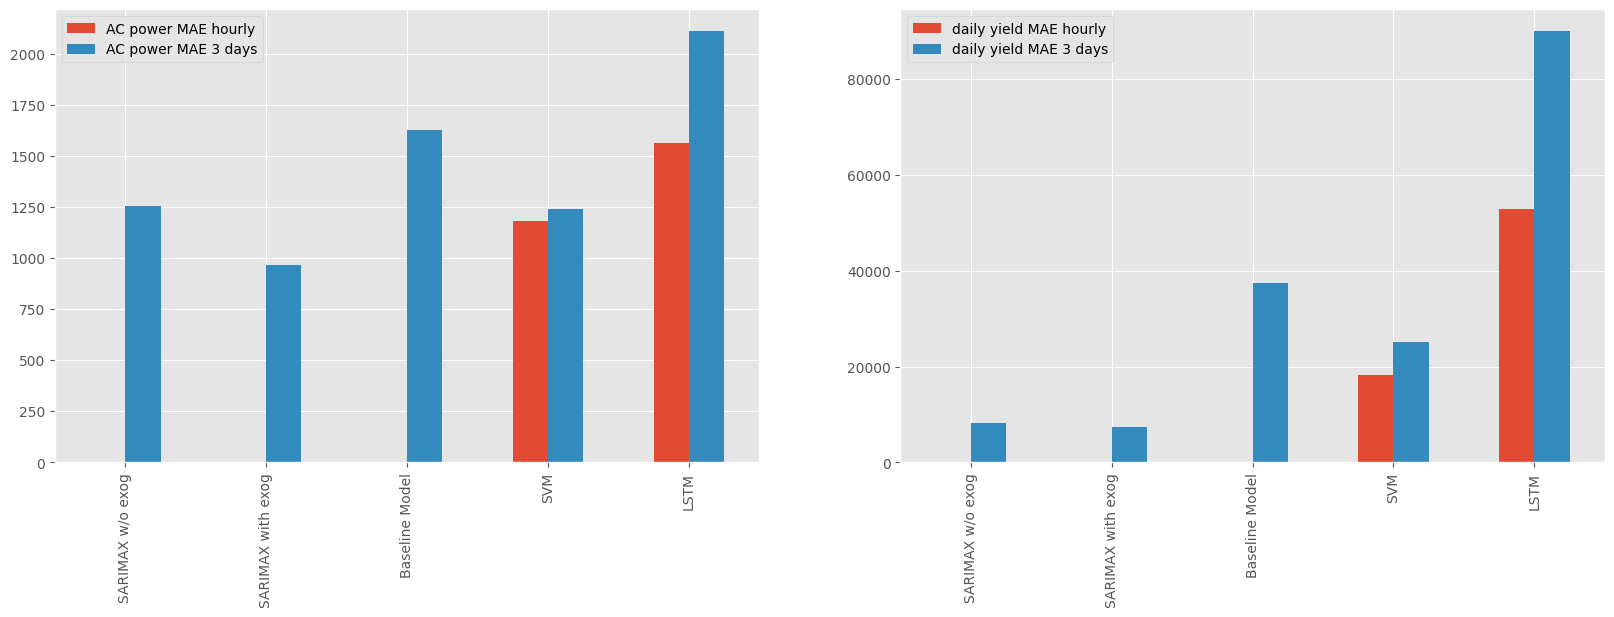

time: 531 ms (started: 2022-03-28 14:53:27 +02:00)


In [ ]:
fig,ax = plt.subplots(ncols=2,nrows=1, dpi=100,figsize=(20,6))
scores_all_models.iloc[[1,5]].T.plot.bar(ax = ax[0]);
scores_all_models.iloc[[3,7]].T.plot.bar(ax = ax[1]);

# 6: Lessons Learnt and Conclusions